# Show the Data Spectra and Compare it with simulations

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [1]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [3]:
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [4]:
import seaborn as sns

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Figure style

In [6]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [7]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [8]:
PATH_SPECTRACTOR='../../Spectractor'
PATH_SPECTRACTORSIM='../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../merra2'

In [9]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [10]:
from spectractor import *
from libspecana import *

## Input spectra

### LogBook

In [11]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [12]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [13]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [14]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [15]:
home=os.getenv('HOME')

In [16]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [17]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [18]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [19]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [20]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [21]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [22]:
PATH_SPECTRACTORSIM

'../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [23]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')

In [24]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'

## Selection of night

In [25]:
date="20170610"

In [26]:
idx_sel_subdir=11

In [27]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [28]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [29]:
all_obs_extr=all_obs[["index","object"]]

### path for spectra

In [30]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [31]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [32]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    all_sel_indexes.append(sel_index)
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows

- use the indexes obtained to extract the relevant rows from the logbook

In [33]:
SelFlag=[]
for index, row in all_obs.iterrows():
  if row["index"] in all_sel_indexes:
    SelFlag.append(True)
  else:
    SelFlag.append(False)

In [34]:
sel_obs=all_obs[SelFlag]

### Quick view on the kind of sources

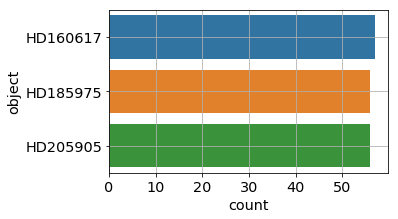

In [35]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

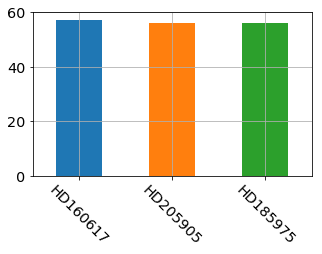

In [36]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad sources

In [37]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD160617','HD185975','HD205905'])]

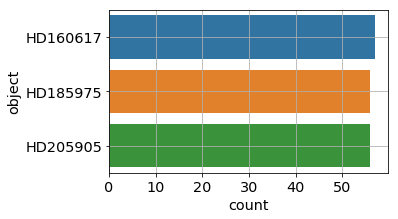

In [38]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

### find filename for sim spectra

In [39]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [40]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [41]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/clearsky/specsim_20170610_135_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/clearsky/specsim_20170610_136_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/clearsky/specsim_20170610_137_spectrum.fits']

In [42]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [43]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/standard/specsim_20170610_135_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/standard/specsim_20170610_136_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/standard/specsim_20170610_137_spectrum.fits']

In [44]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [45]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/merra2/specsim_20170610_135_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/merra2/specsim_20170610_136_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/merra2/specsim_20170610_137_spectrum.fits']

# Plot spectra

In [46]:
NBSPECTRA=len(all_spectrafiles)

In [47]:
NBSPECTRA

169

In [48]:
filename=all_spectrafiles[0]
print filename

/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1/data_10jun17/reduc_20170610_135_spectrum.fits


In [49]:
simfilename=all_simspectrafiles1[0]
print simfilename

/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/clearsky/specsim_20170610_135_spectrum.fits


In [50]:
spec=Spectrum(filename=filename)

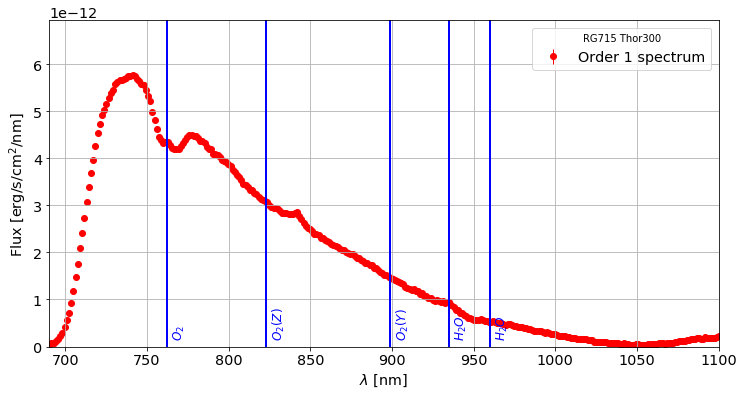

In [51]:
spec.plot_spectrum(nofit=True)

In [52]:
simspec=Spectrum(filename=simfilename)

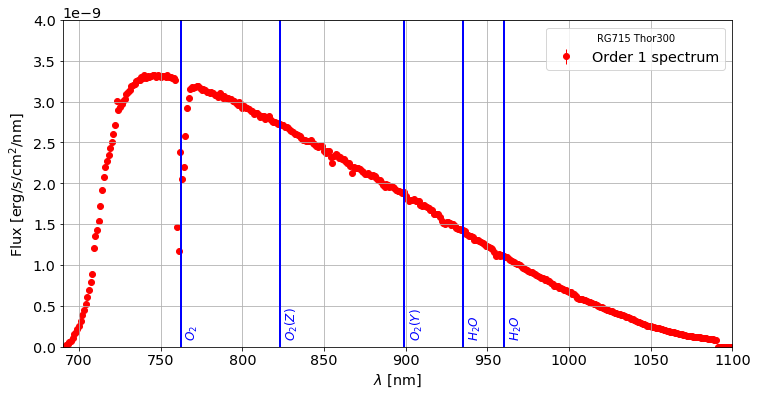

In [53]:
simspec.plot_spectrum(nofit=True)

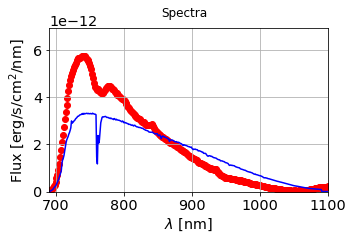

In [54]:
f, ax = plt.subplots(figsize=(5,3))
f.suptitle('Spectra')
spec.plot_spectrum_simple(ax=ax)
#simspec.plot_spectrum_simple(ax=ax)
ax.plot(simspec.lambdas,simspec.data*1e-3,'b-')
plt.show()

In [55]:
!ulimit -a 2048

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


# Plot all spectra

In [56]:
NBPLOTS=NBSPECTRA

- check the O2 line

In [57]:
O2WL=762.1

## Simple plot of spectra

/Users/dagoret/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


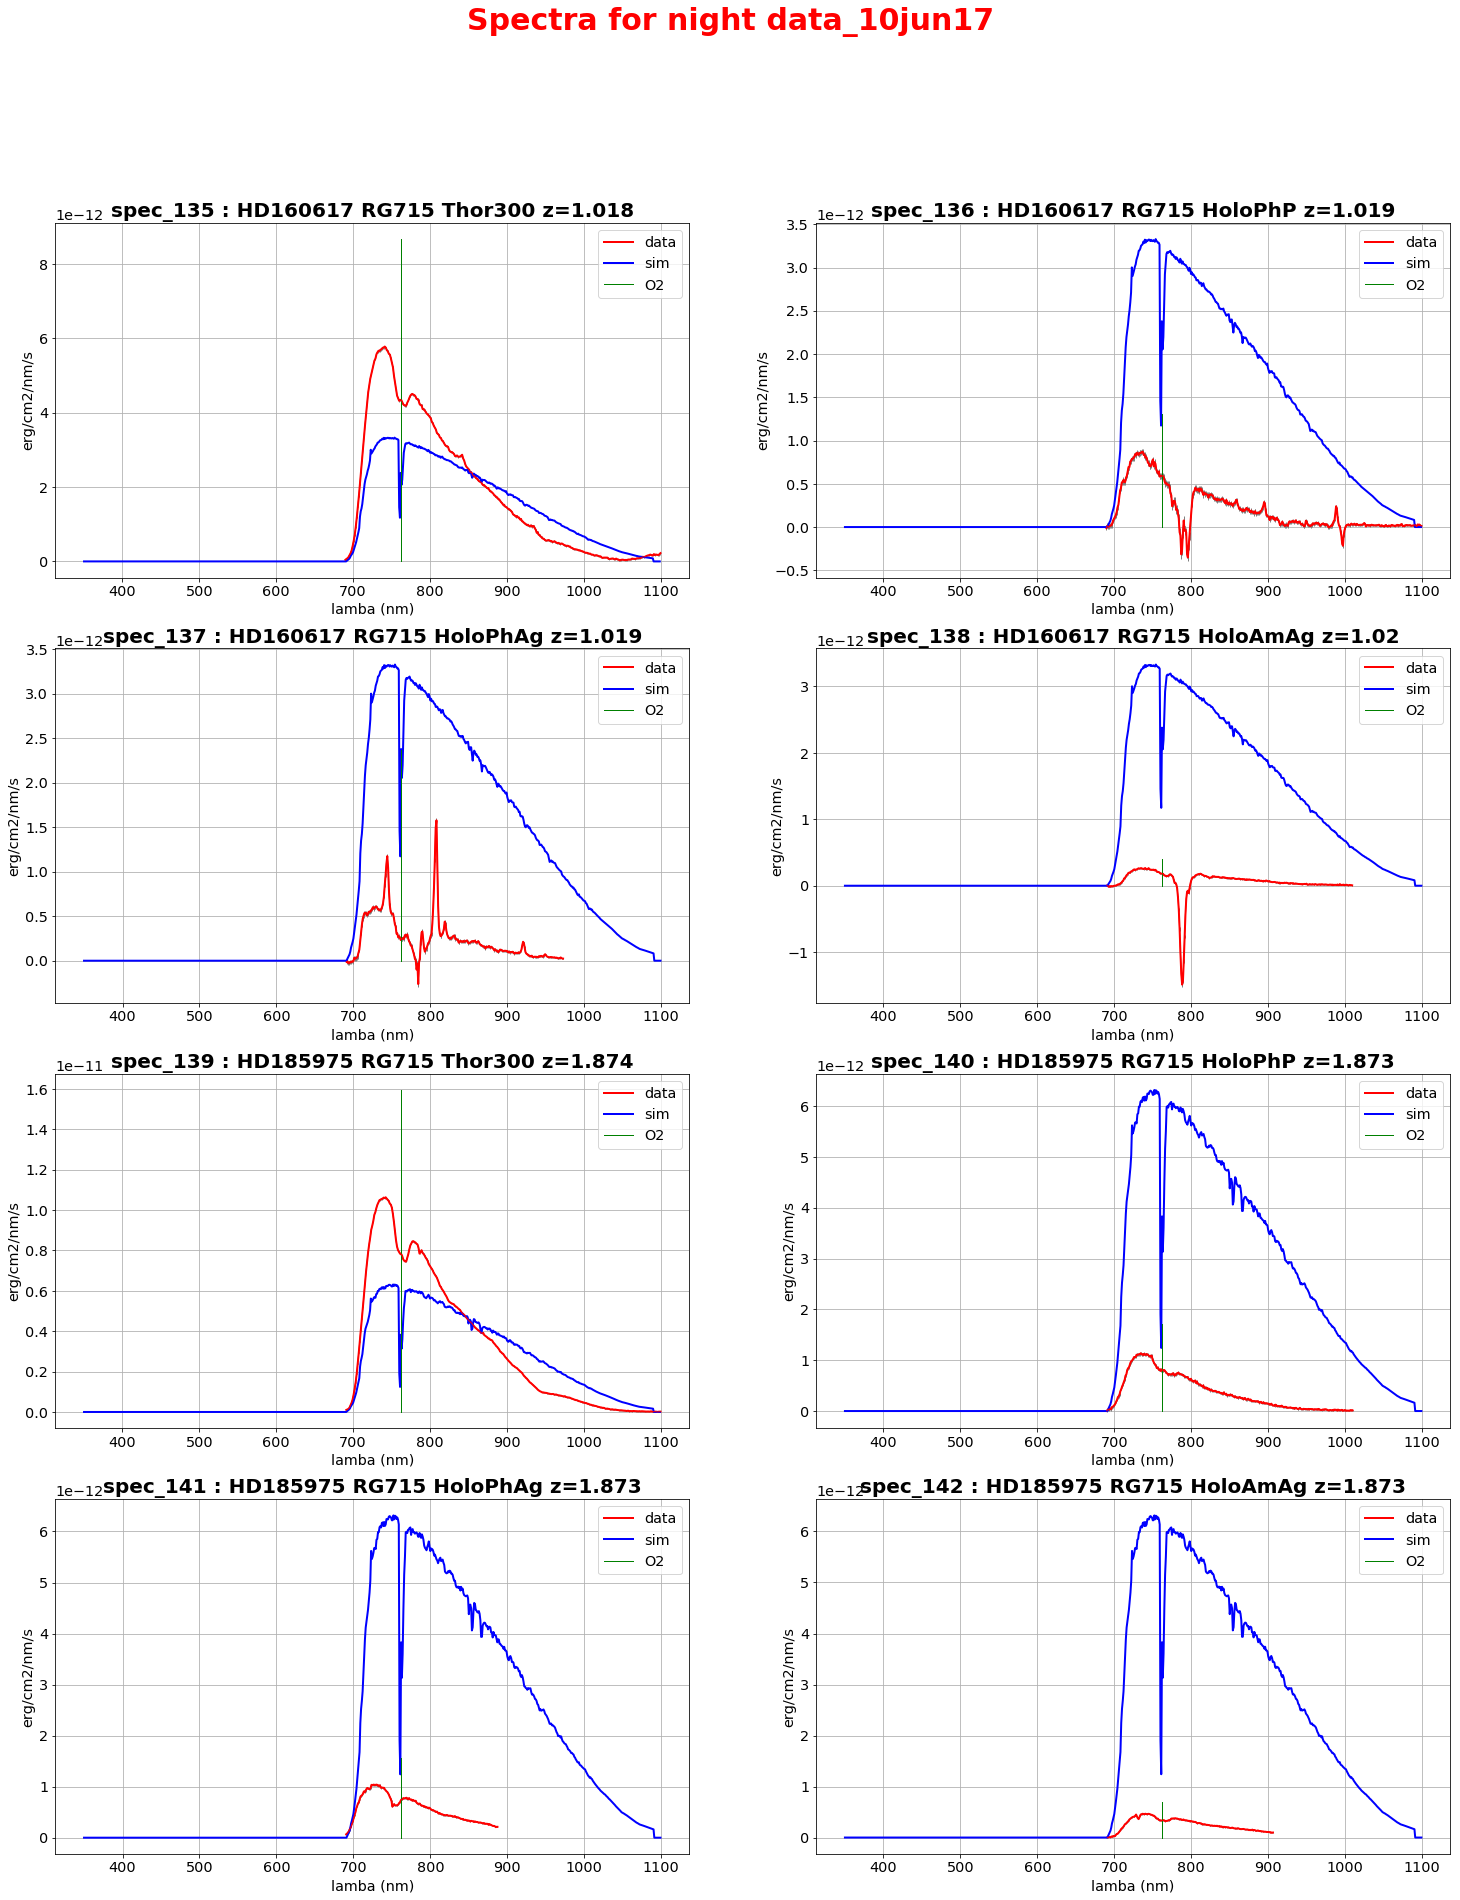

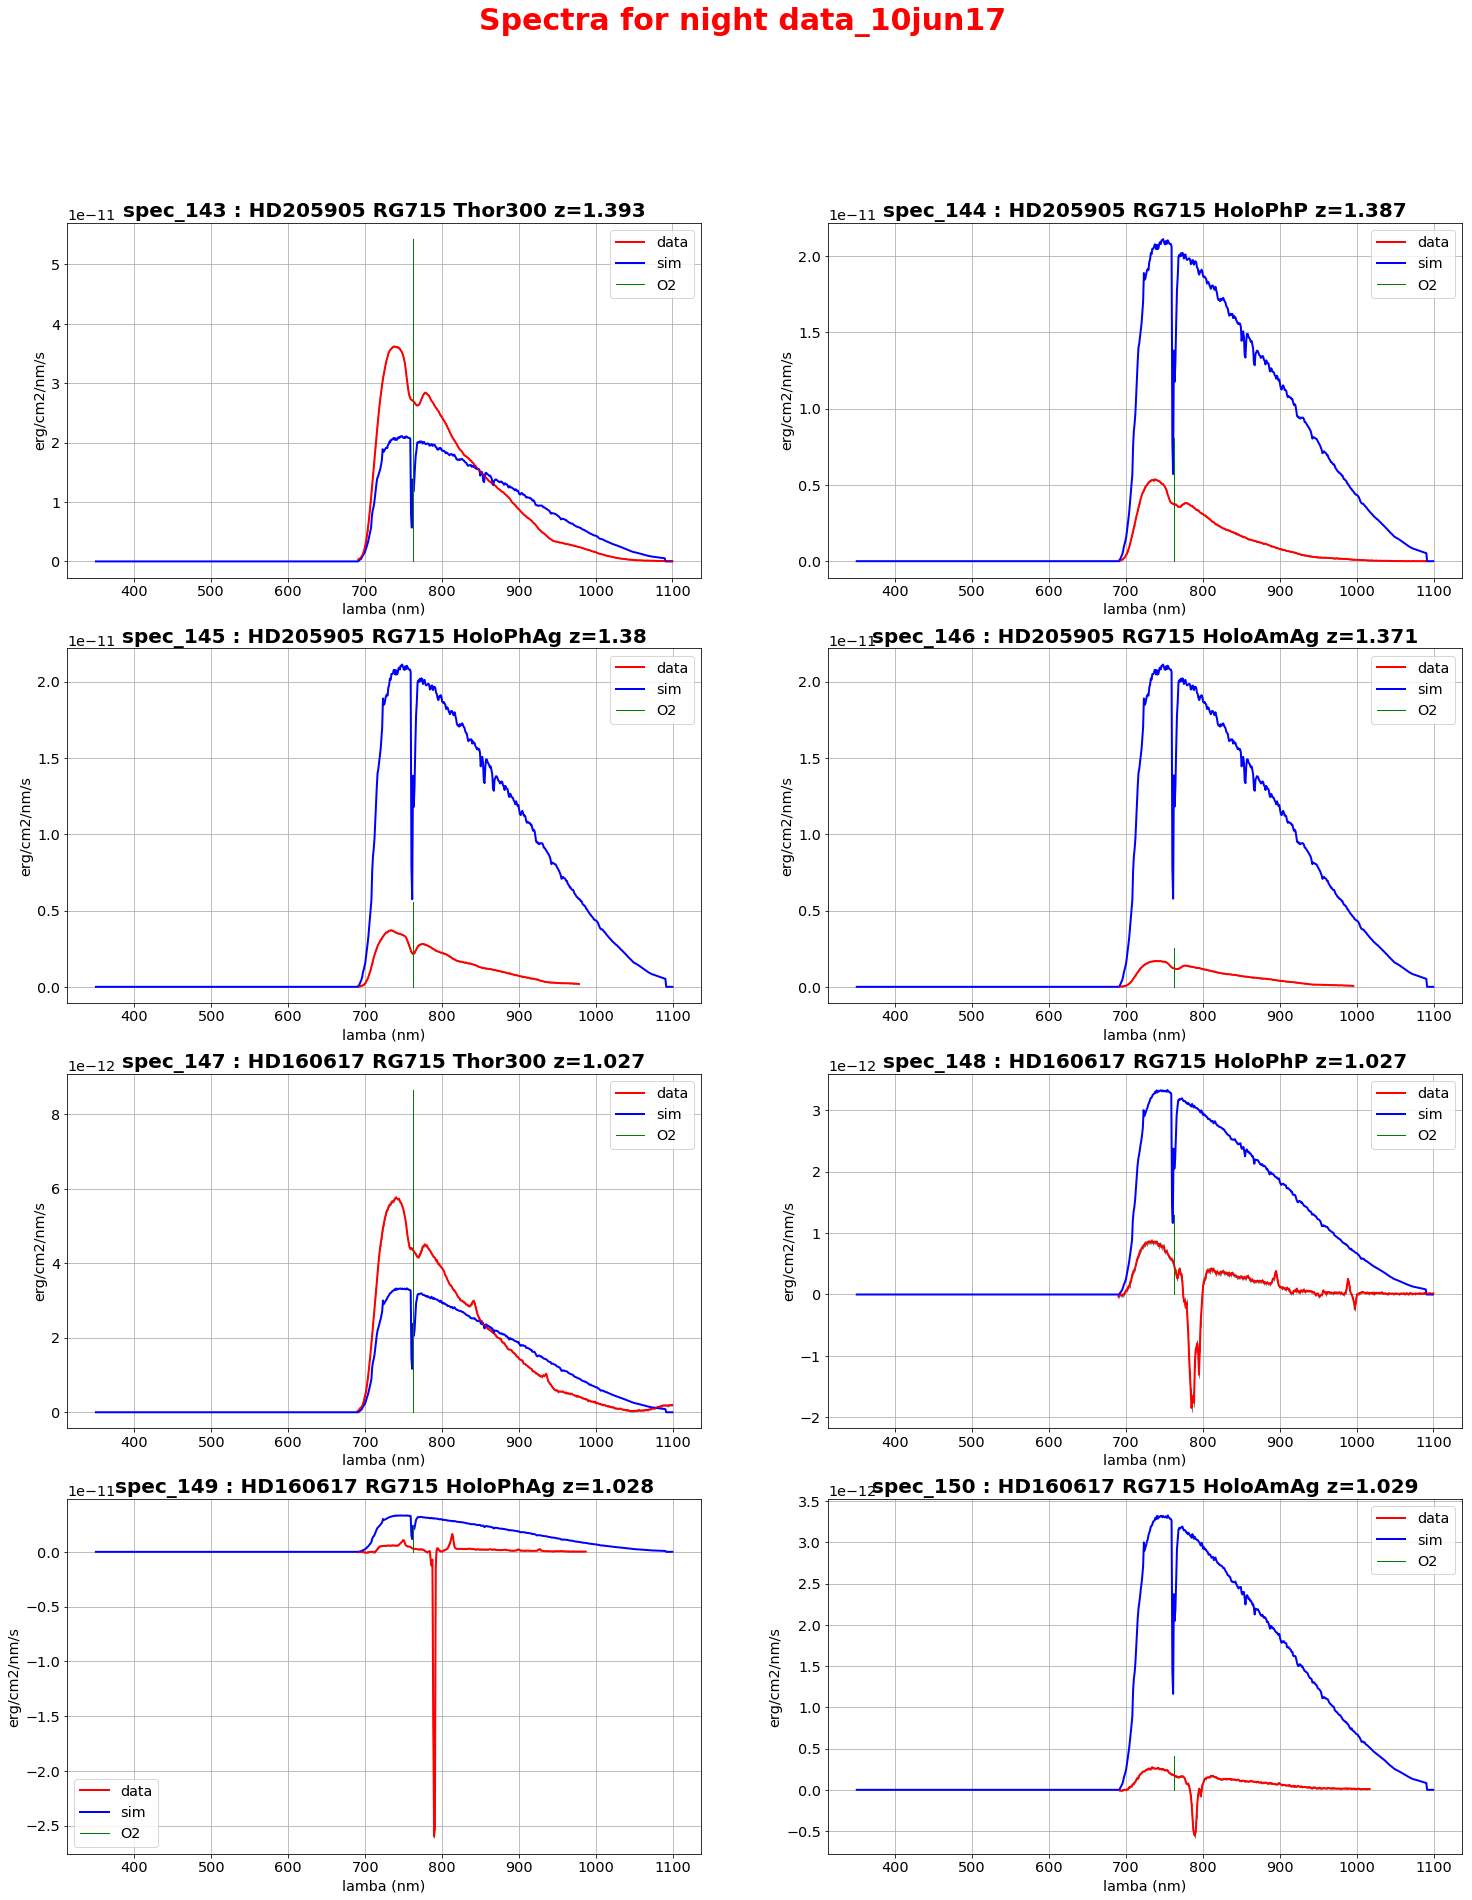

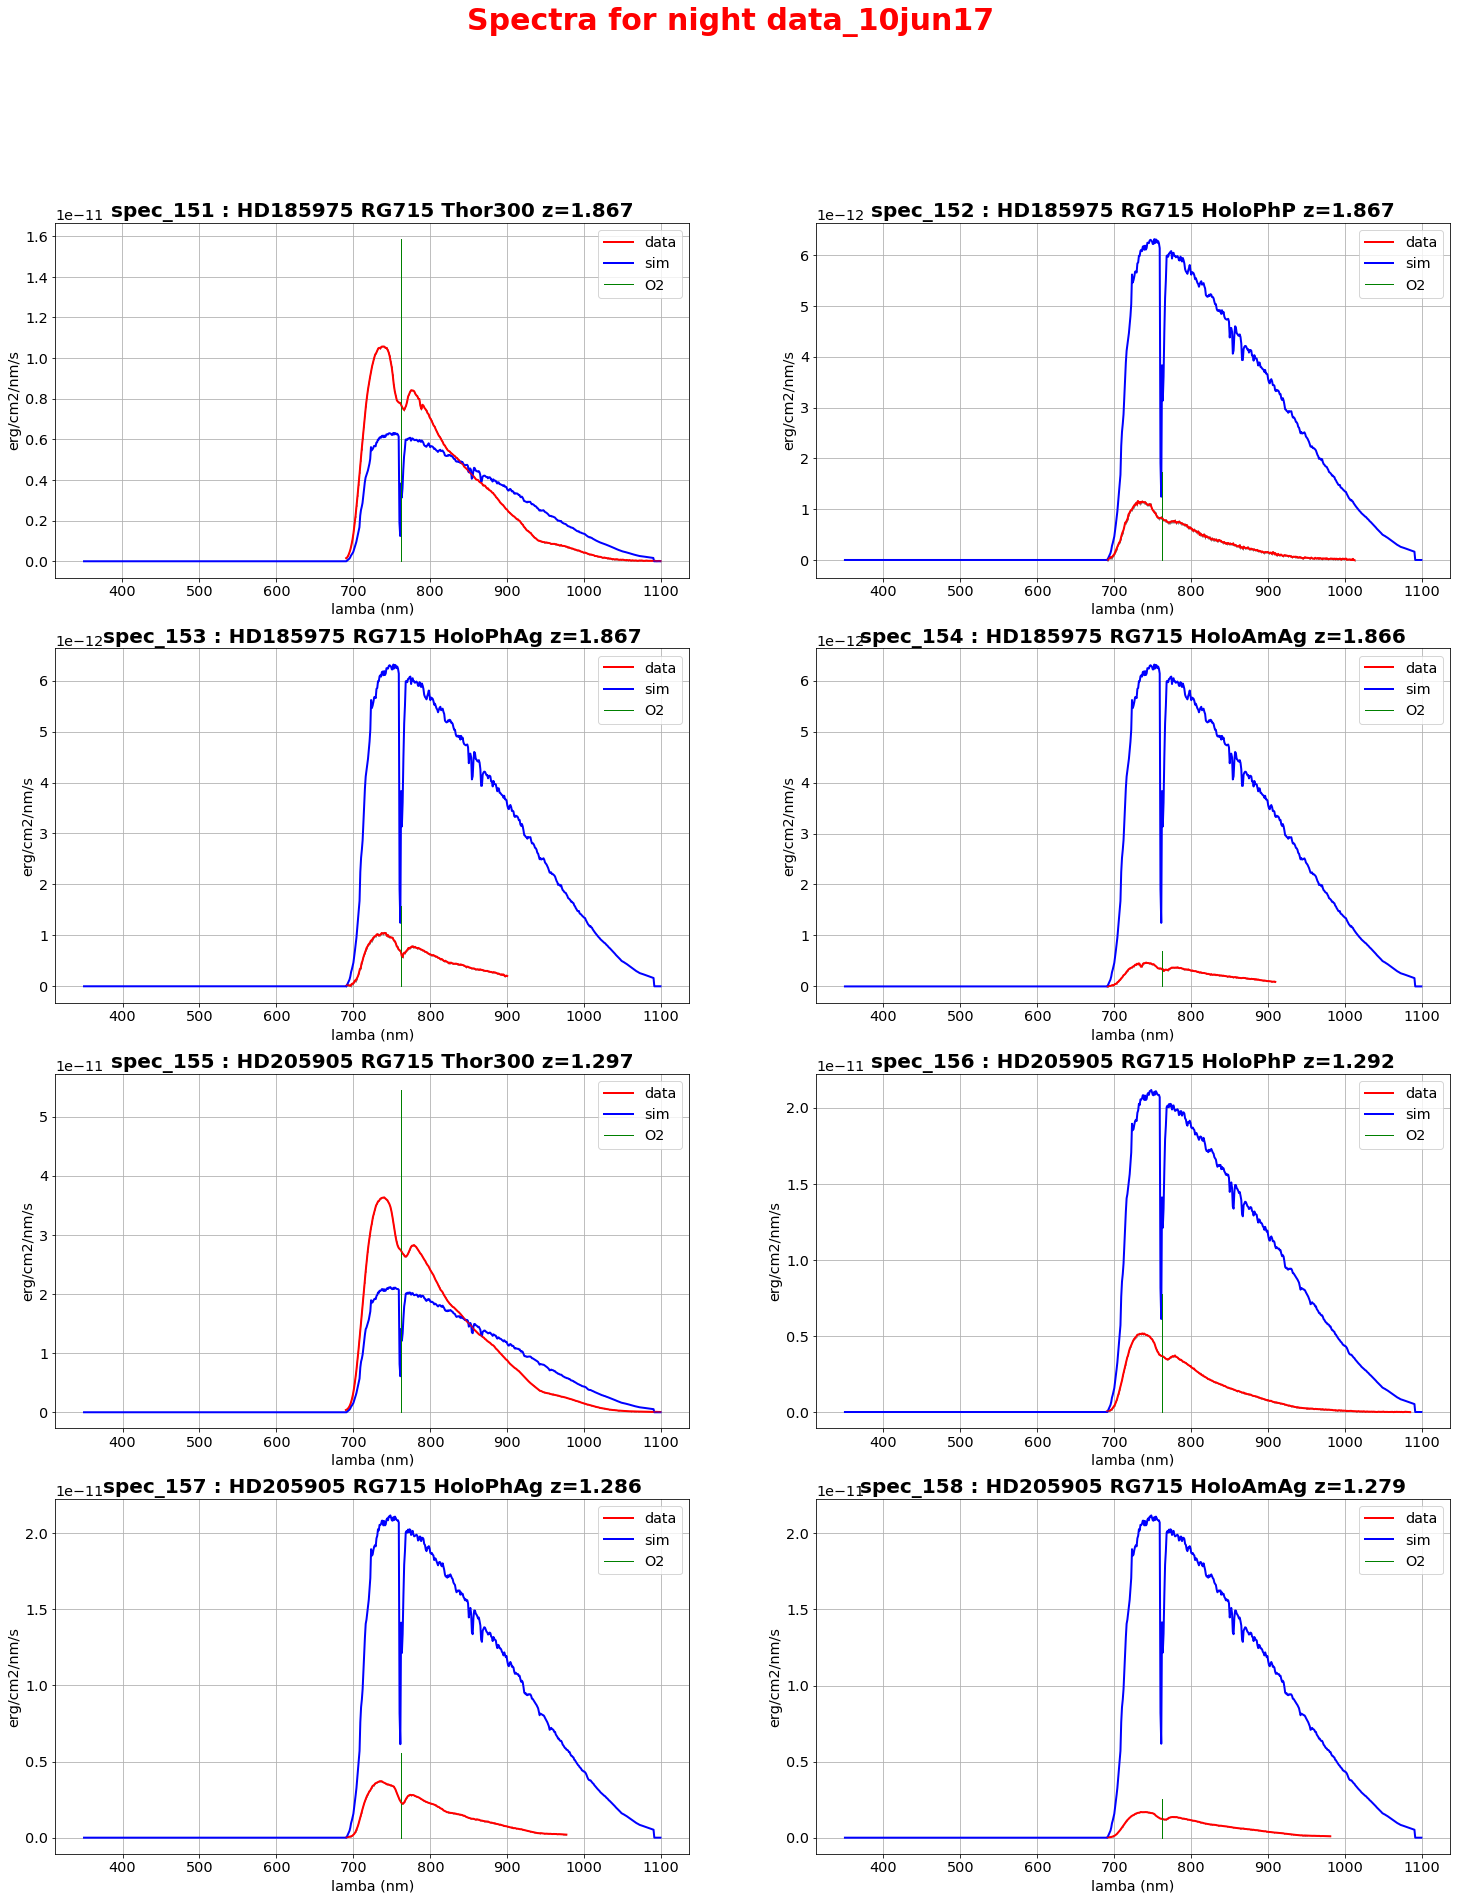

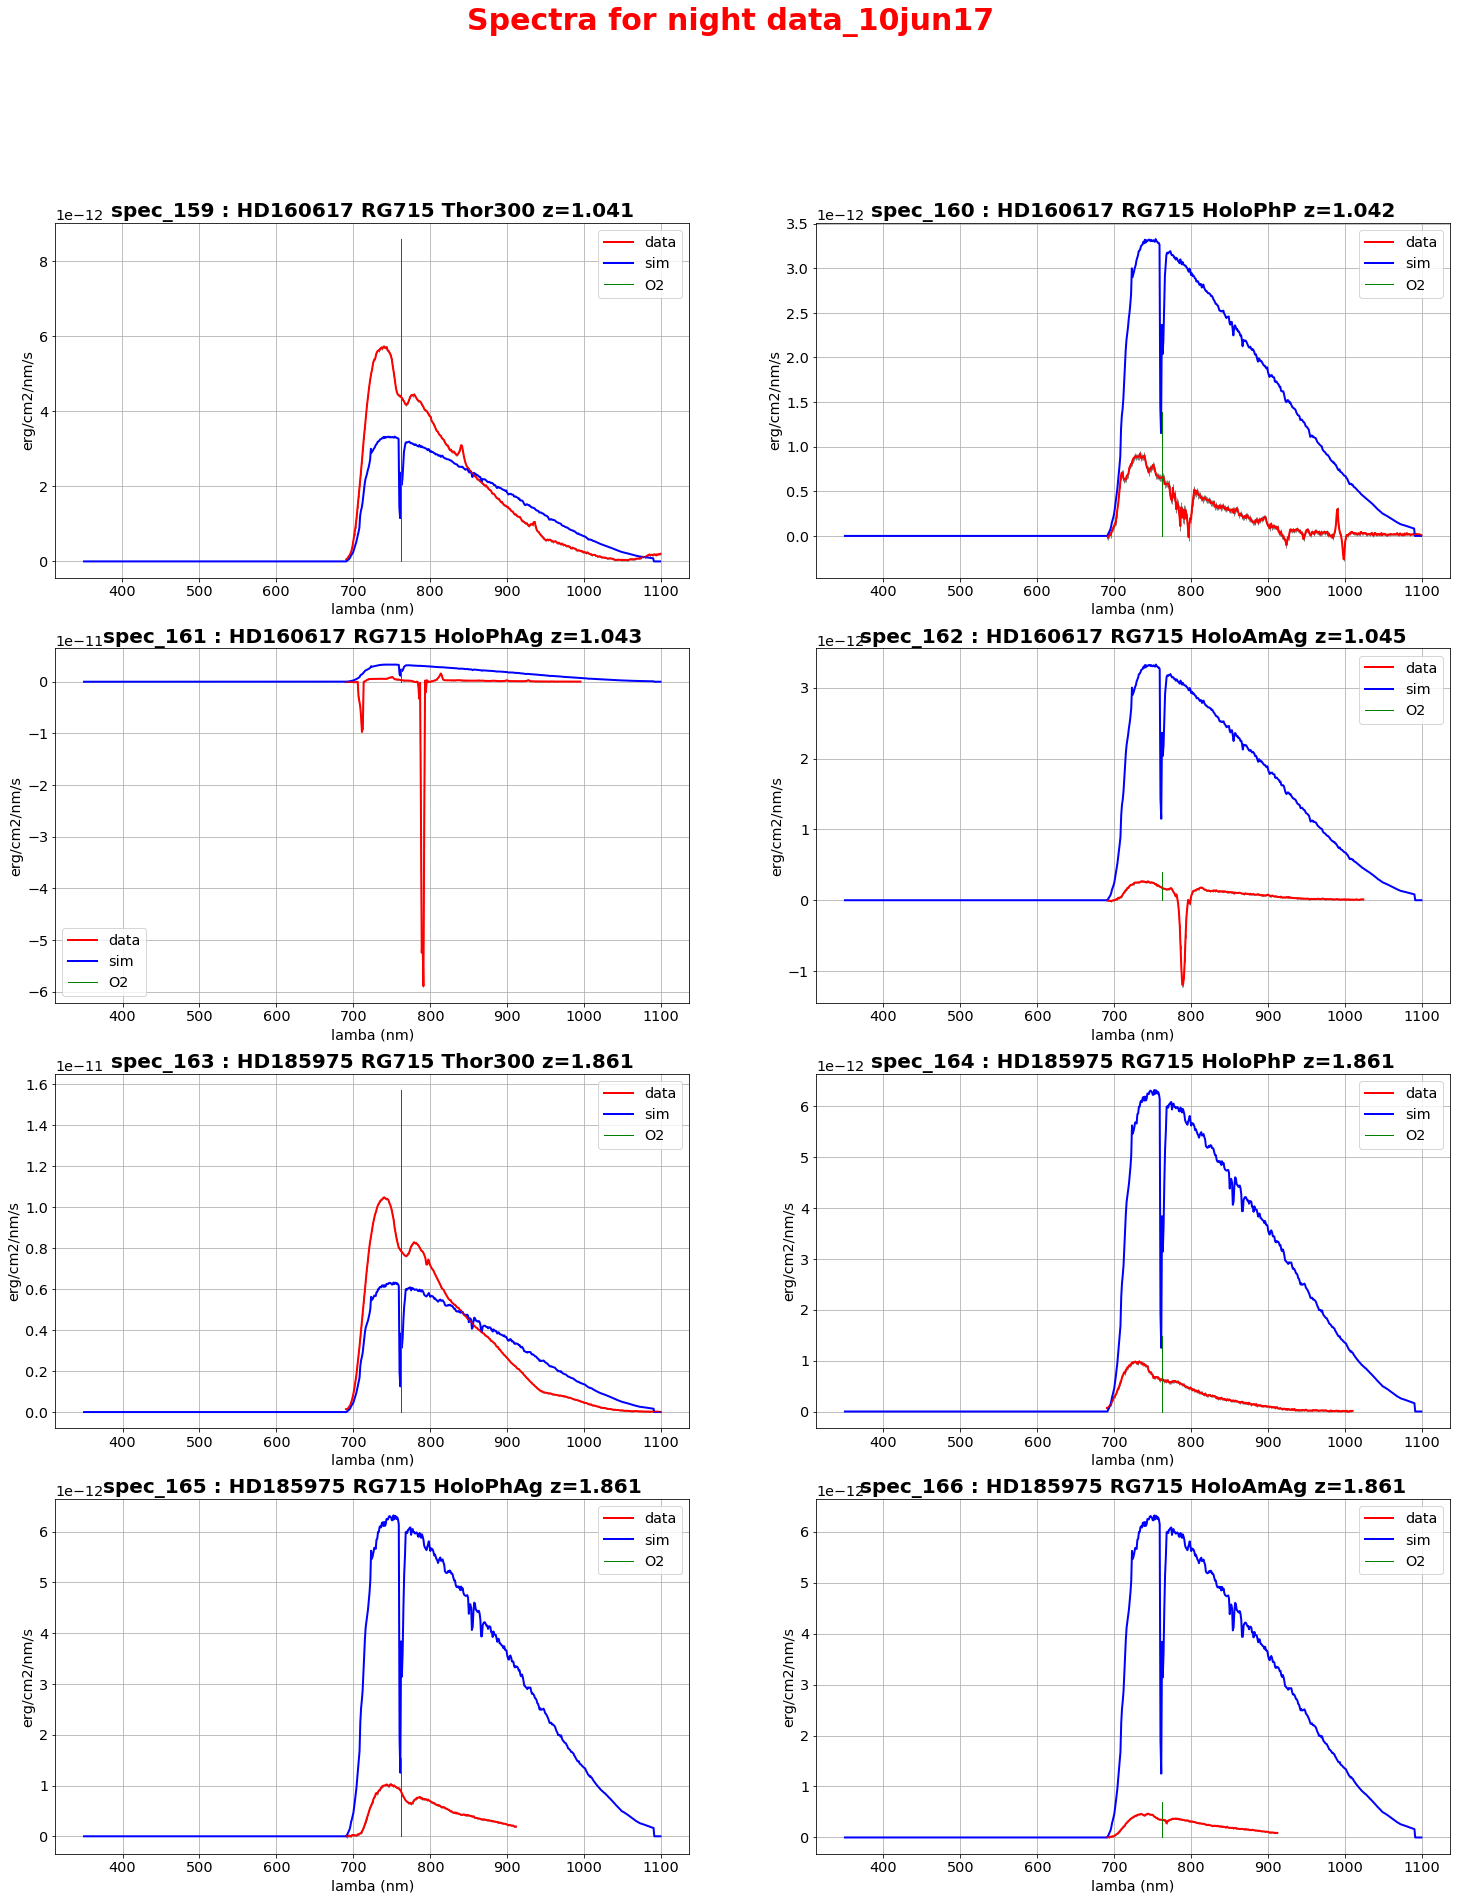

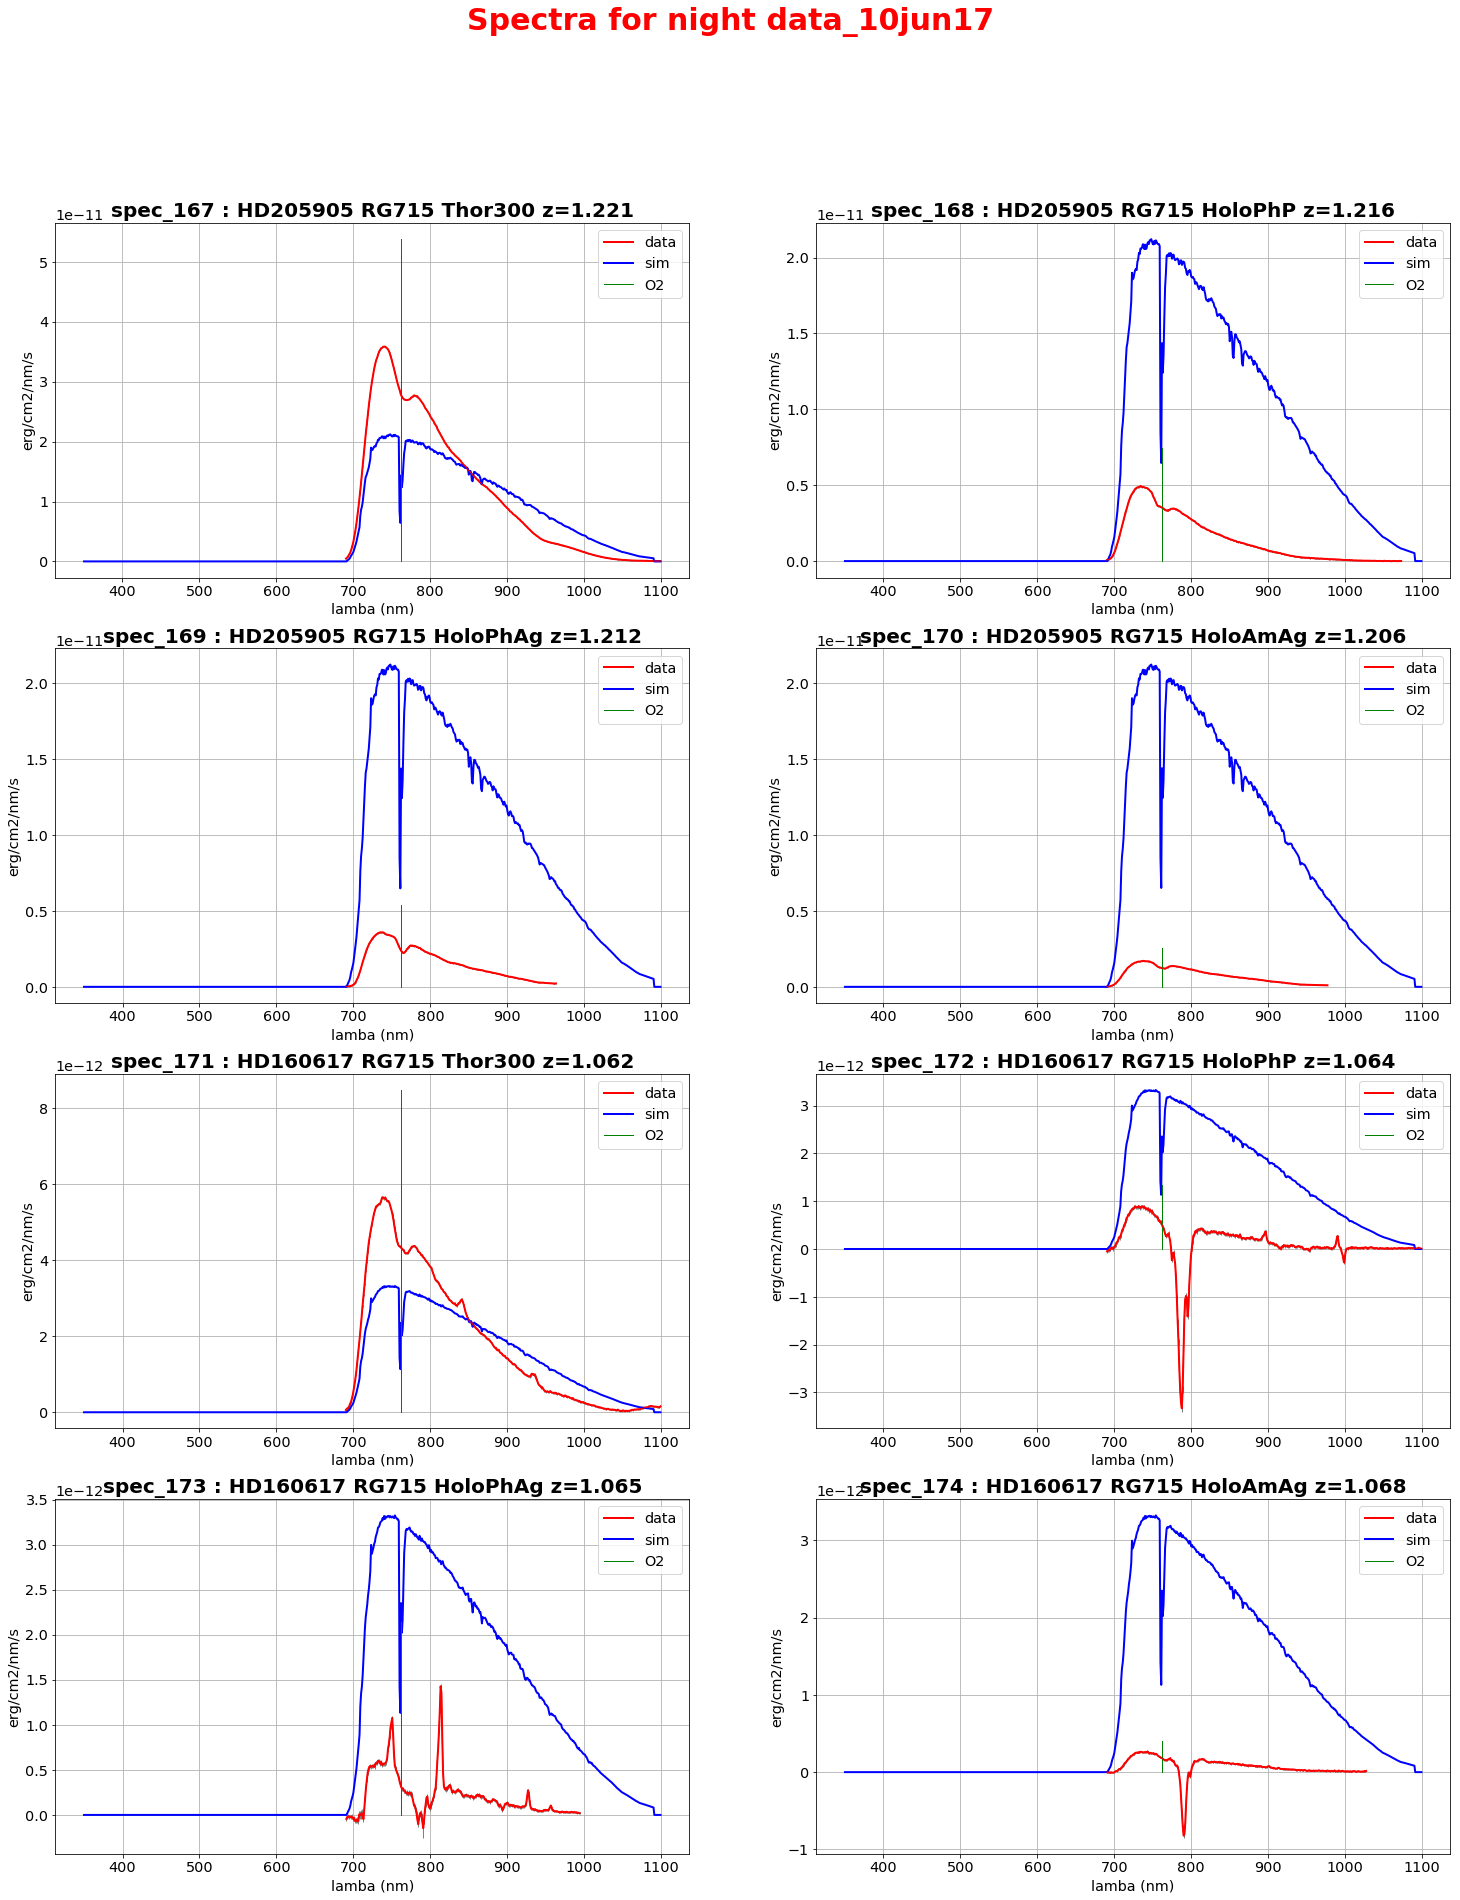

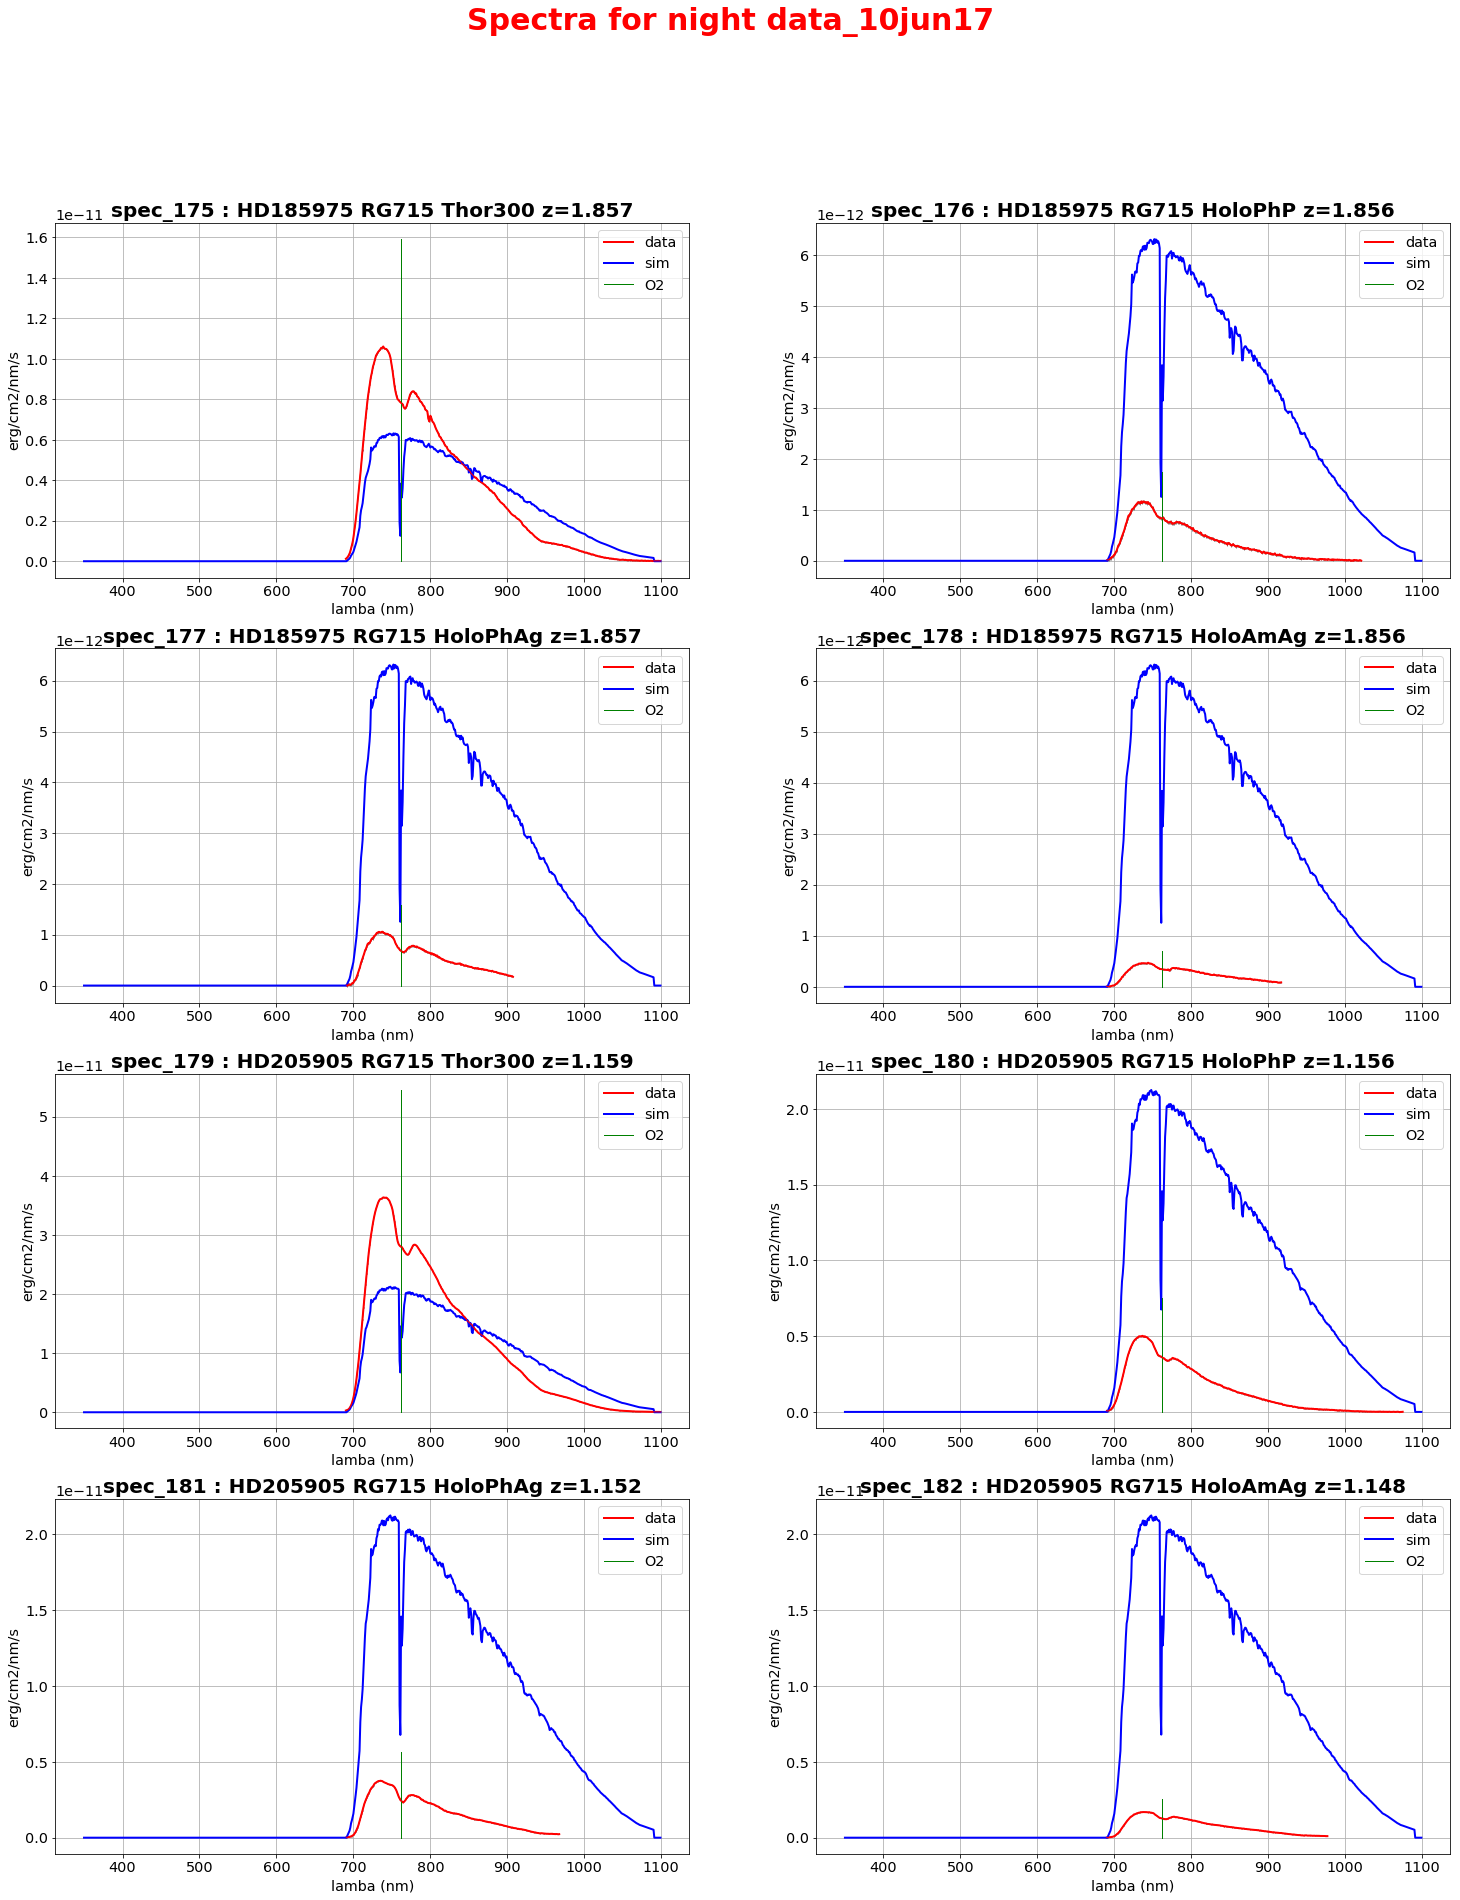

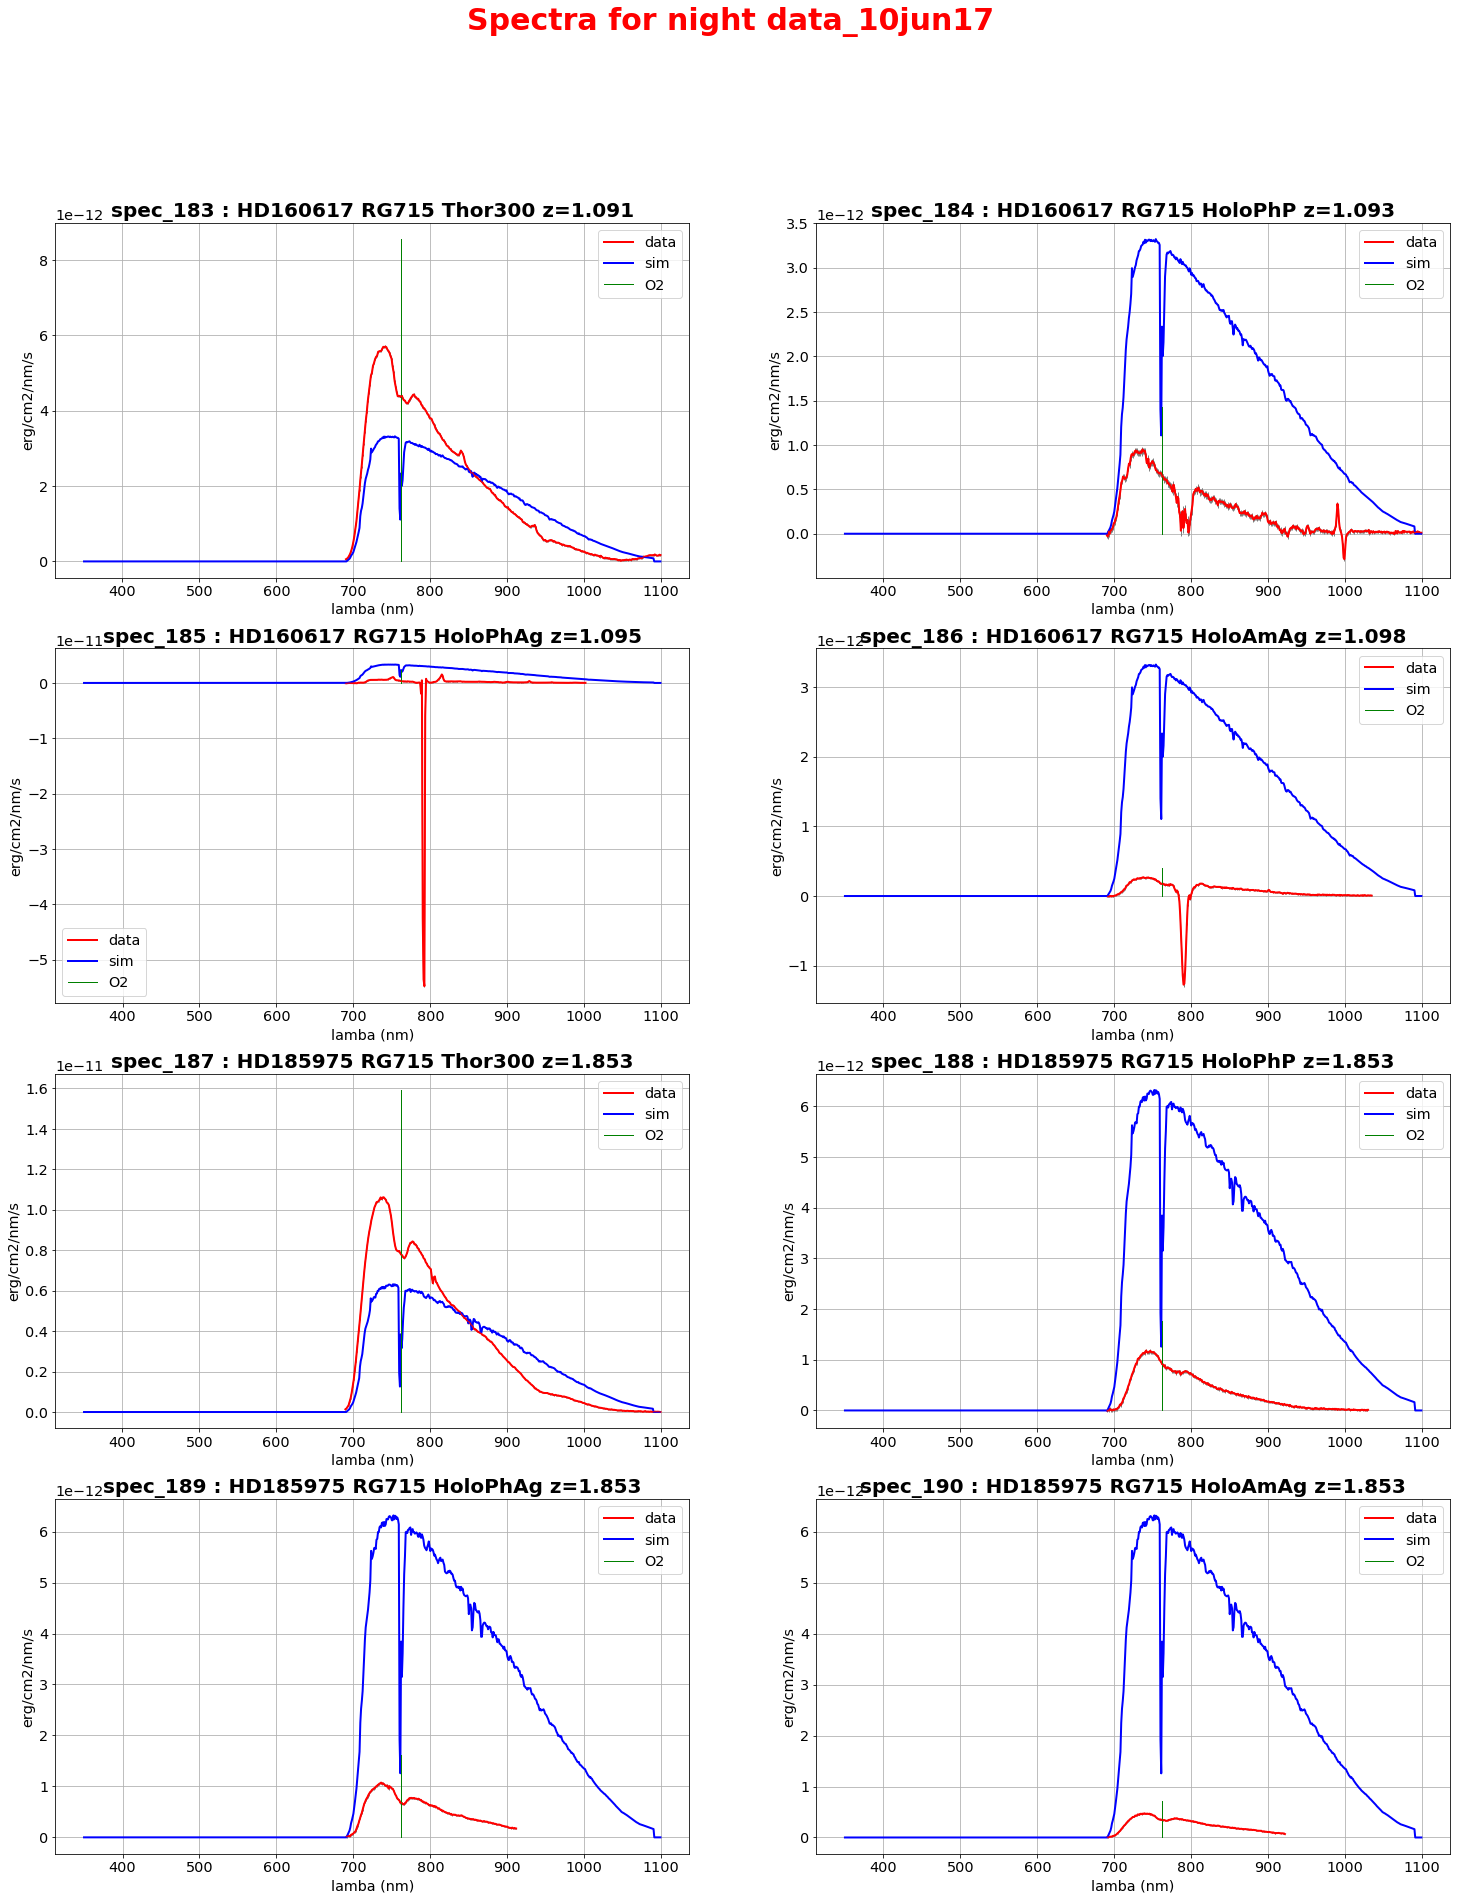

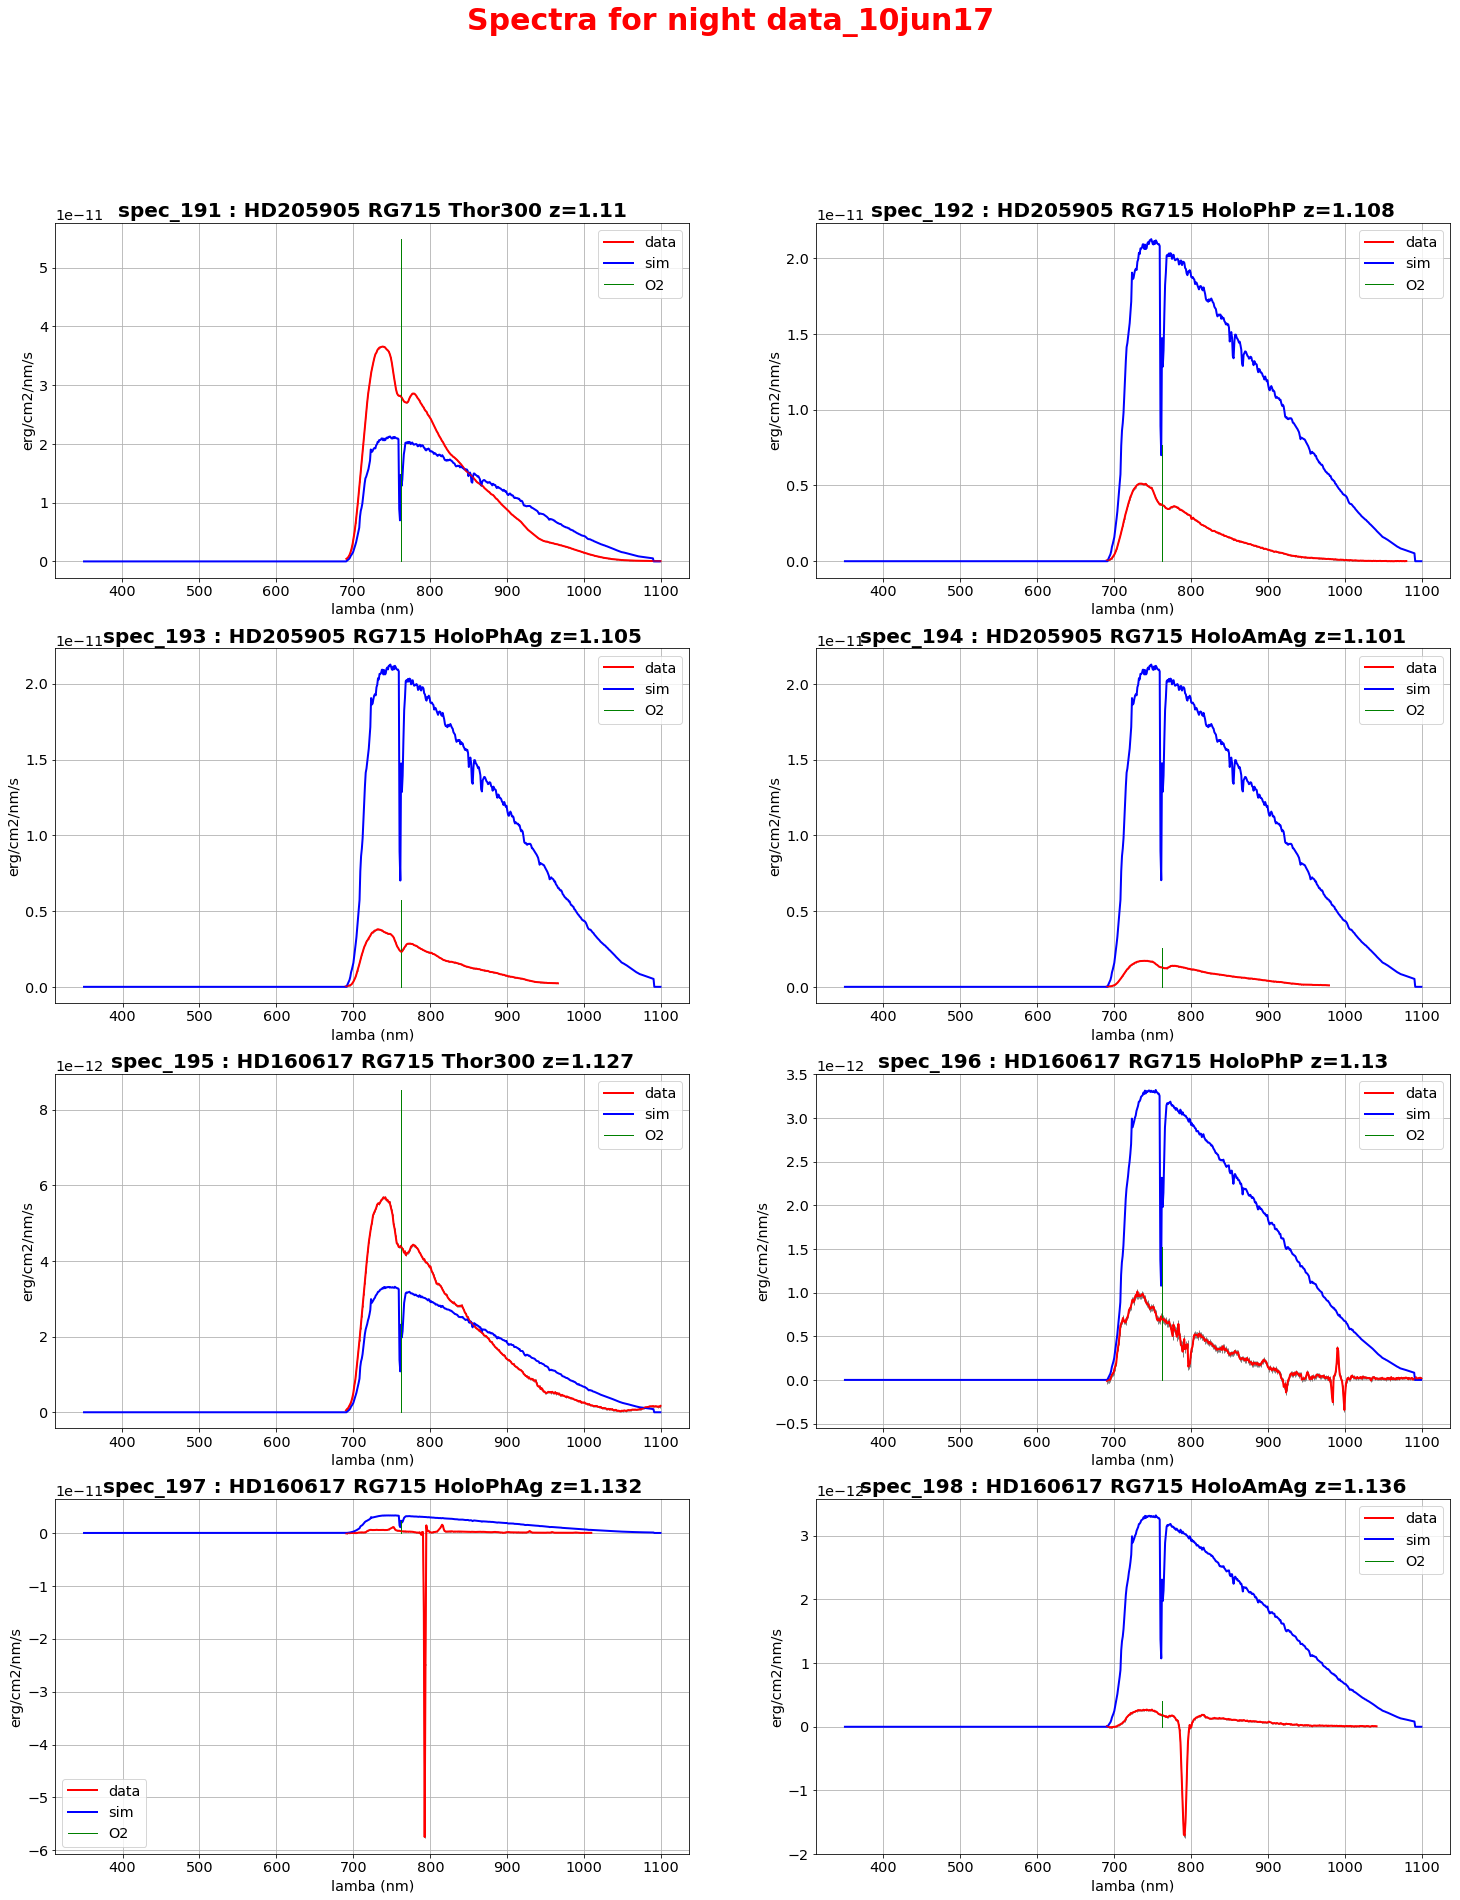

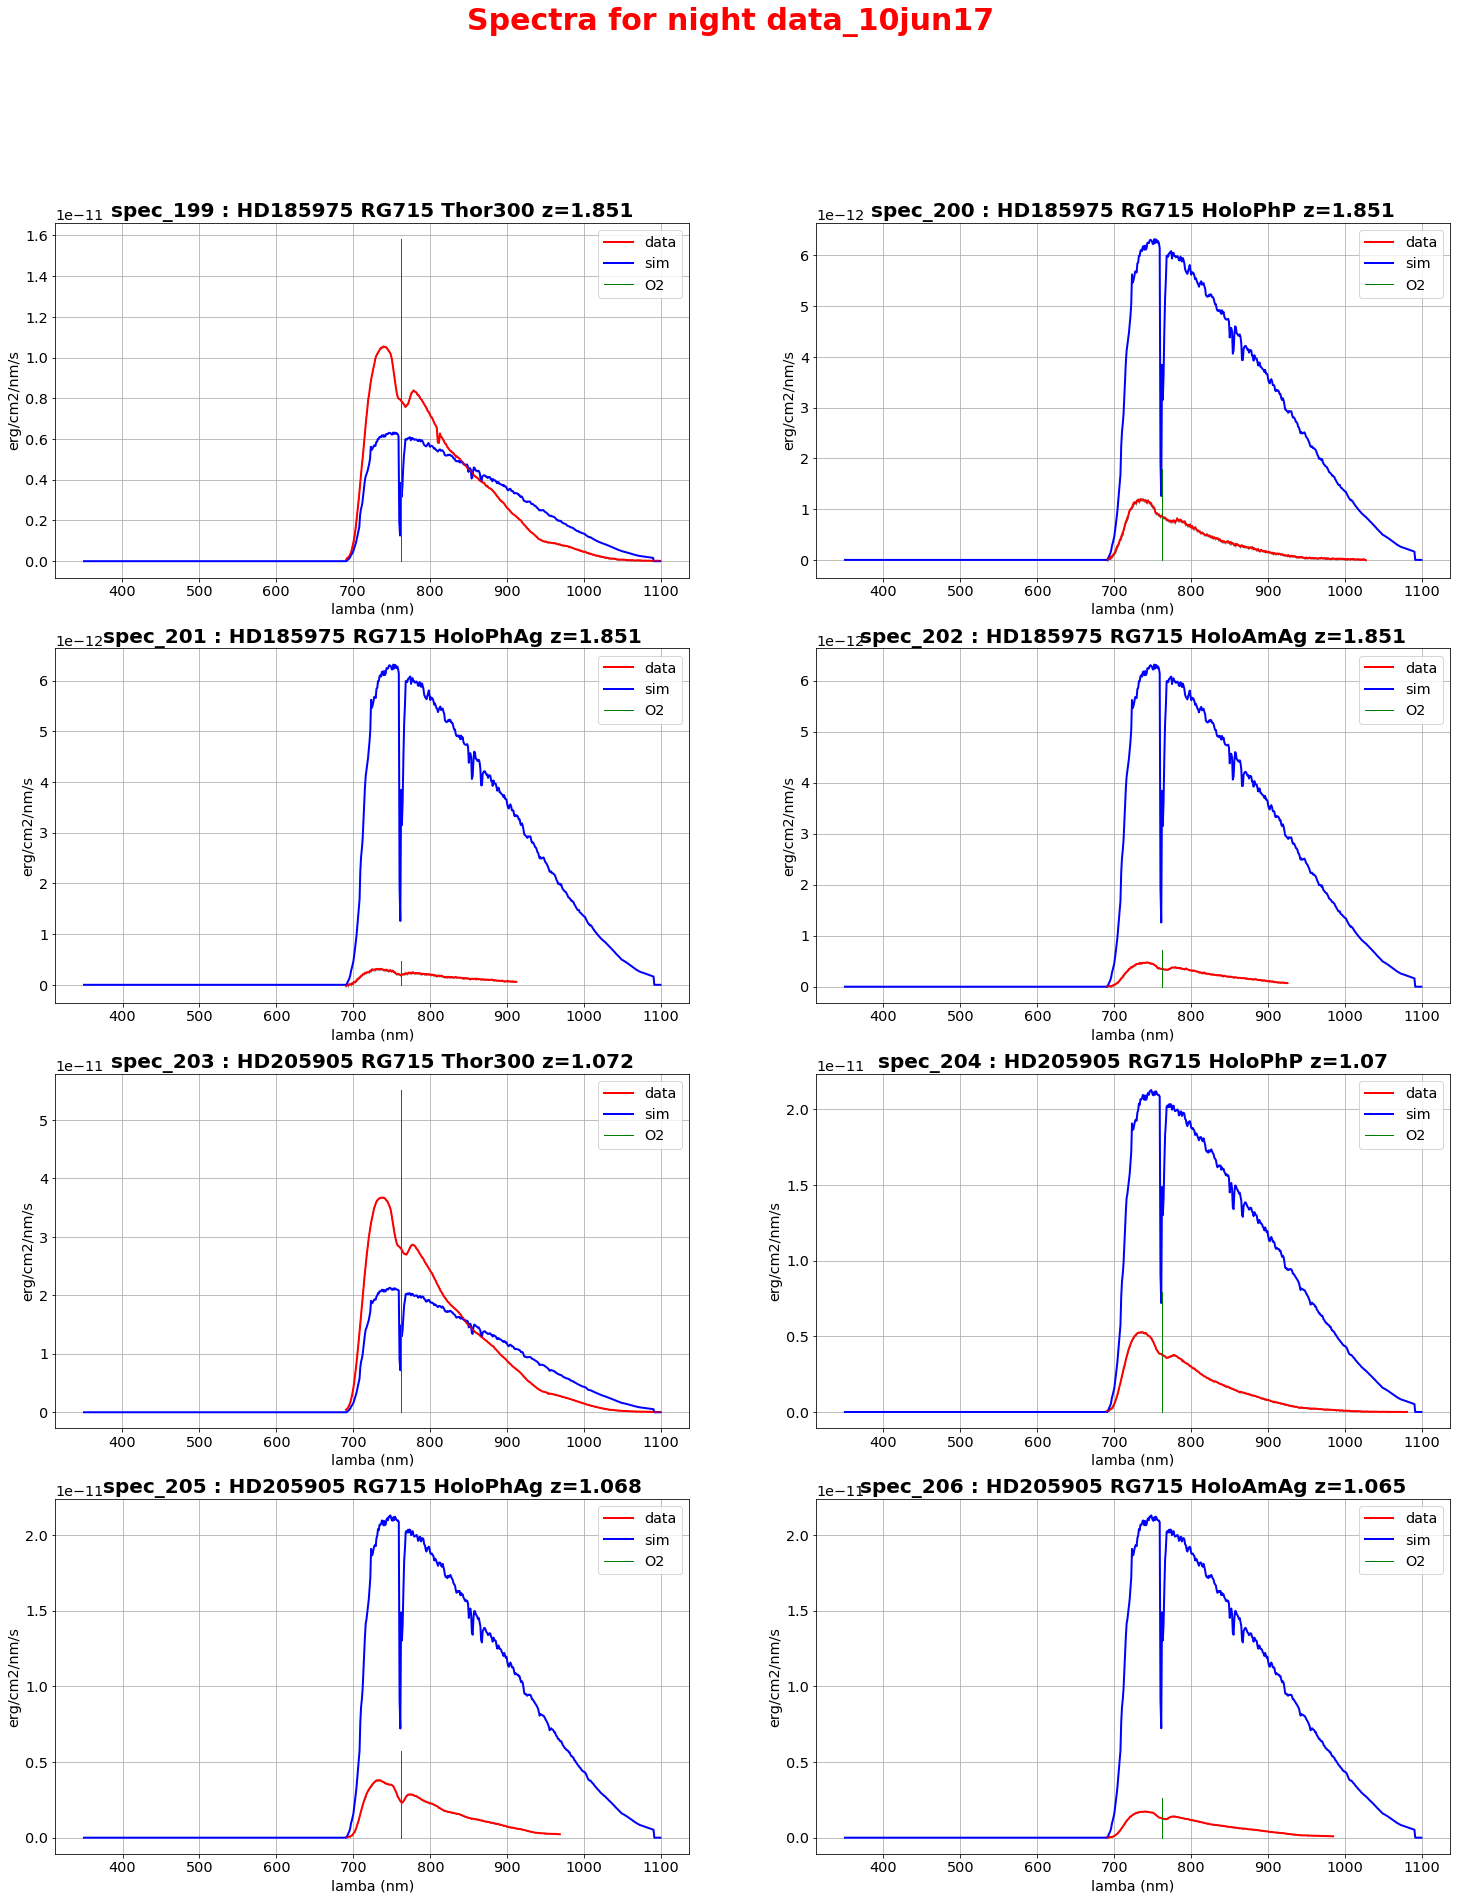

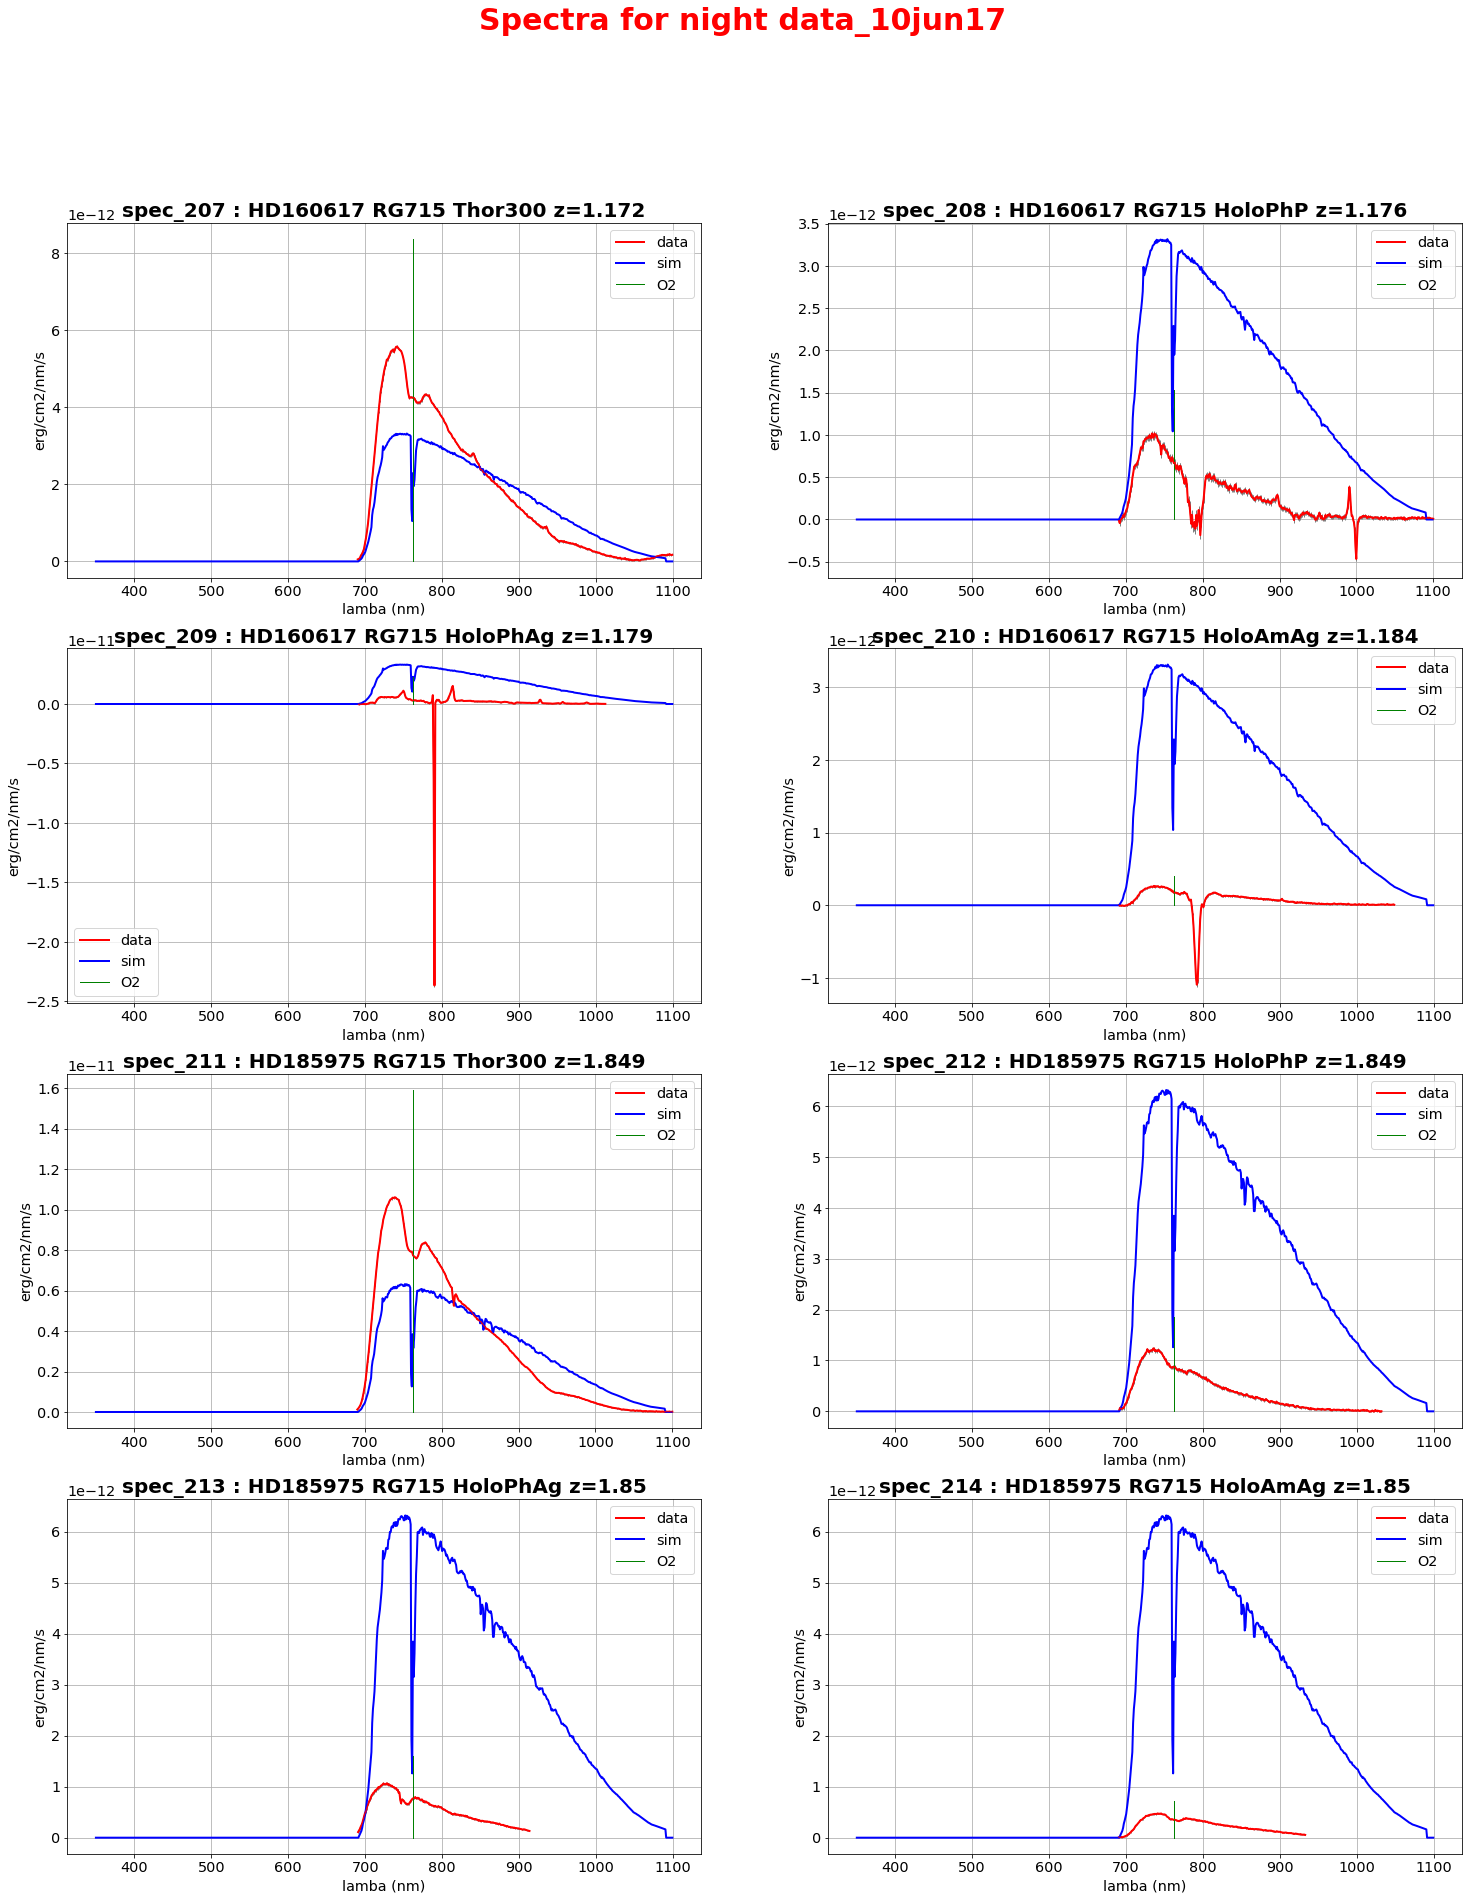

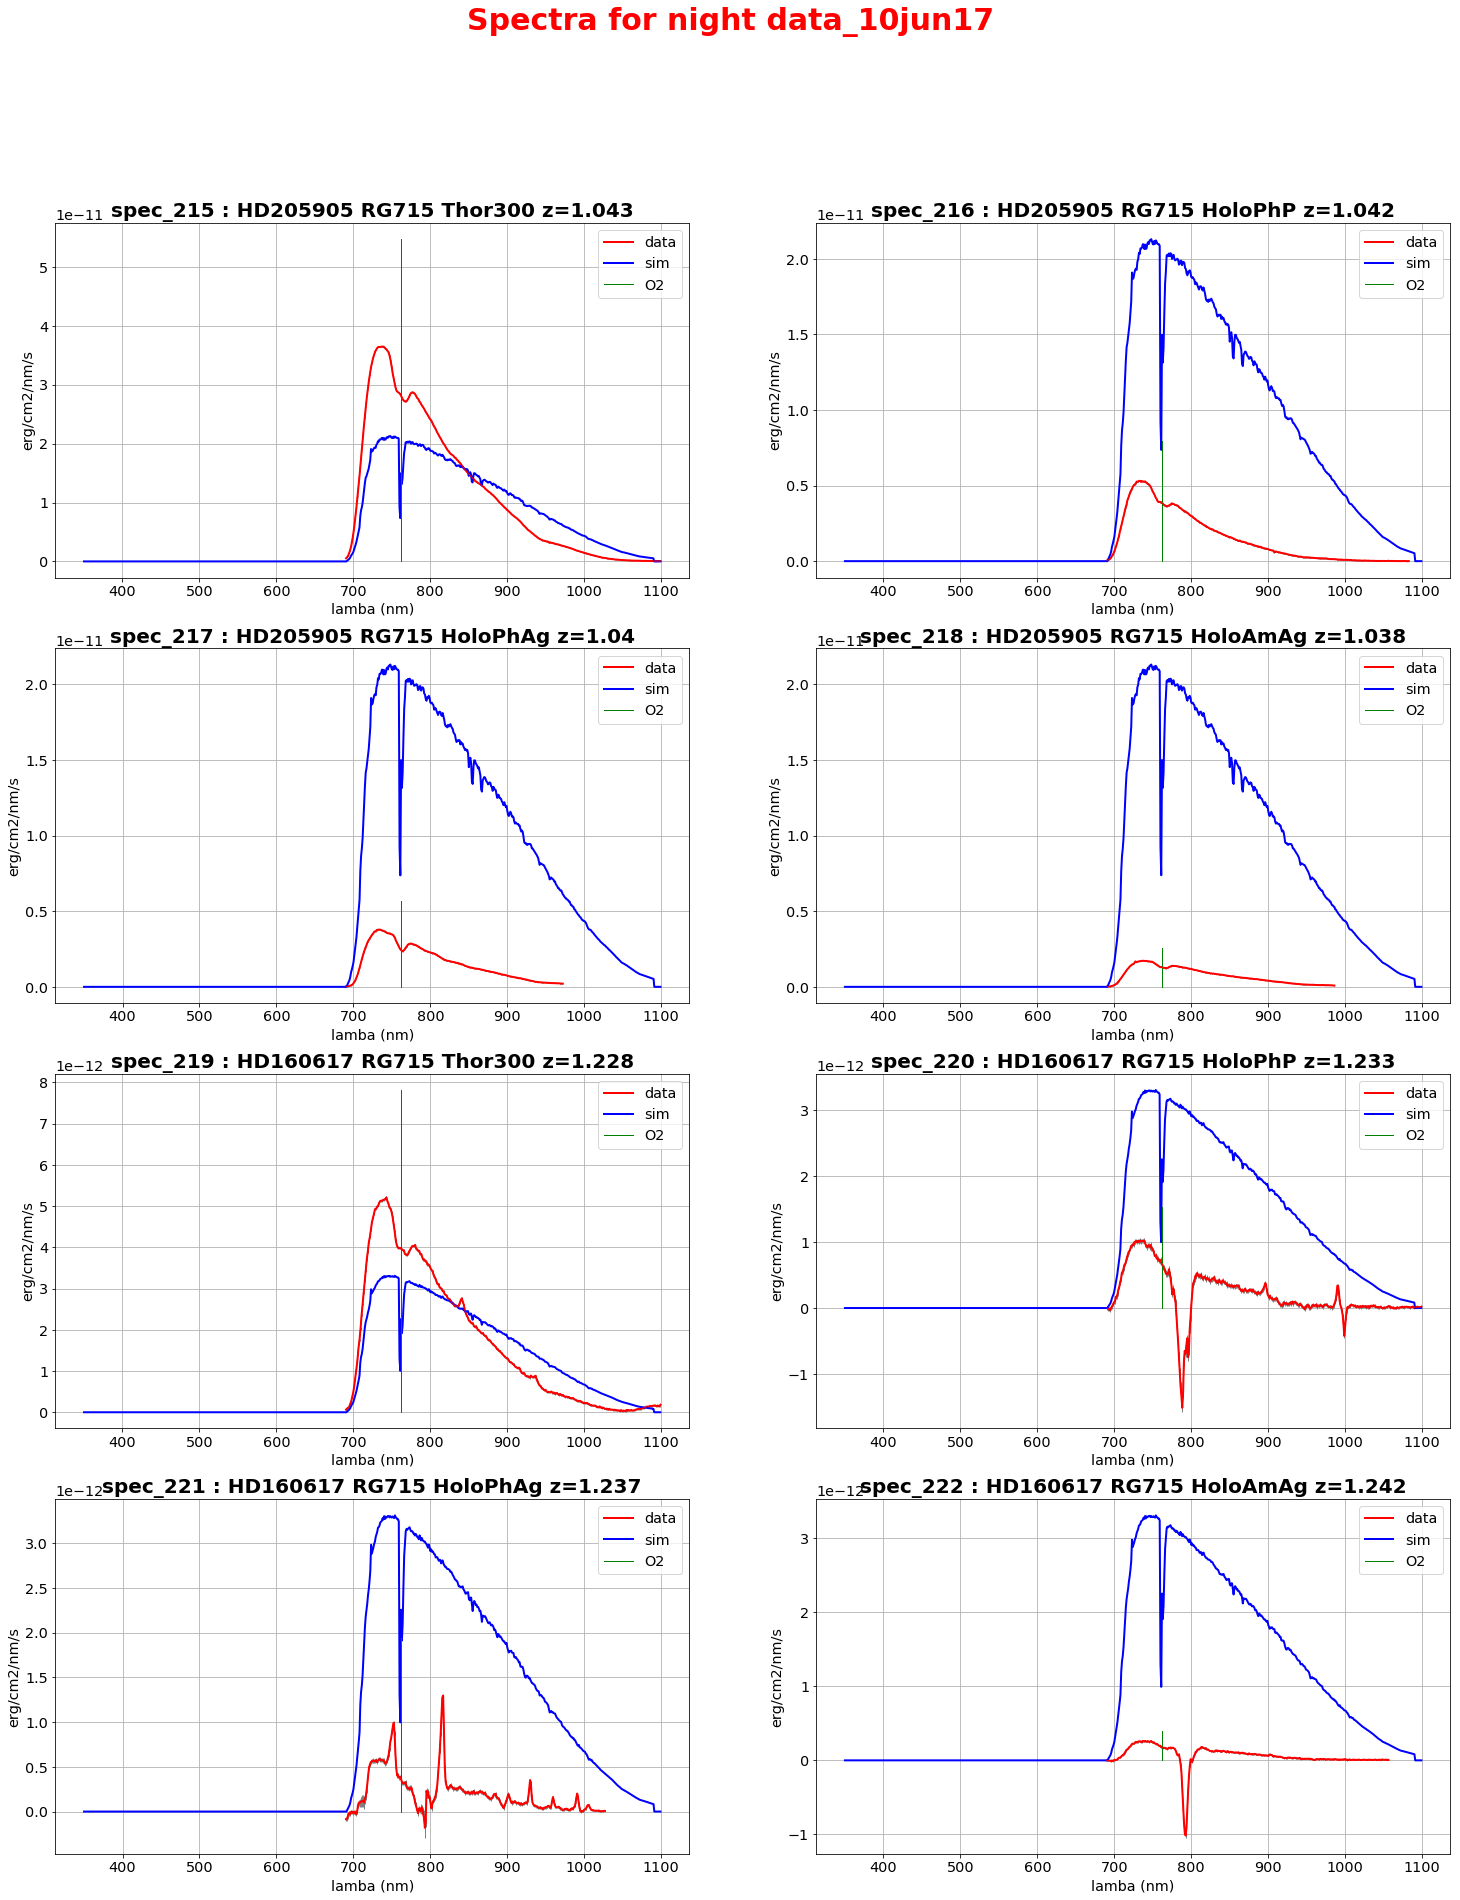

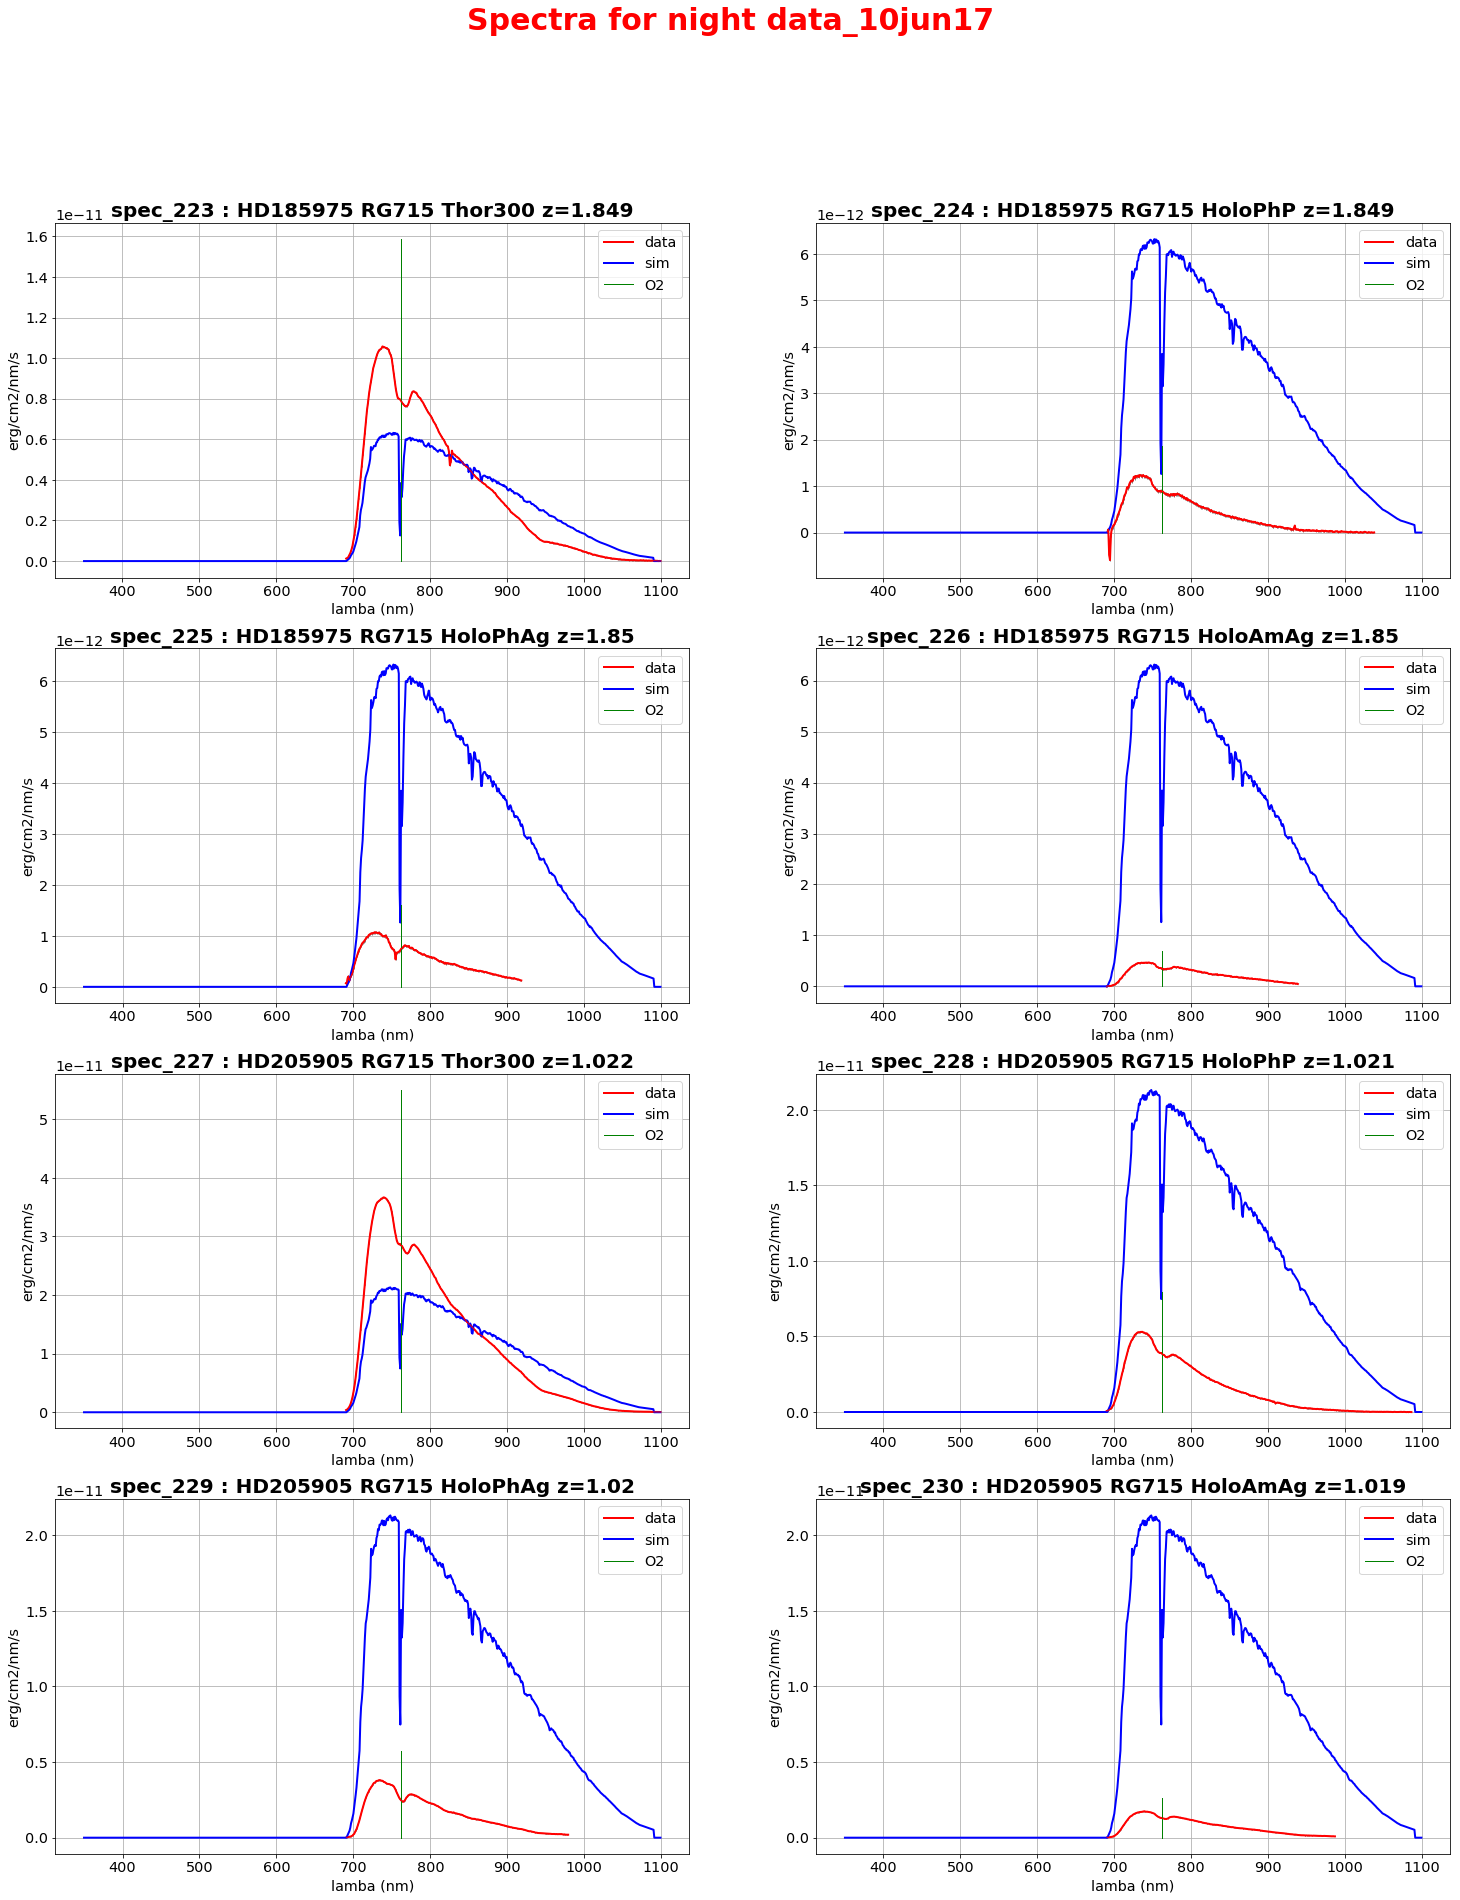

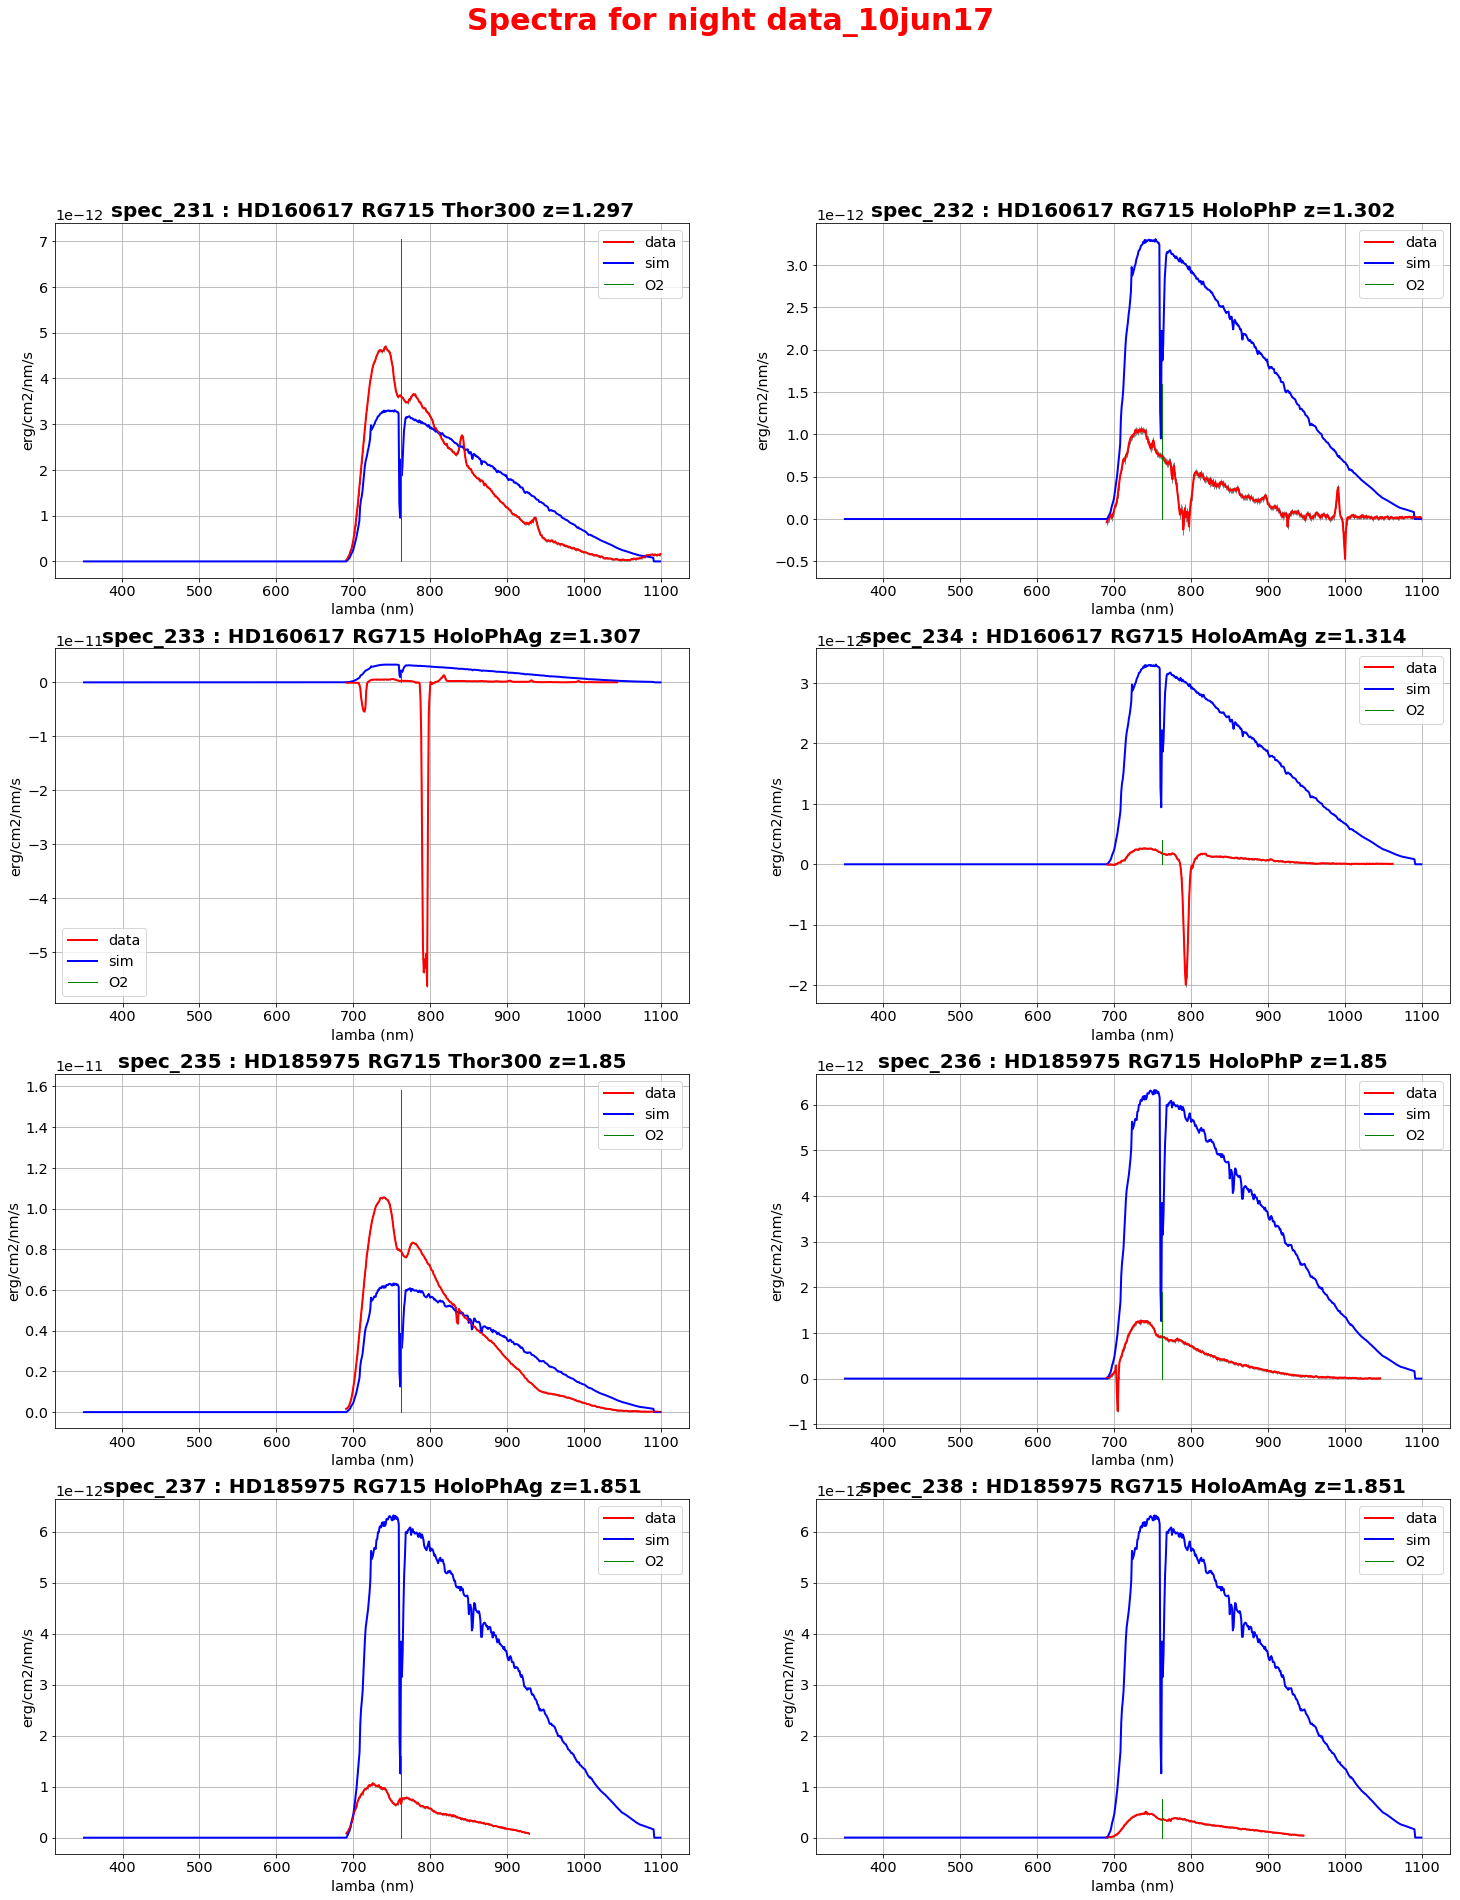

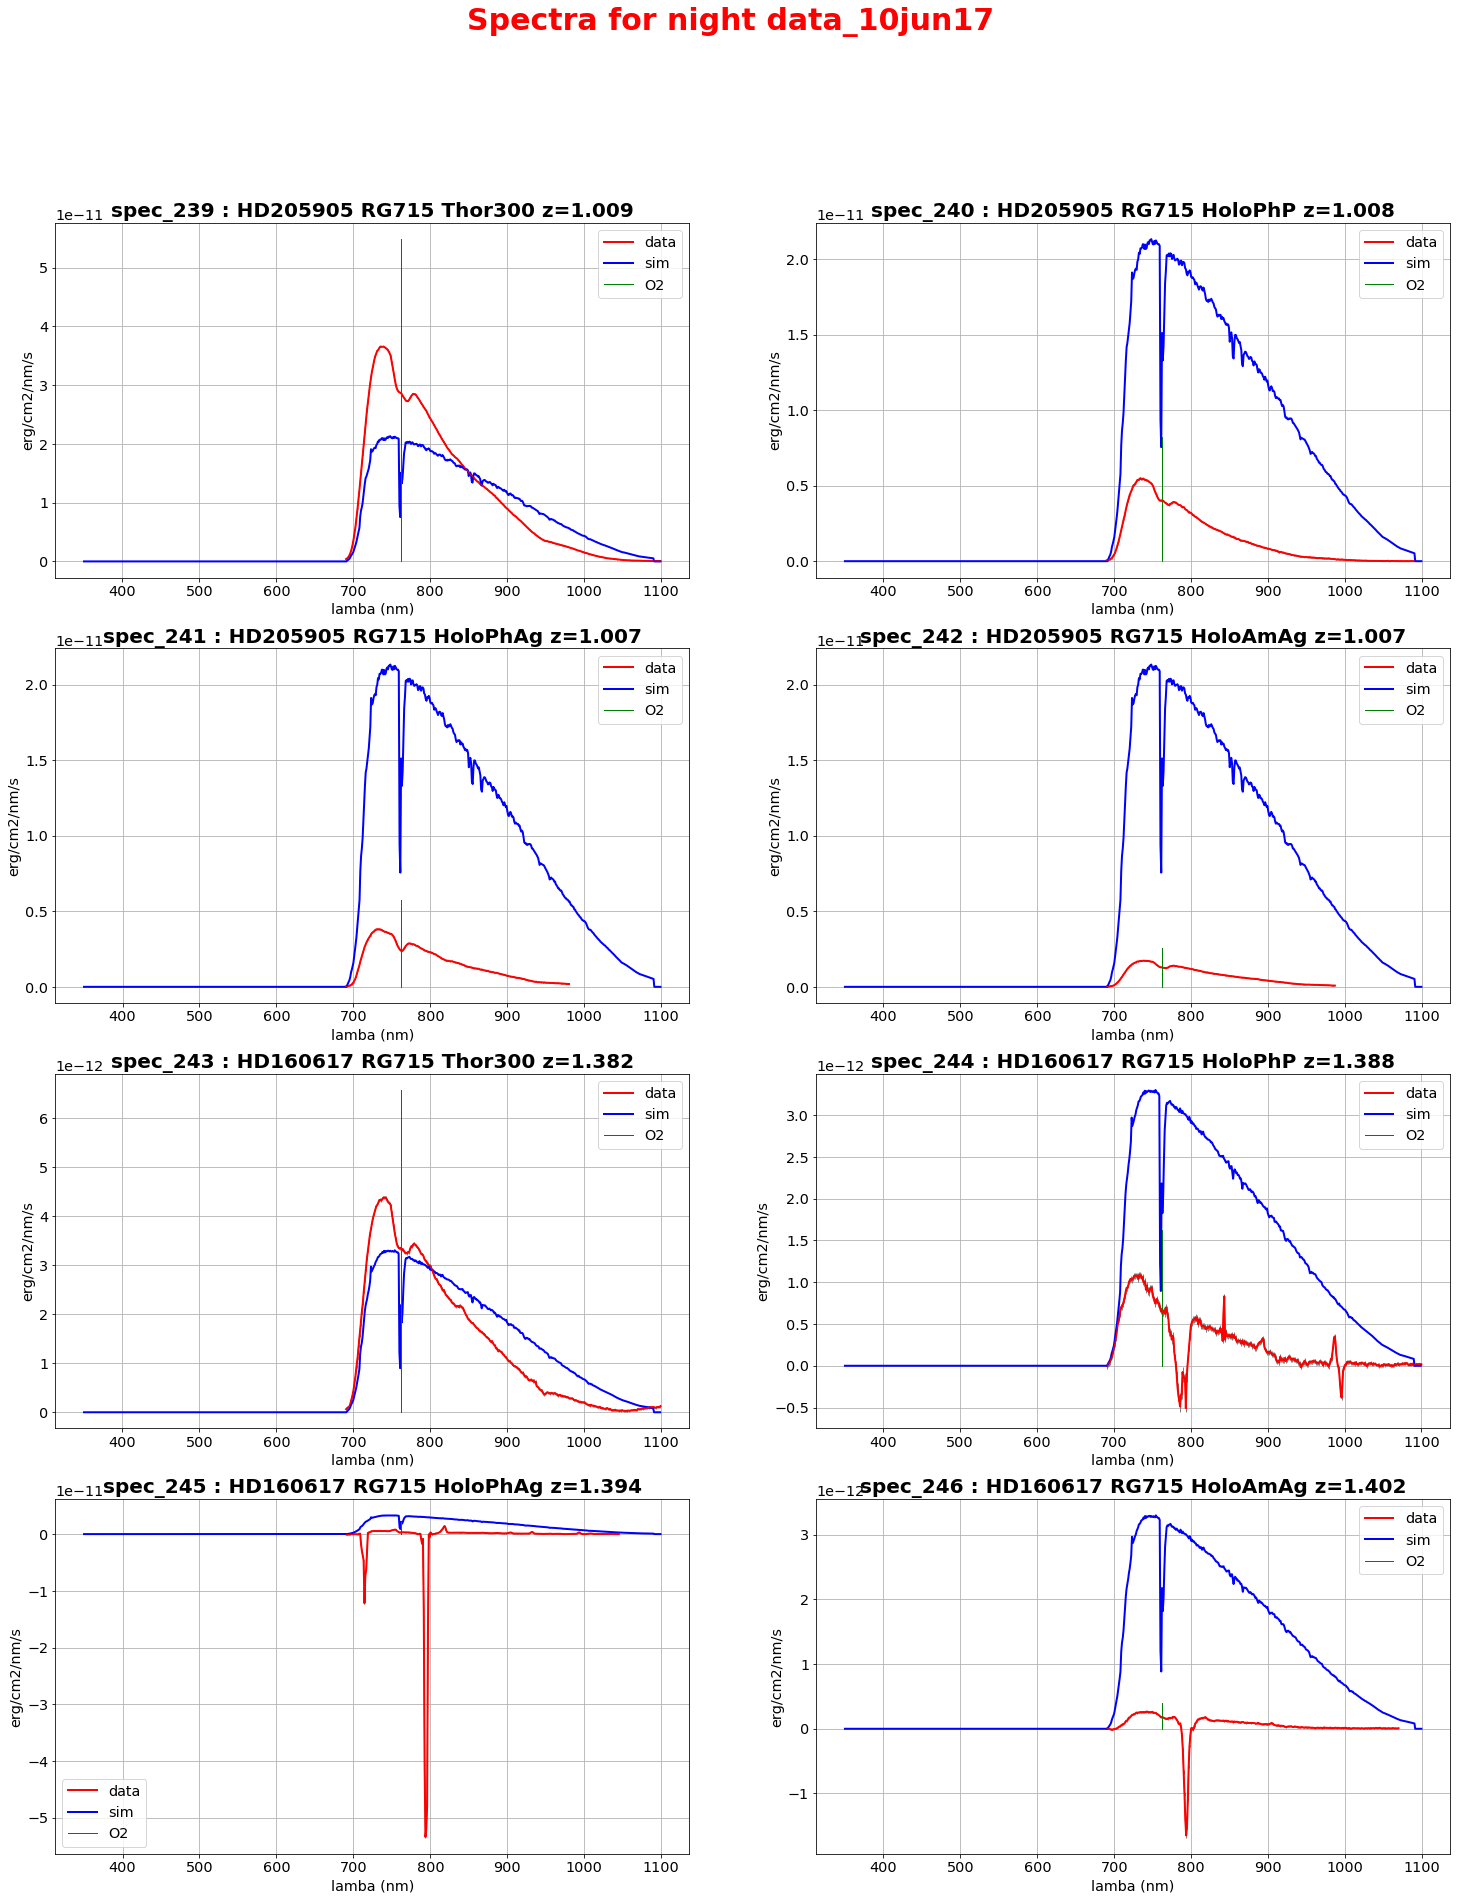

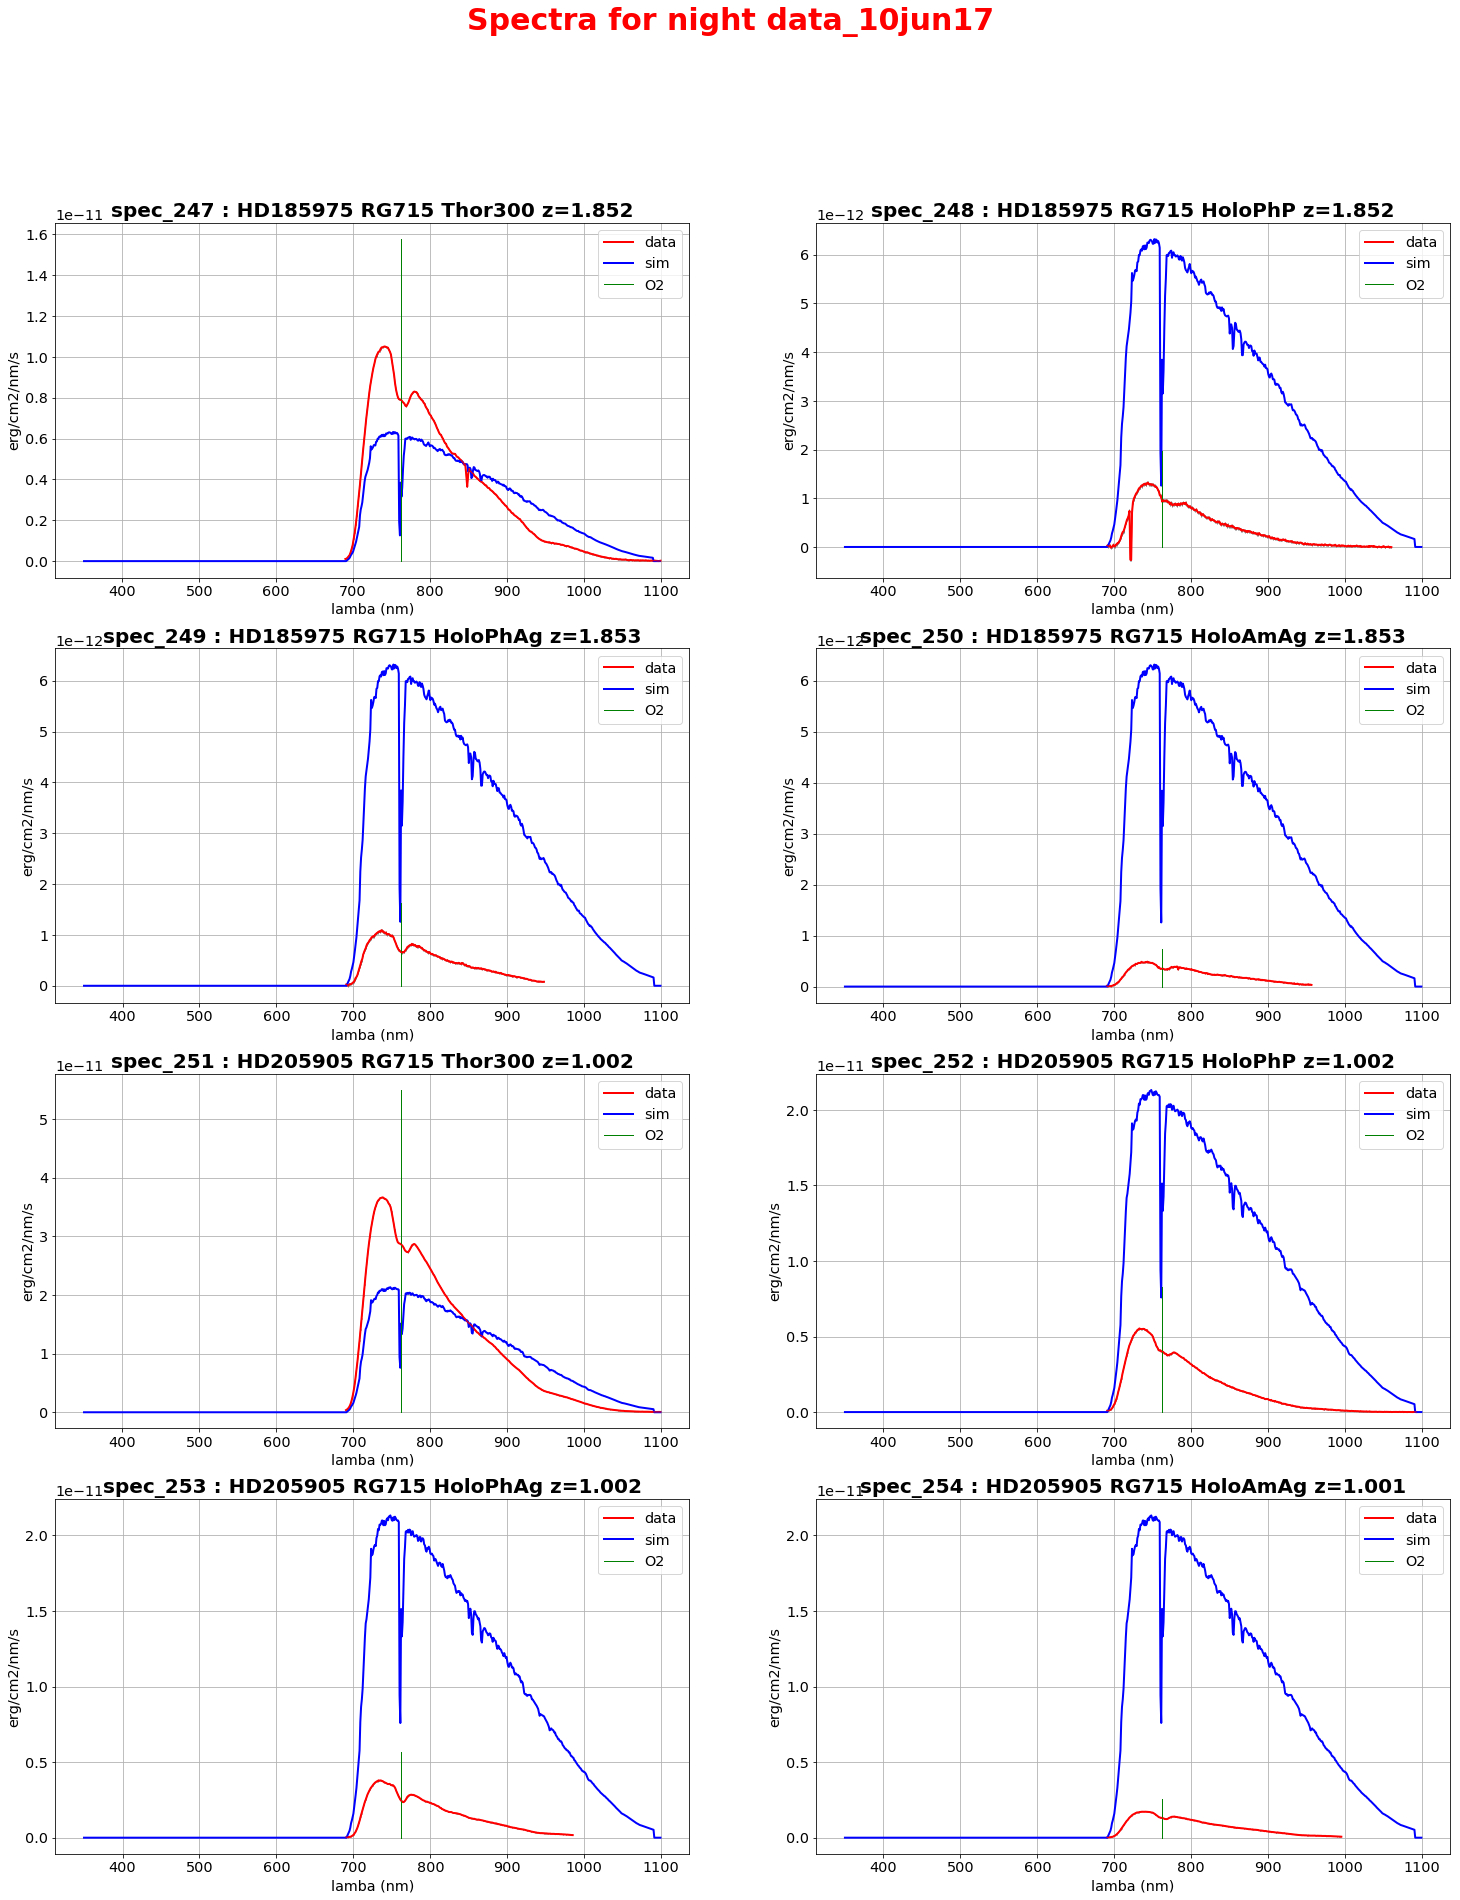

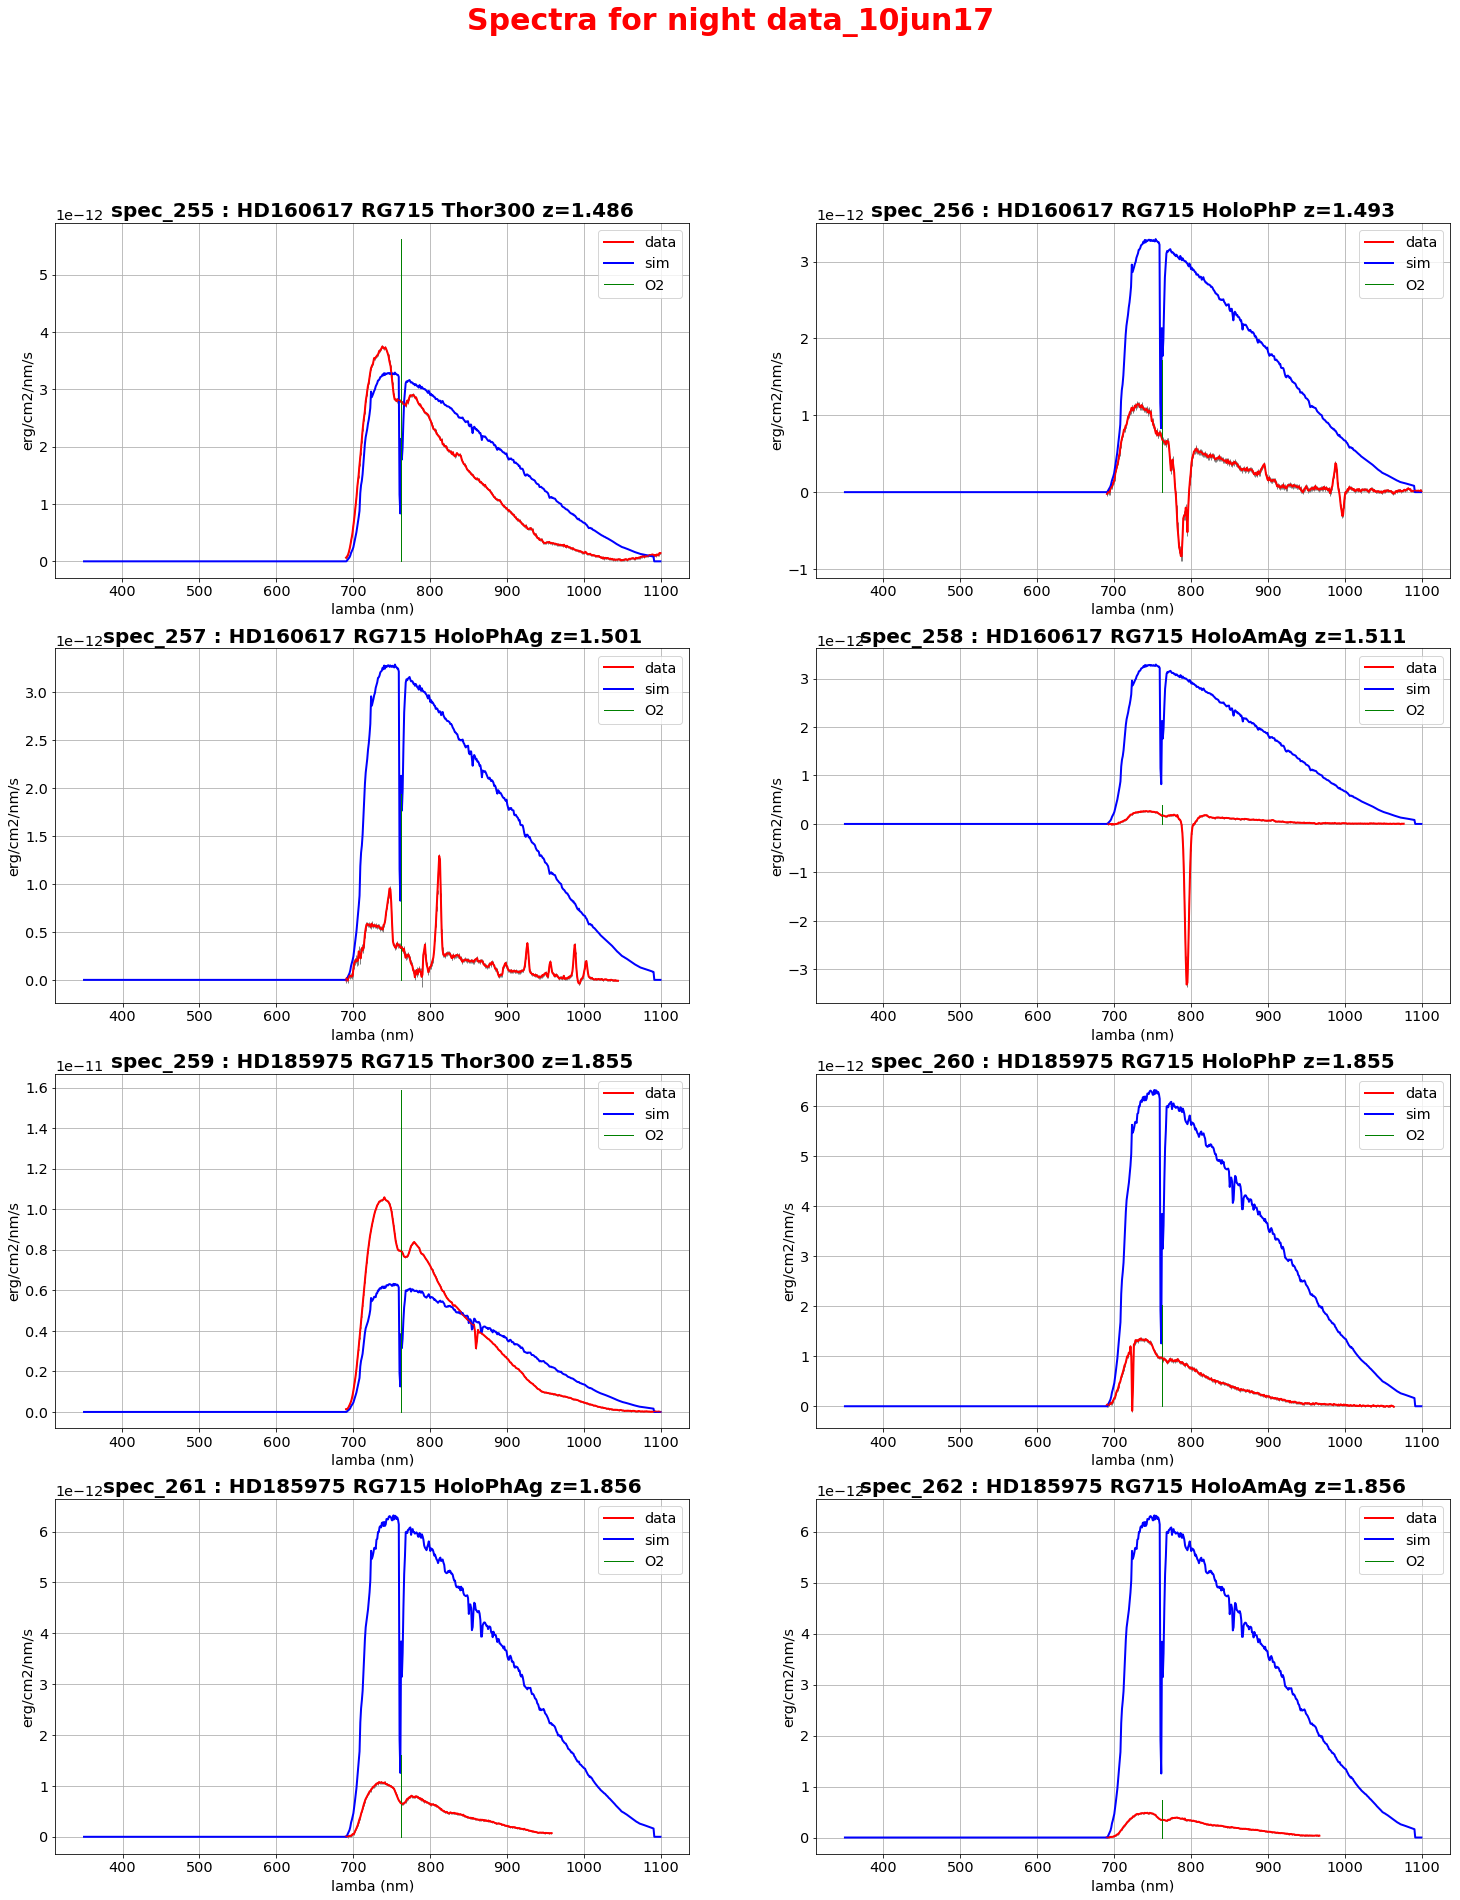

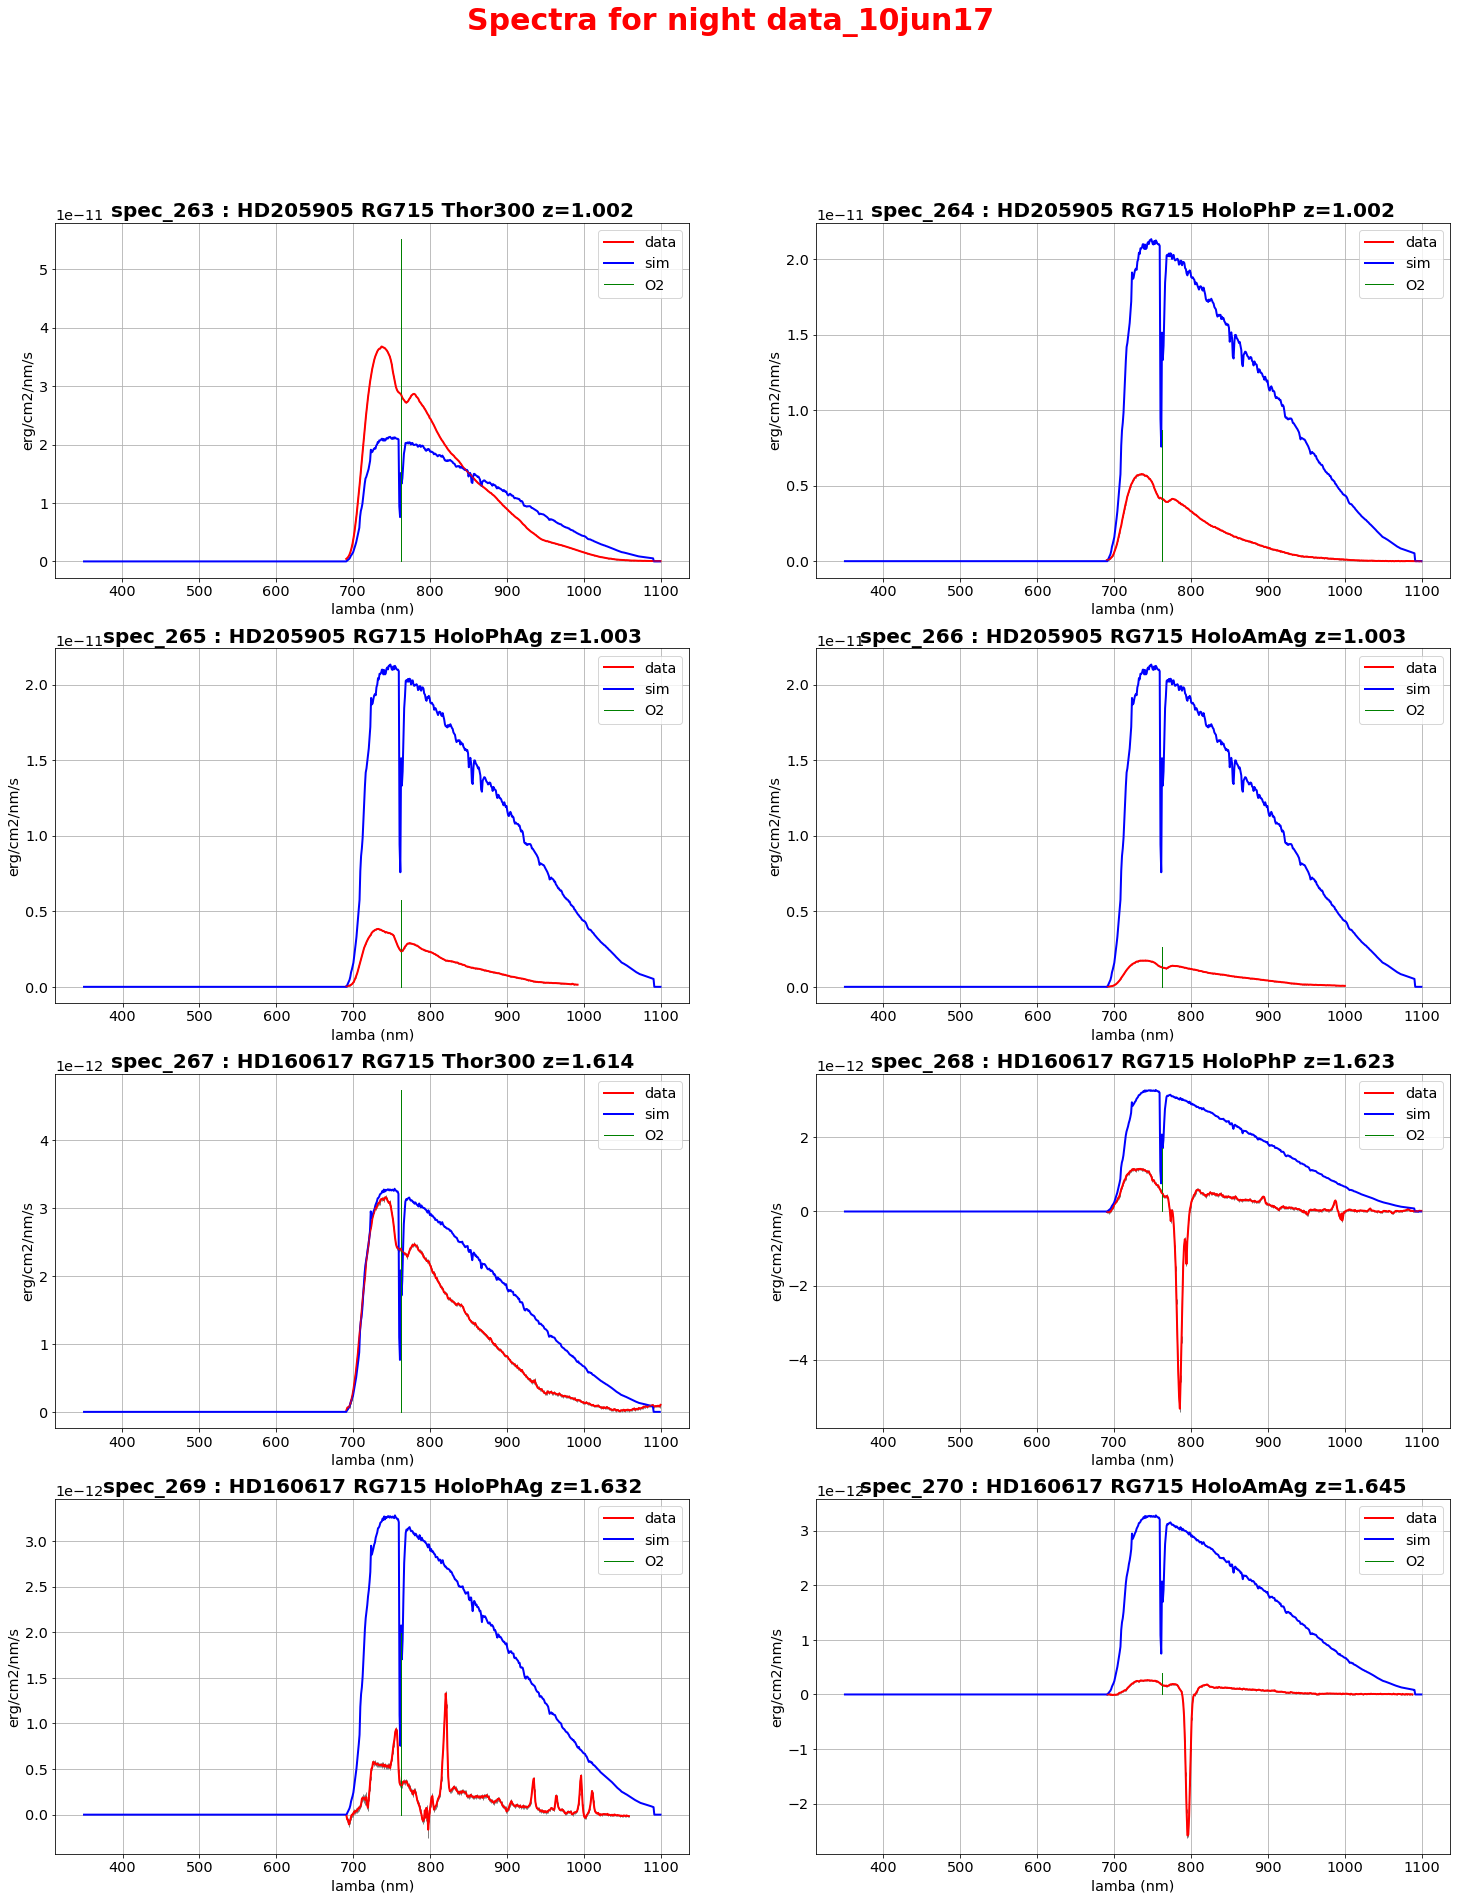

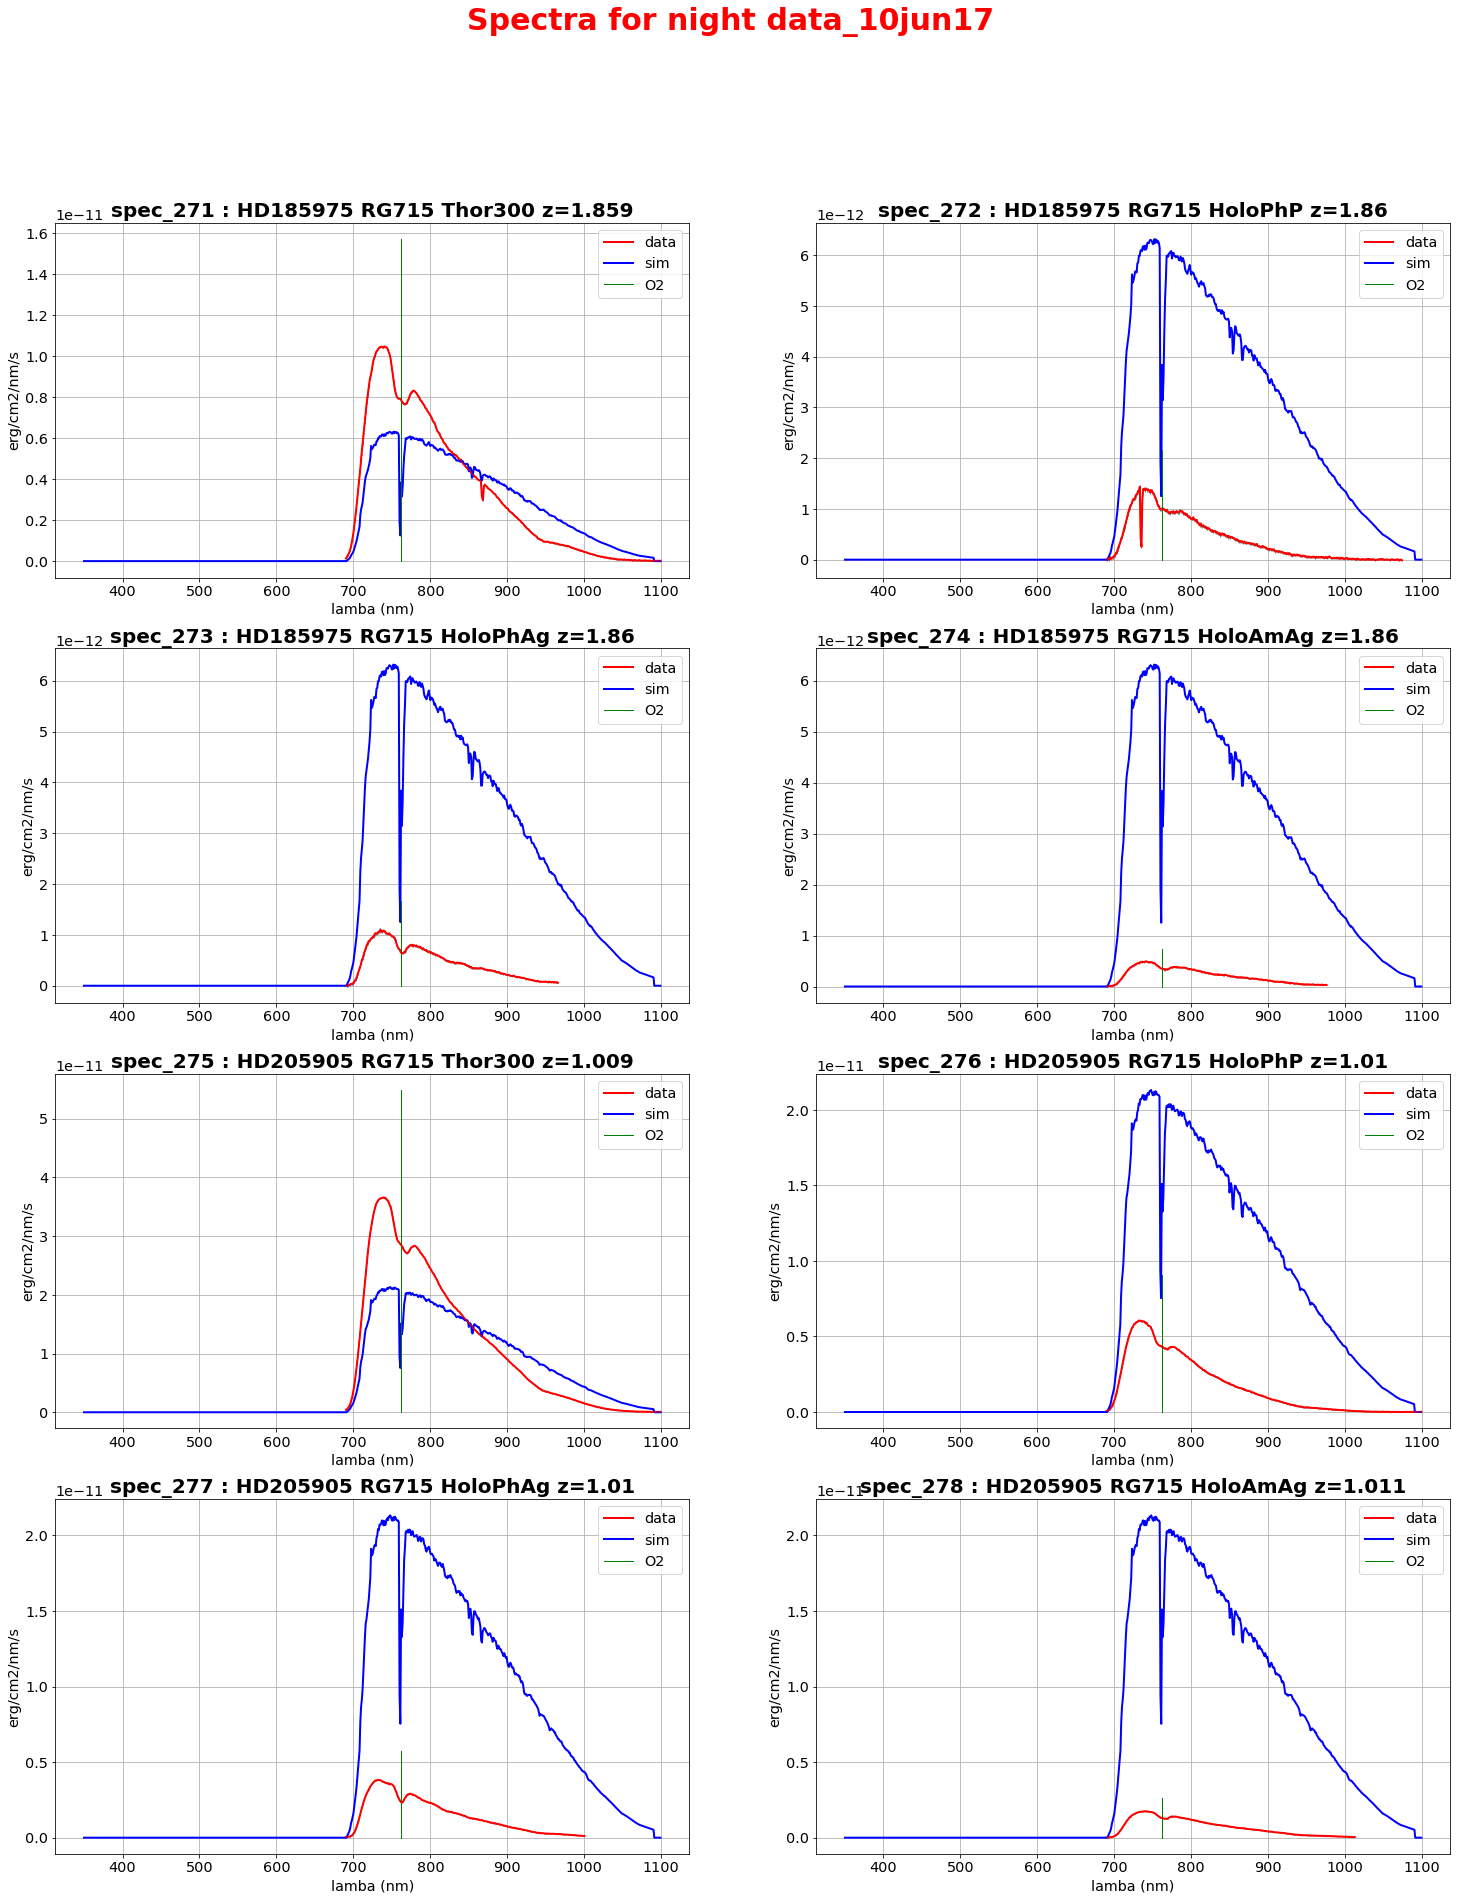

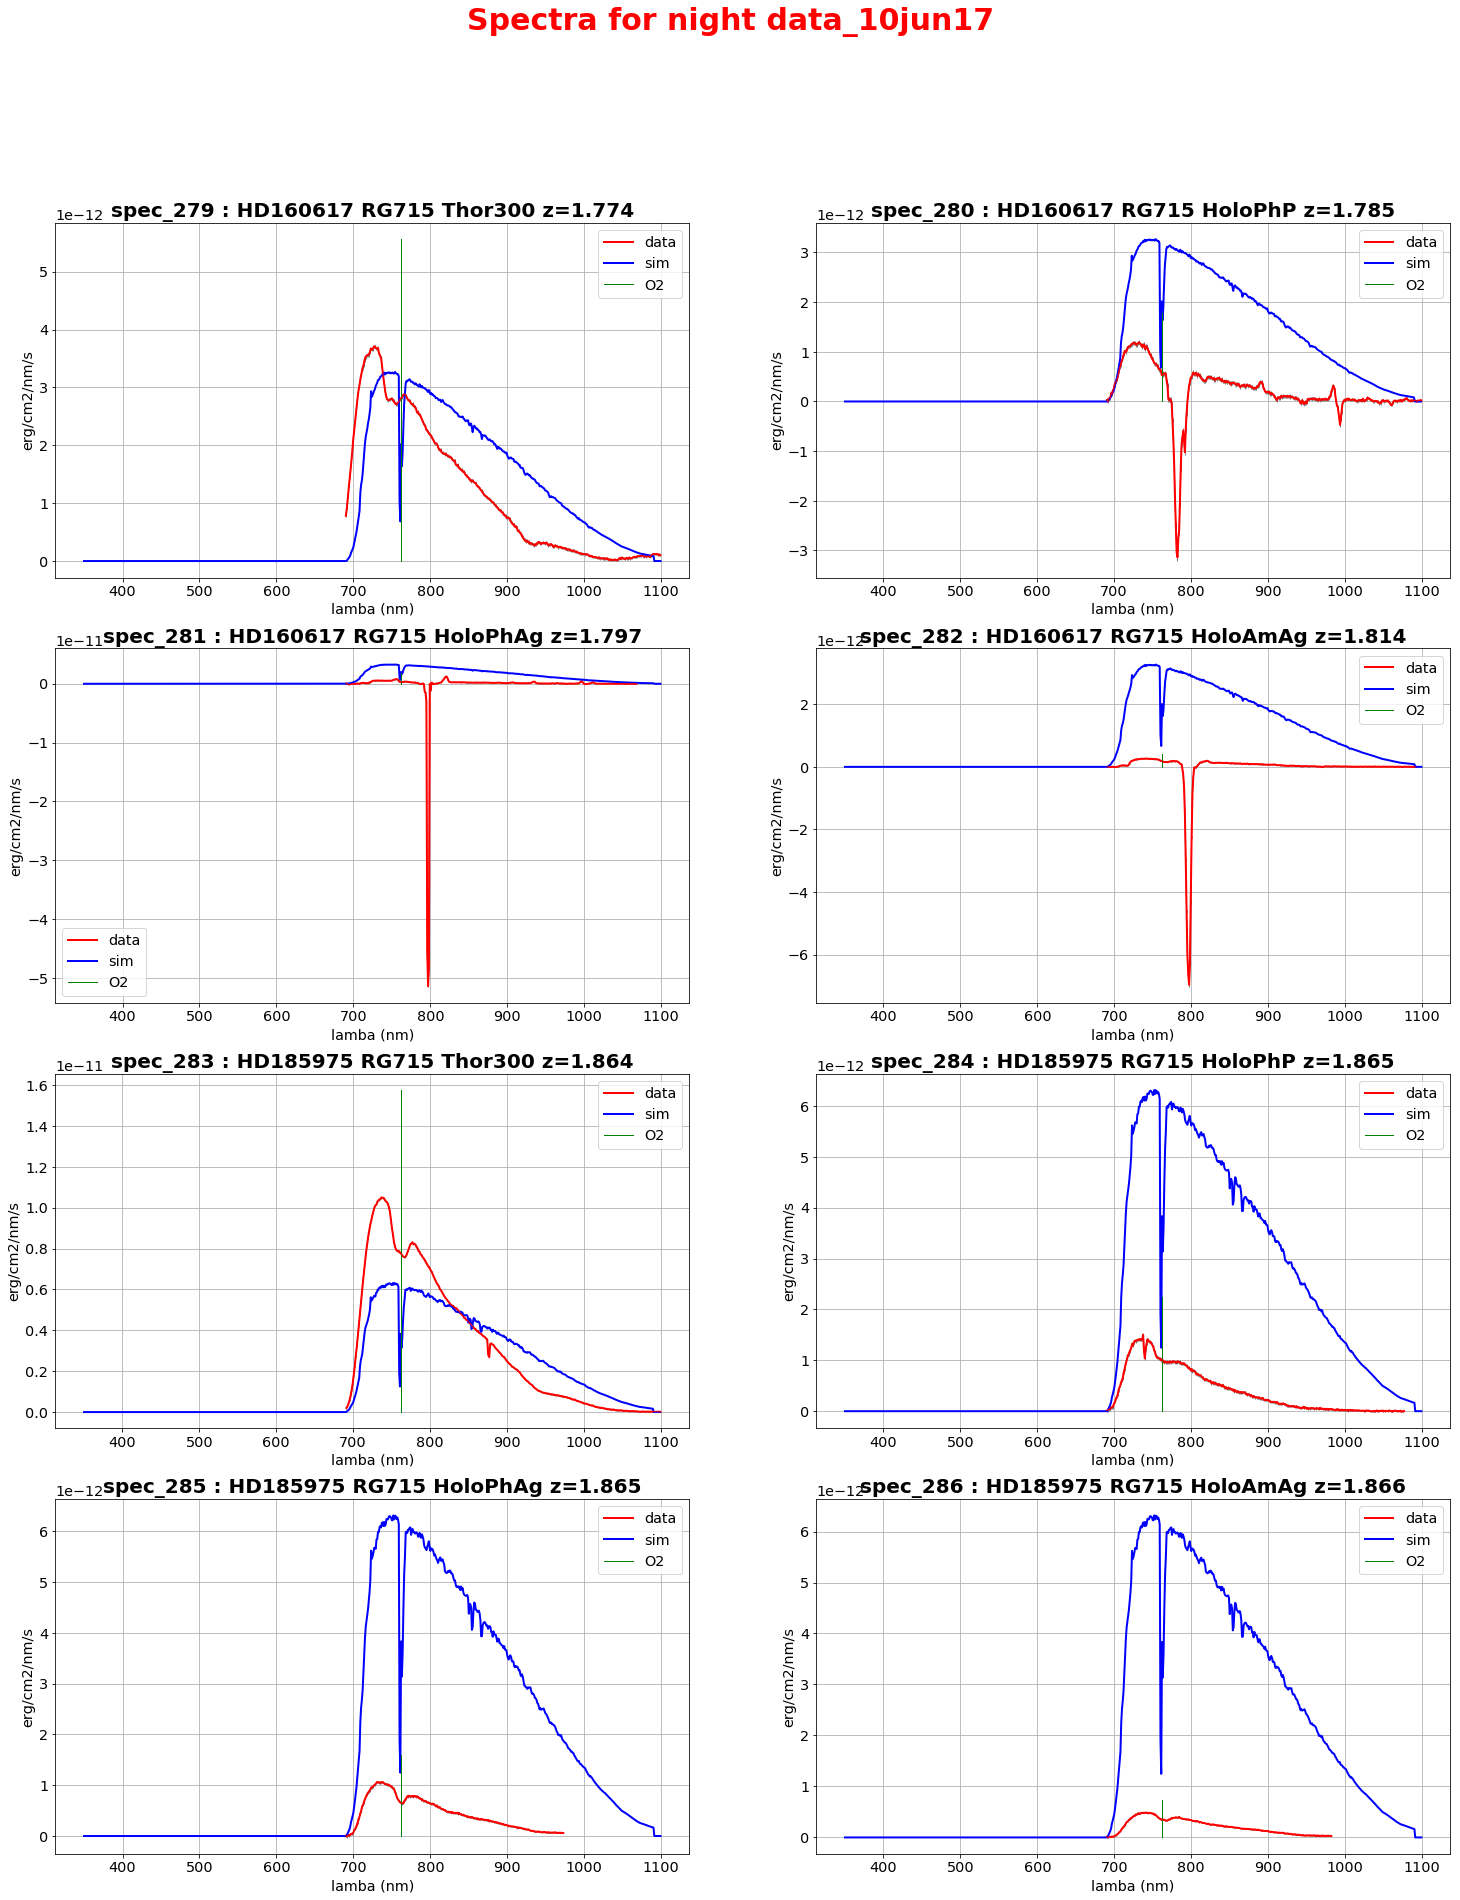

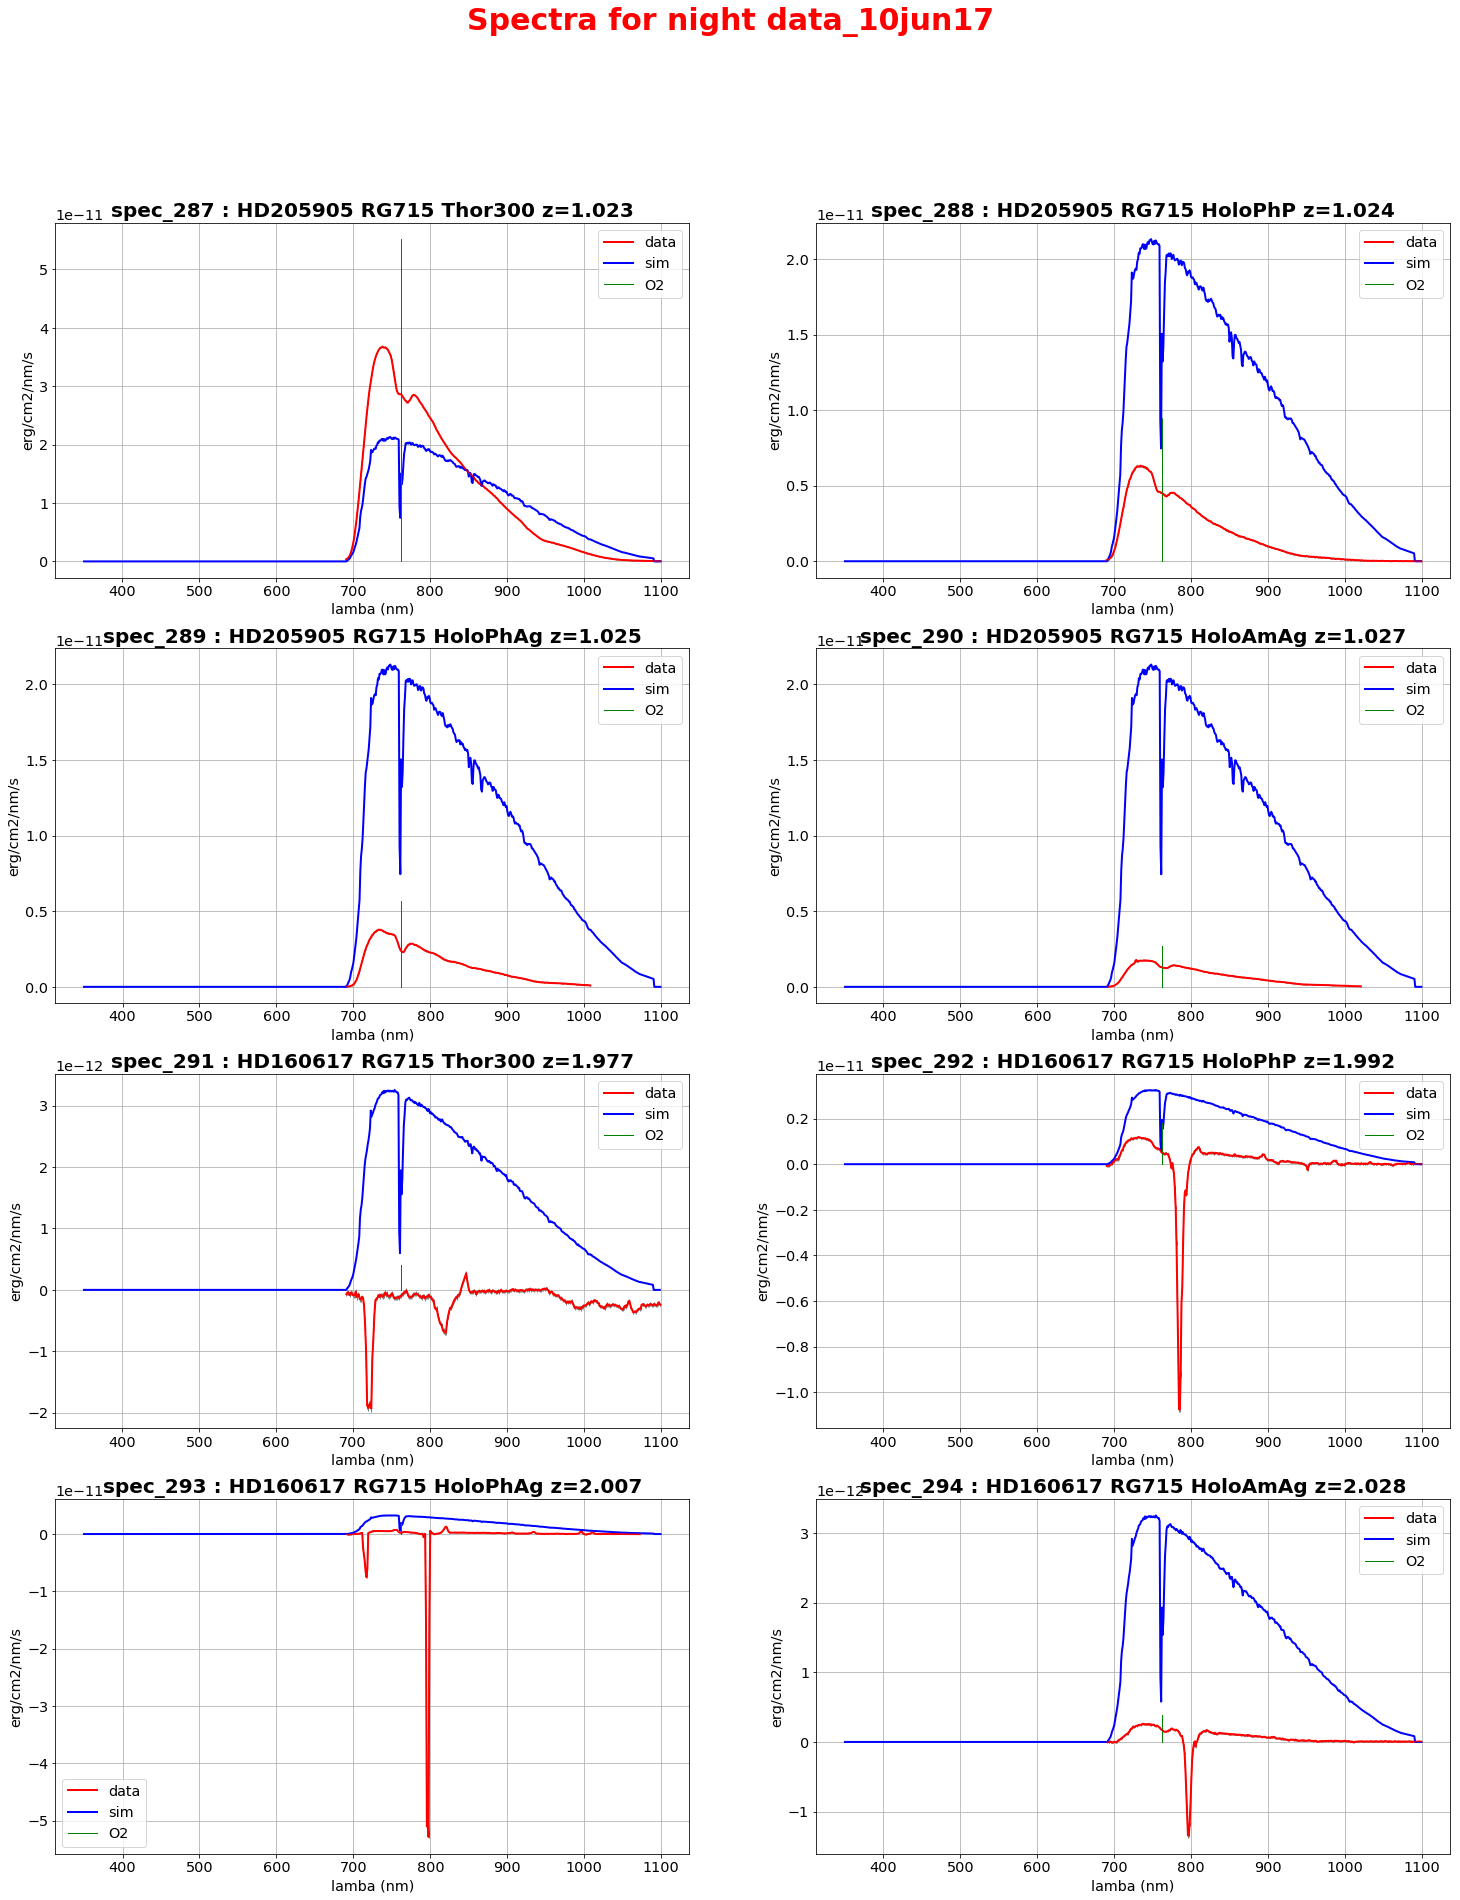

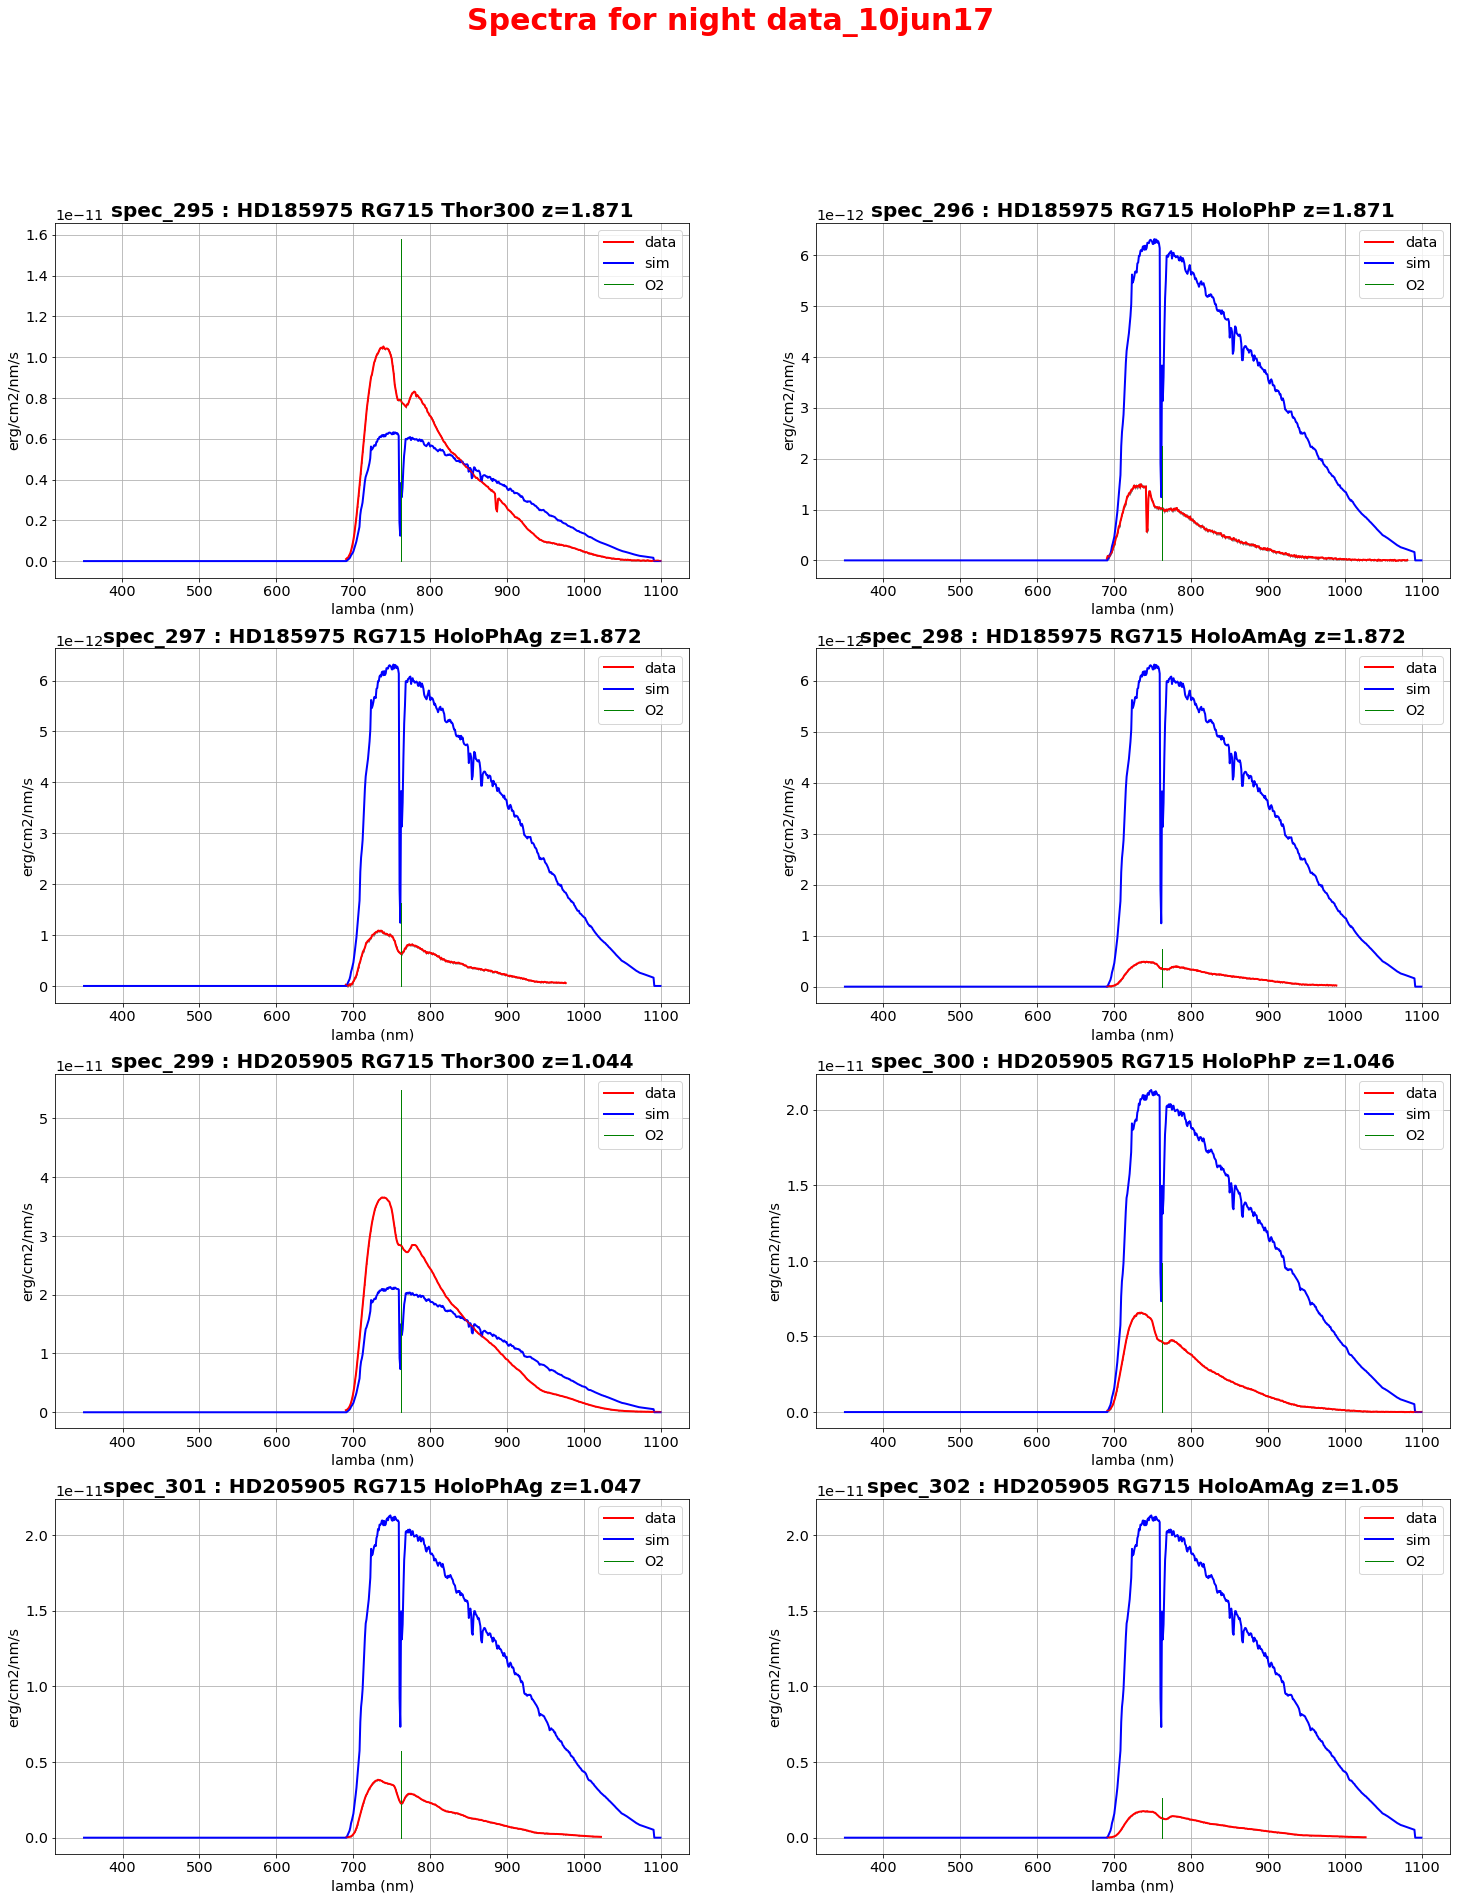

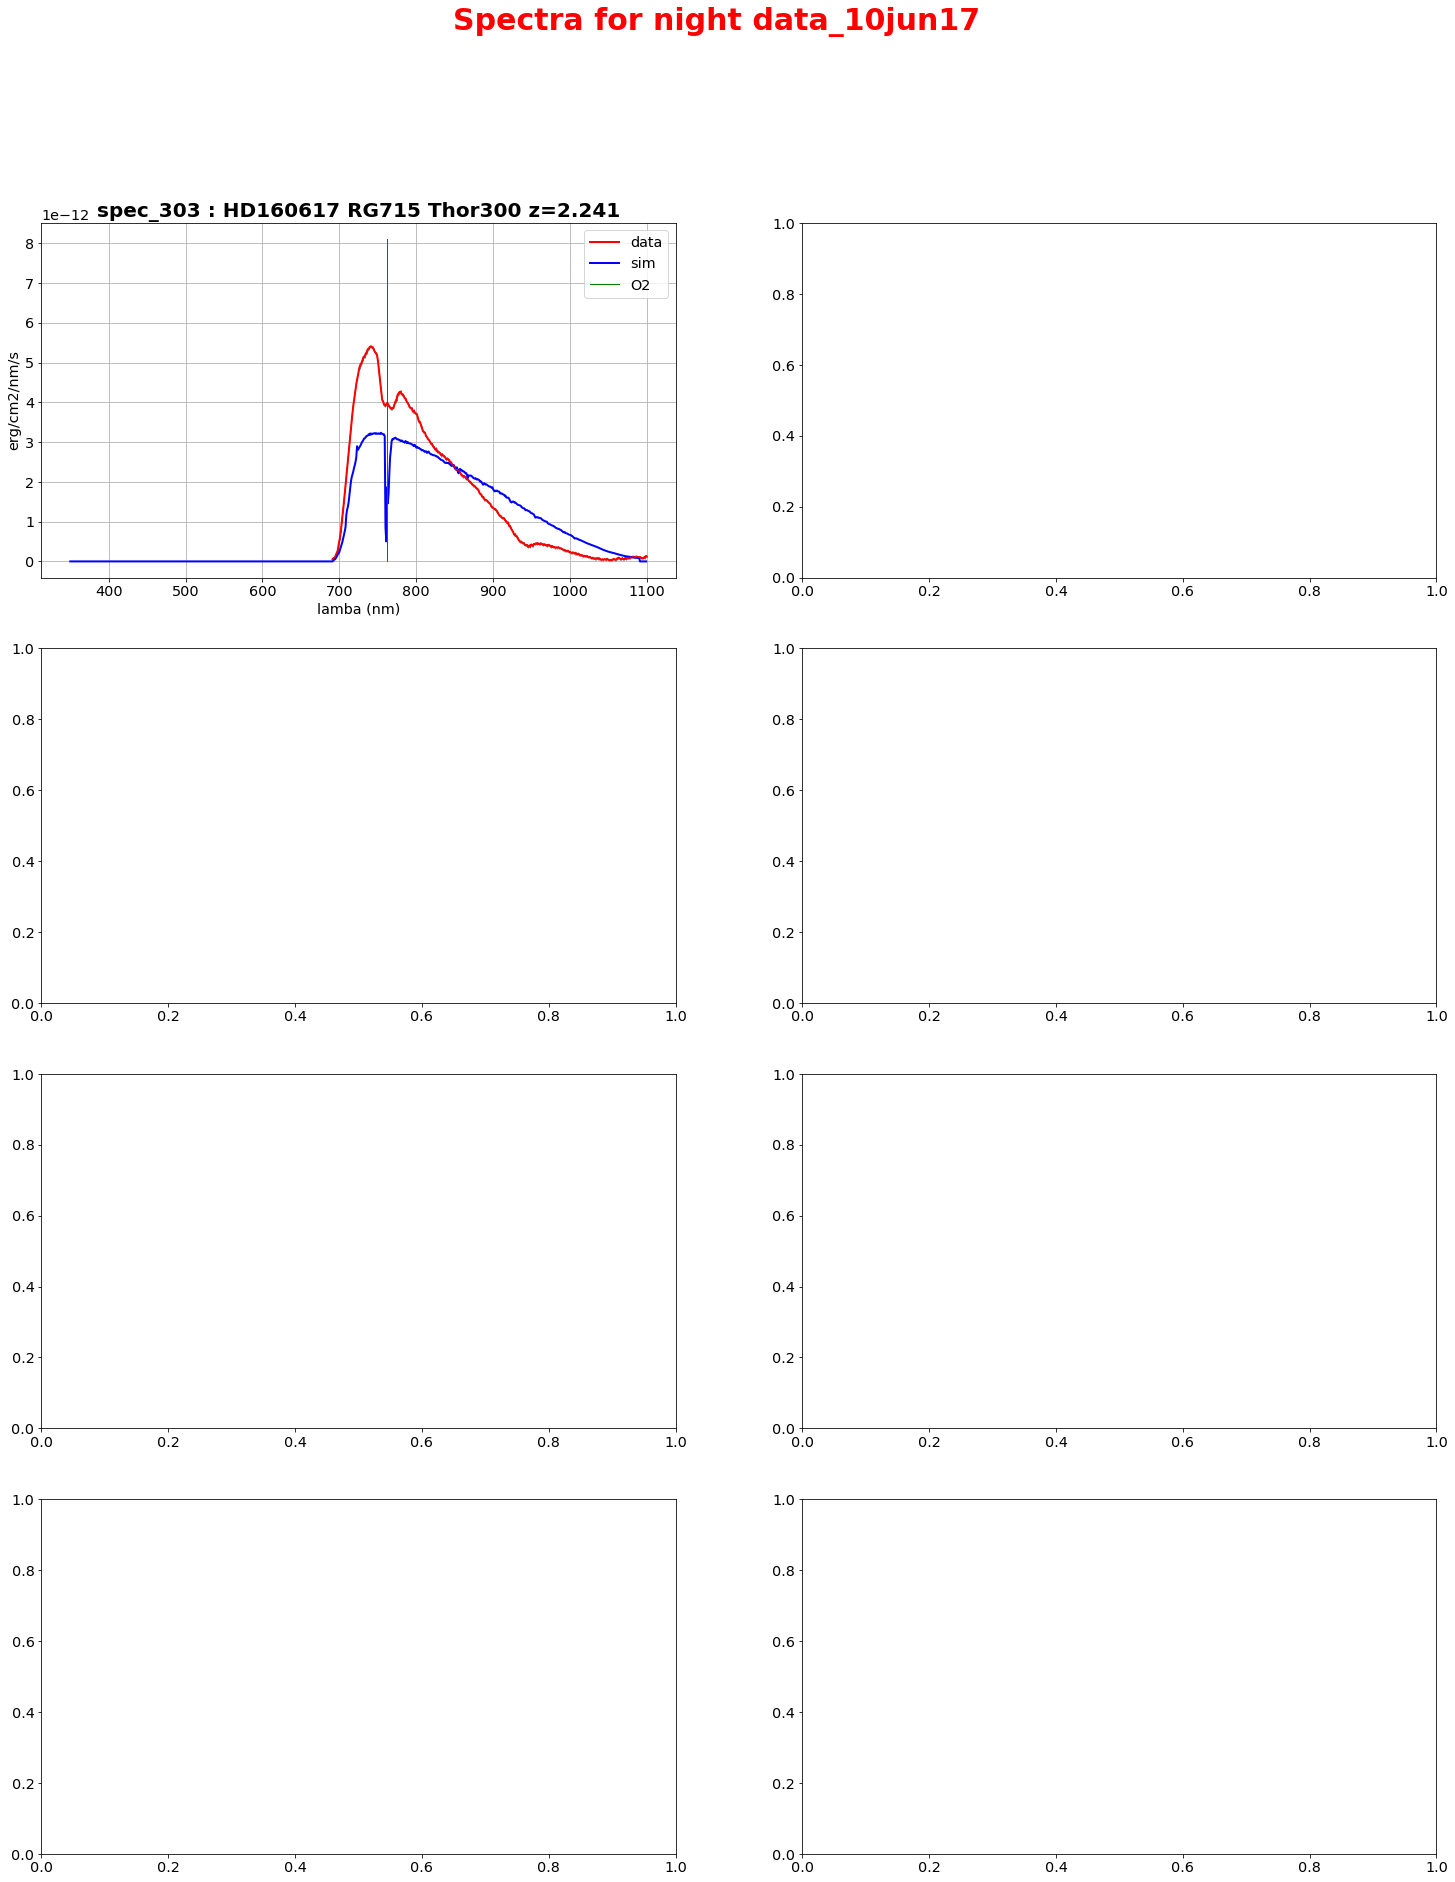

In [58]:


title='Spectra for night '+All_Subdirs[idx_sel_subdir]
PageNum=0          # page counter
NBIMGPERROW=2
NBIMGROWPERPAGE=4

# loop on plots
for idx in np.arange(NBPLOTS):
    
    
    if idx%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            f, axarr = plt.subplots(NBIMGROWPERPAGE,NBIMGPERROW,figsize=(25,30))
            f.suptitle(title,fontsize=30,fontweight='bold',color='red')
            
    # index of image in the page    
    index=idx-PageNum*(NBIMGROWPERPAGE*NBIMGPERROW)    
    ix=index%NBIMGPERROW
    iy=index/NBIMGPERROW
                        
    filename=all_spectrafiles[idx]
    simfilename=all_simspectrafiles1[idx]
    
    the_index=get_index_from_filename(filename,SelectTagRe)
    
    hdu1 = fits.open(filename)
    hdu2 = fits.open(simfilename)
       
    data1=hdu1[0].data
    wl1=data1[0]
    f1=data1[1]
    err1=data1[2]
   
    hdu2 = fits.open(simfilename)
    data2=hdu2[0].data
    
    wl2=data2[0]
    f2=data2[1]
    
    figtitle='spec_'+str(the_index)+' : ' + hdu1[0].header['TARGET']+' '+hdu1[0].header['FILTER1']+' '+hdu1[0].header['FILTER2']+' z='+str(hdu1[0].header['AIRMASS'])
    
    axarr[iy,ix].set_title(figtitle,fontsize='20',fontweight='bold')
    axarr[iy,ix].errorbar(wl1,f1,yerr=err1,color='red',ecolor='grey',lw=1)
    axarr[iy,ix].plot(wl1,f1,'r-',lw=2,label='data')
    axarr[iy,ix].plot(wl2,f2*1e-3,'b-',lw=2,label='sim')
    axarr[iy,ix].plot([O2WL,O2WL],[0.,f1.max()*1.5],'g-',lw=1,label='O2')
    axarr[iy,ix].set_xlabel("lamba (nm)")
    axarr[iy,ix].set_ylabel("erg/cm2/nm/s")
    axarr[iy,ix].grid(True)
    axarr[iy,ix].legend()
    #plt.show()    
    
    hdu1.close()
    hdu2.close()
   
    # save a new page
    if (idx+1)%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
        PageNum+=1  # increase page Number
        f.show()
        
        
    #idx+=1    # increase counter on plots
     

f.show()

## Plot of spectra in a pdf file

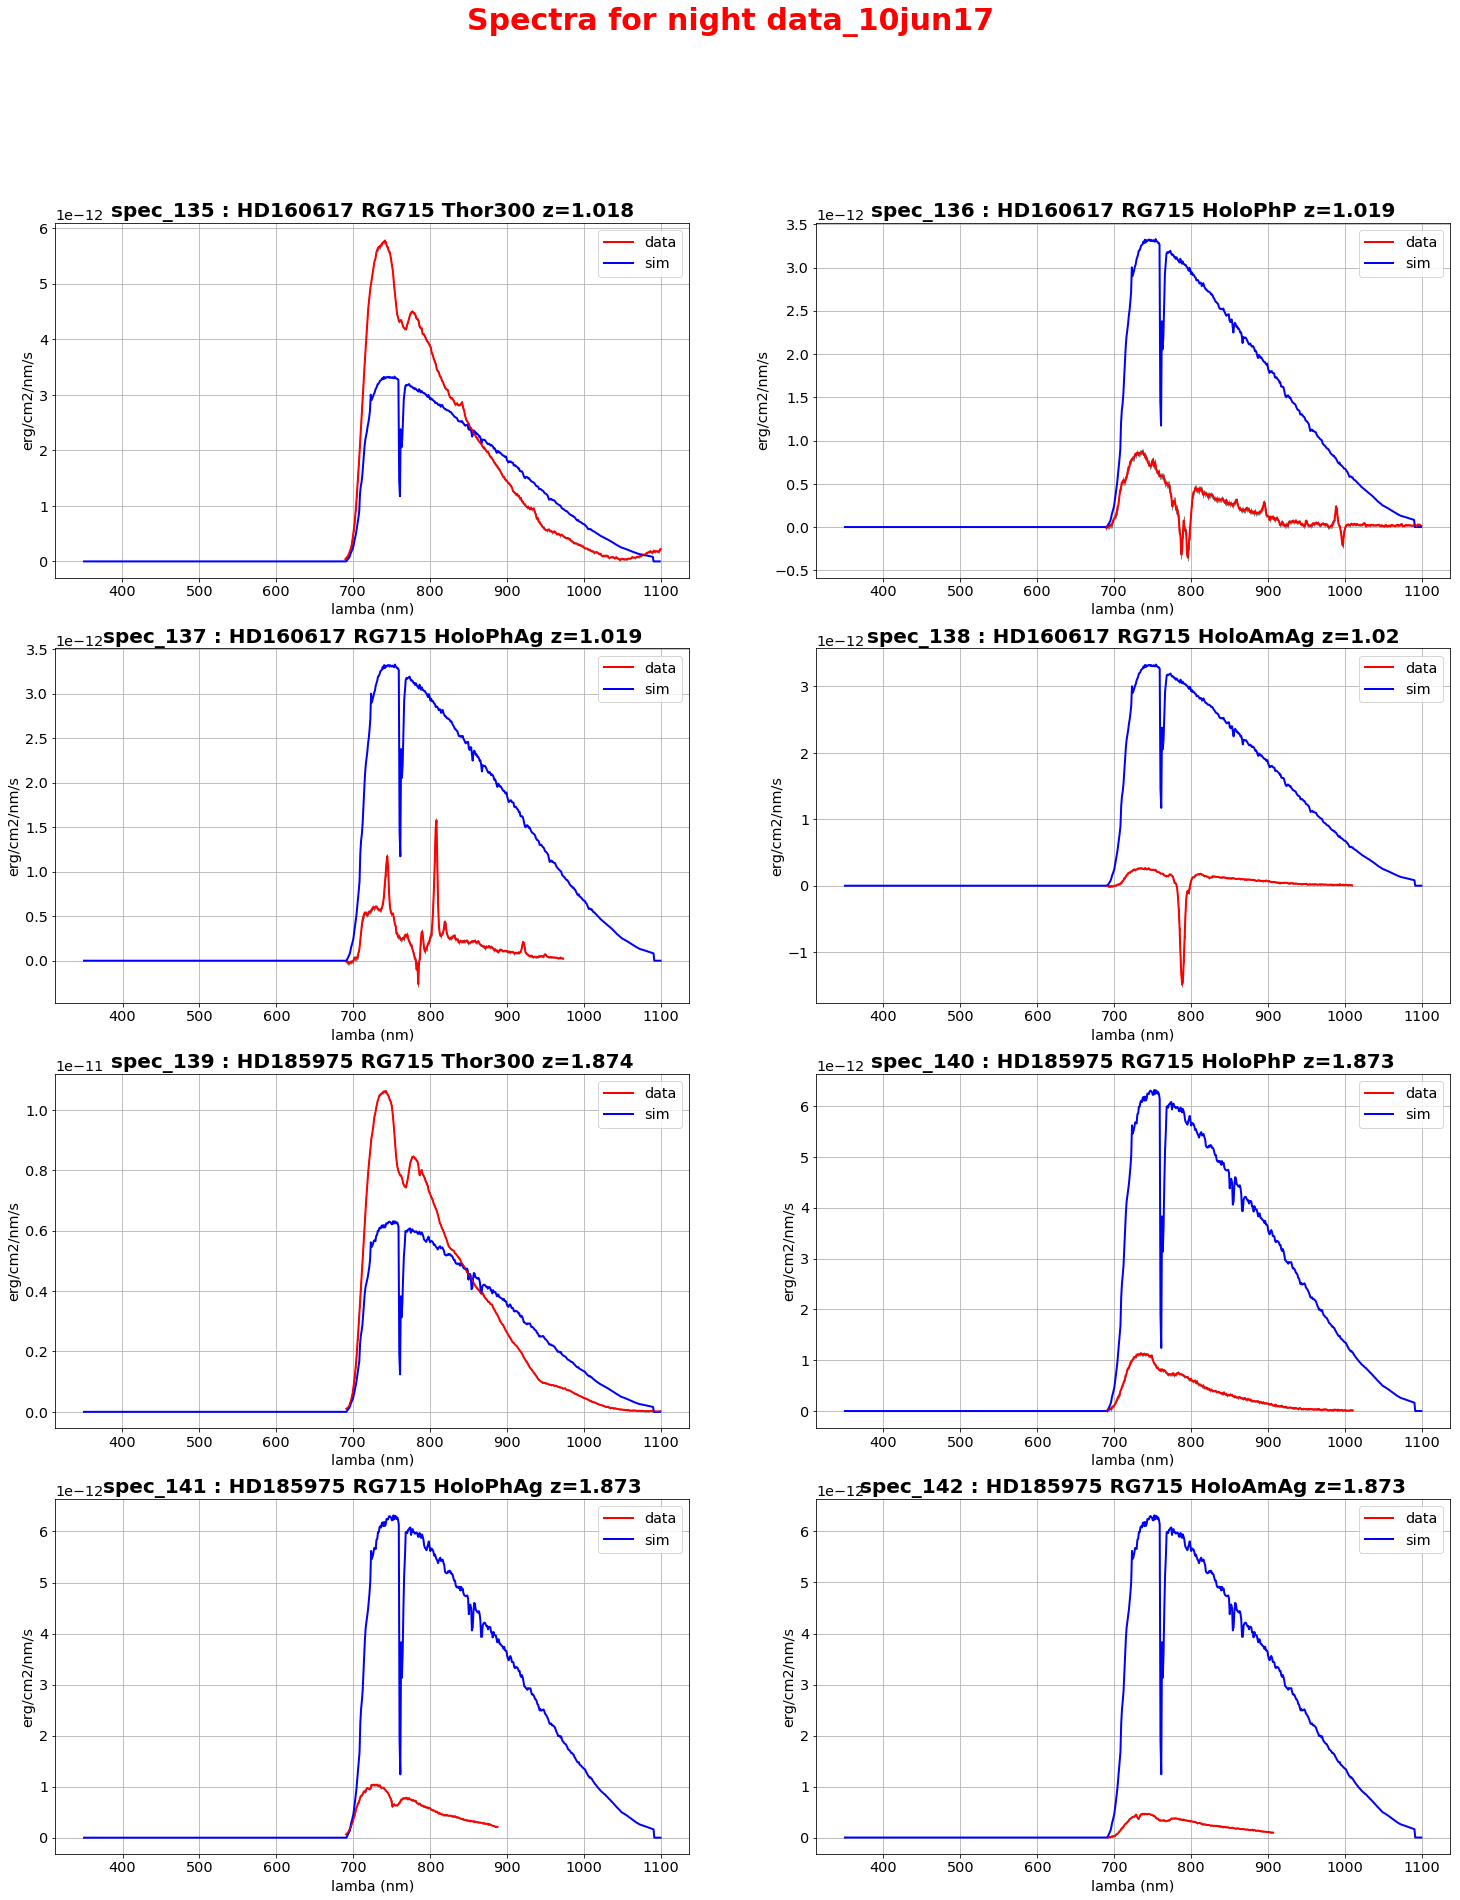

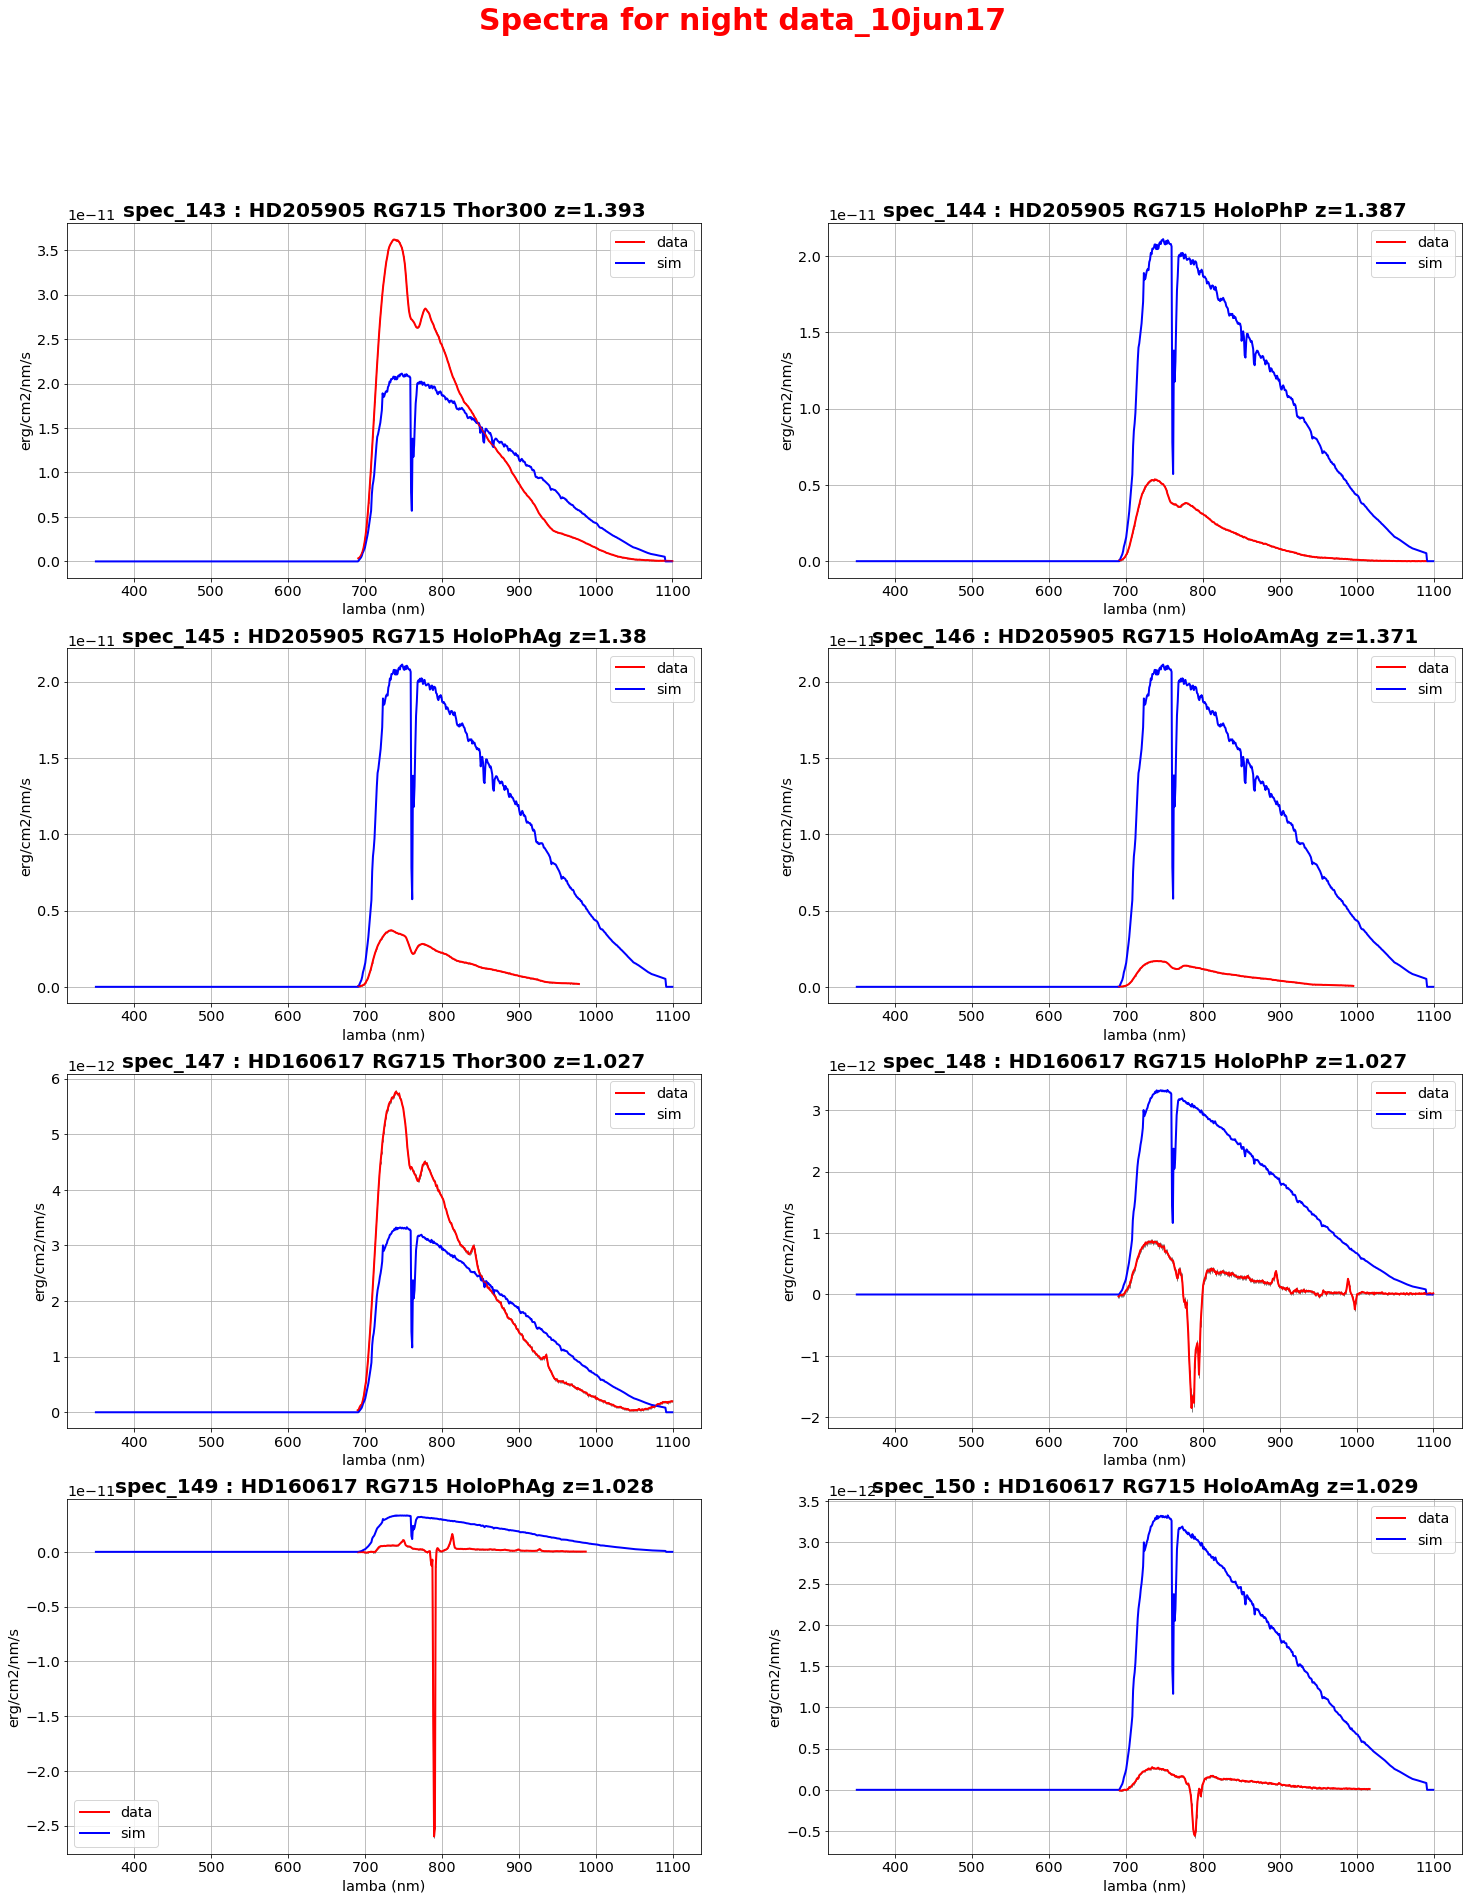

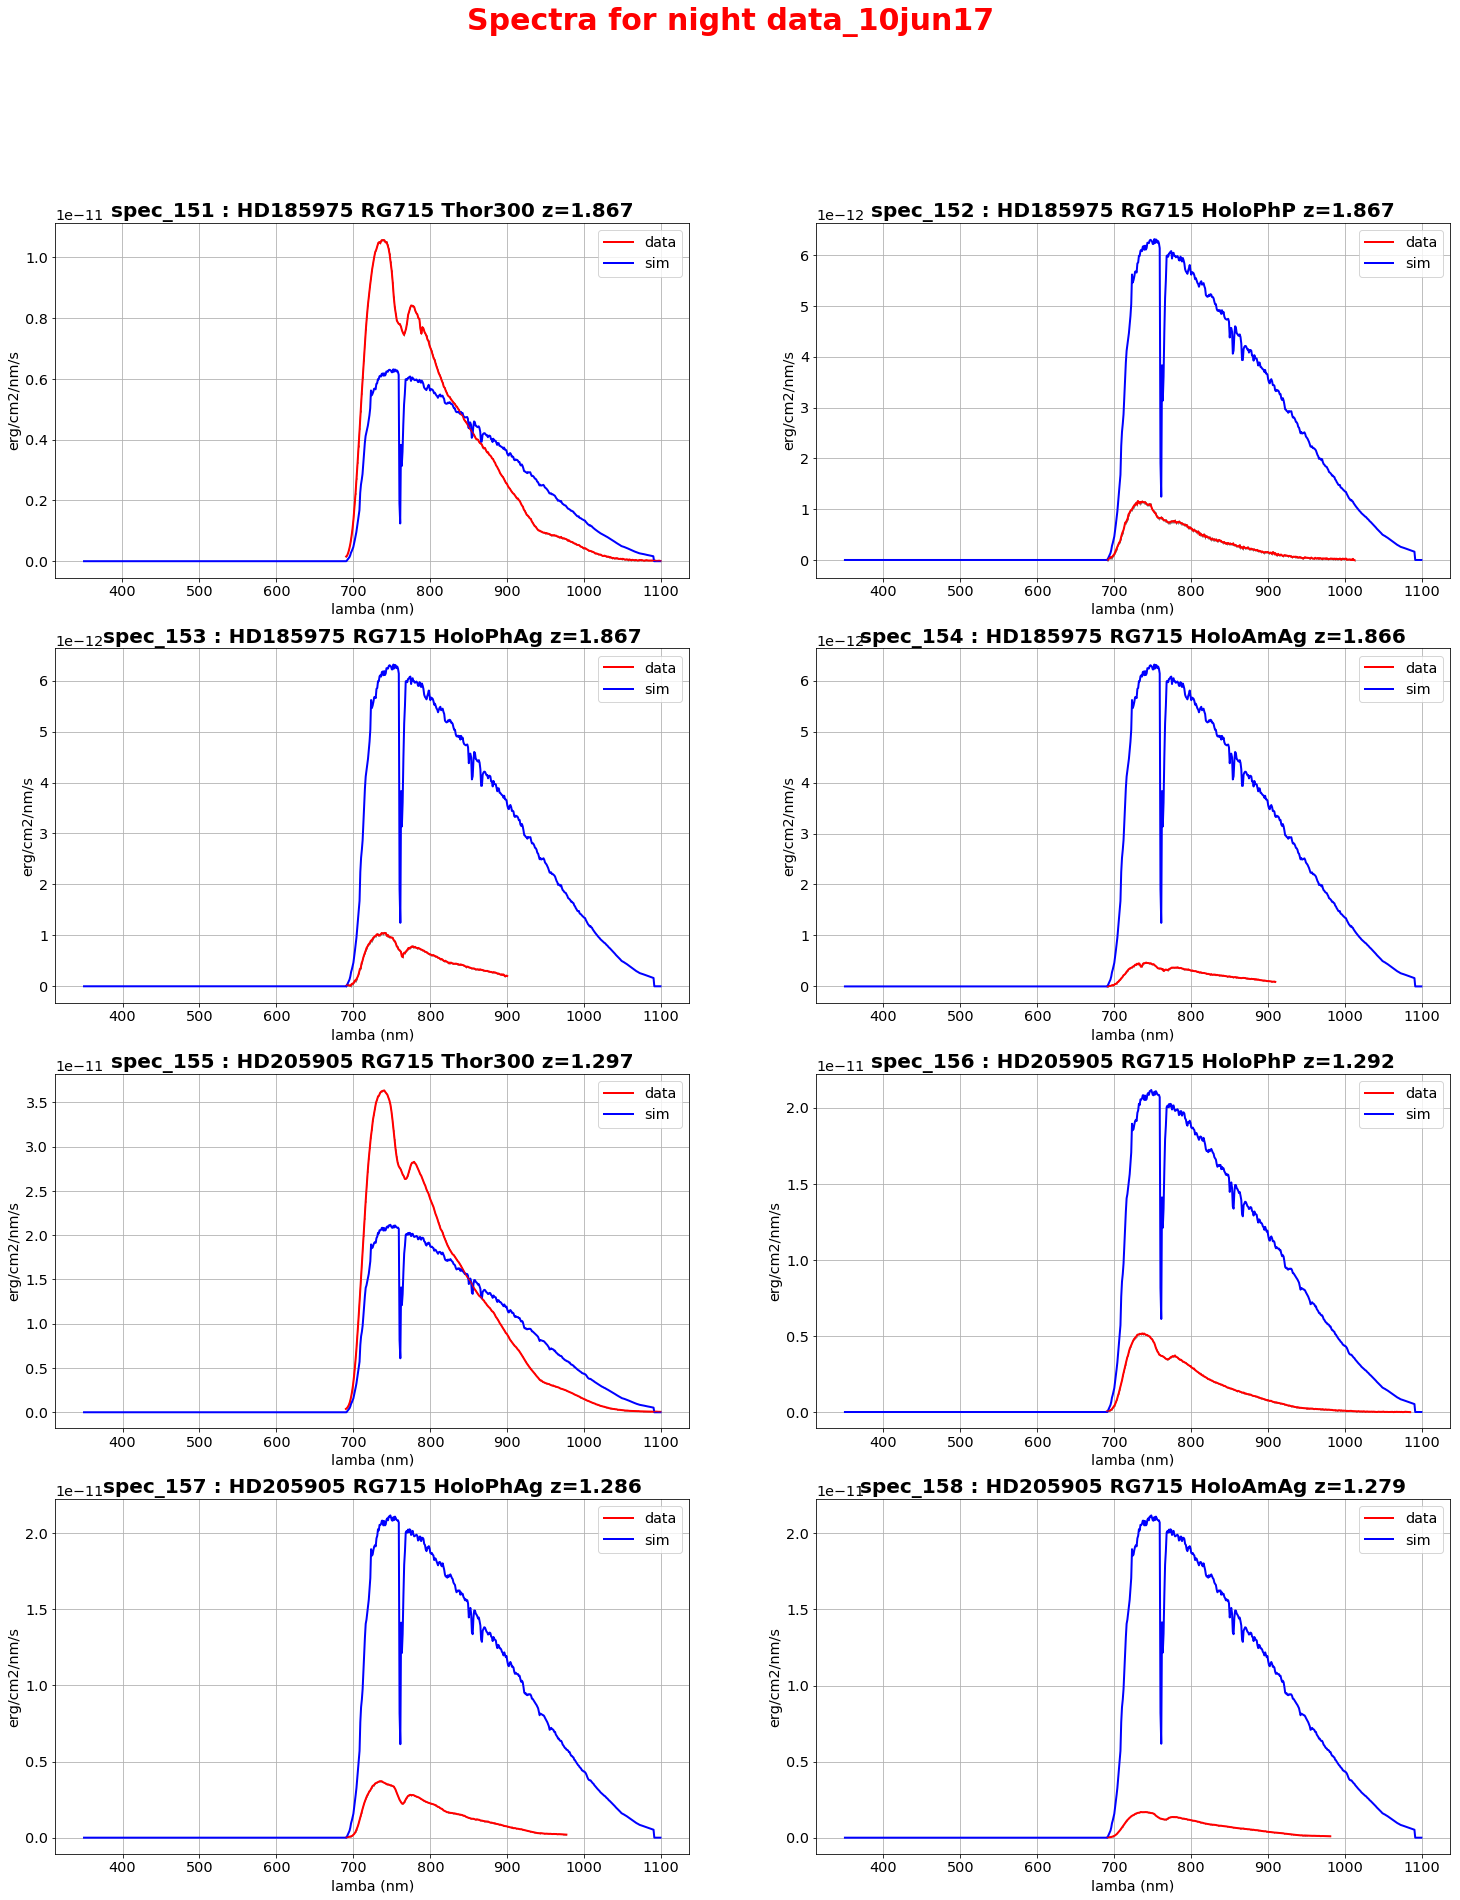

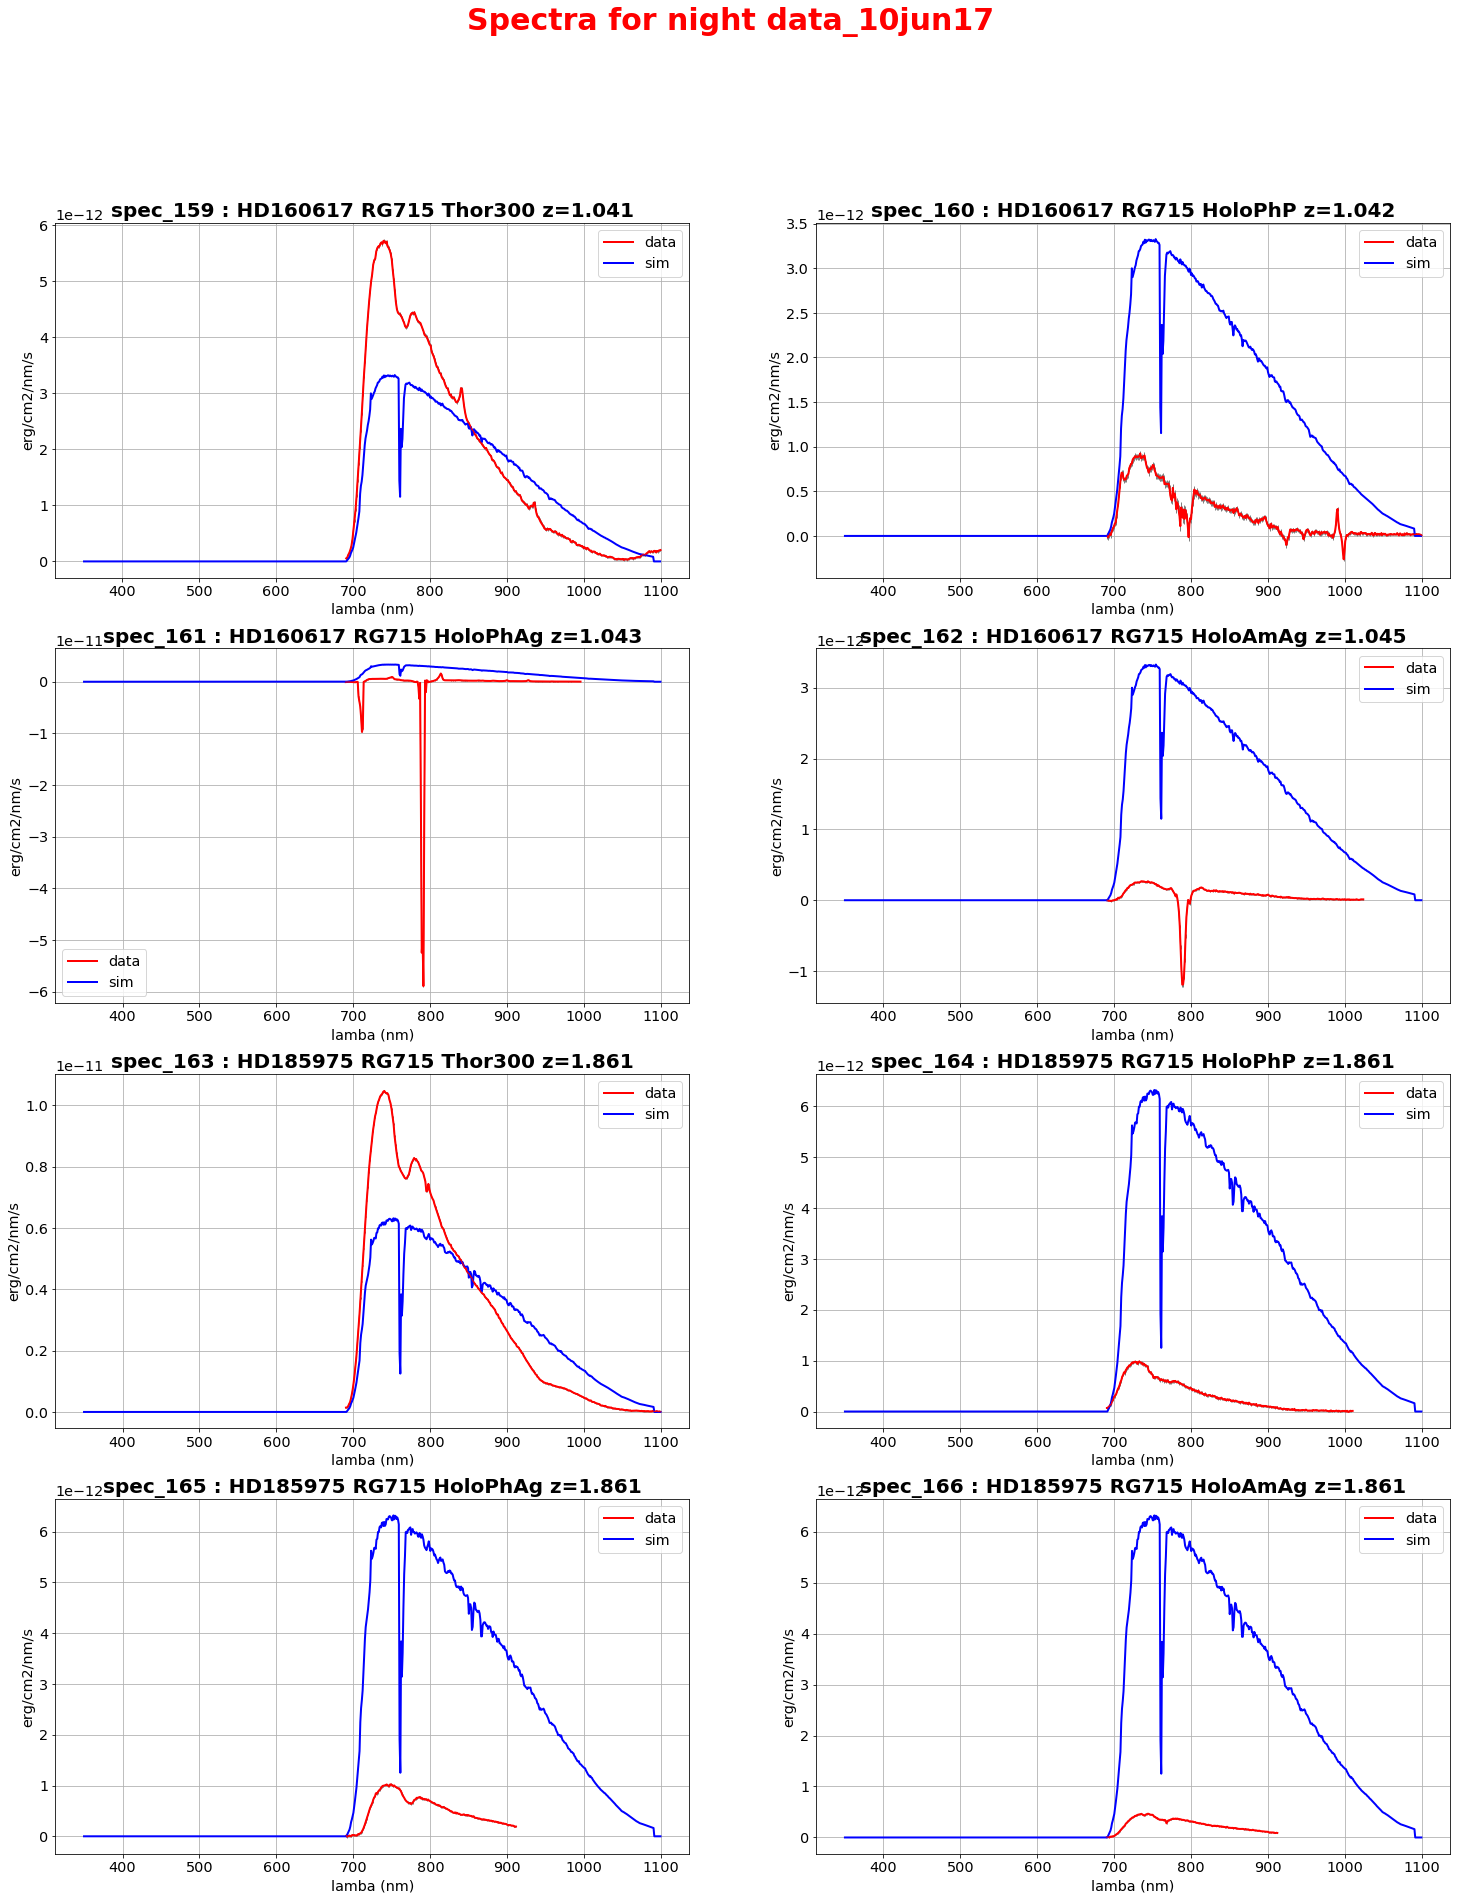

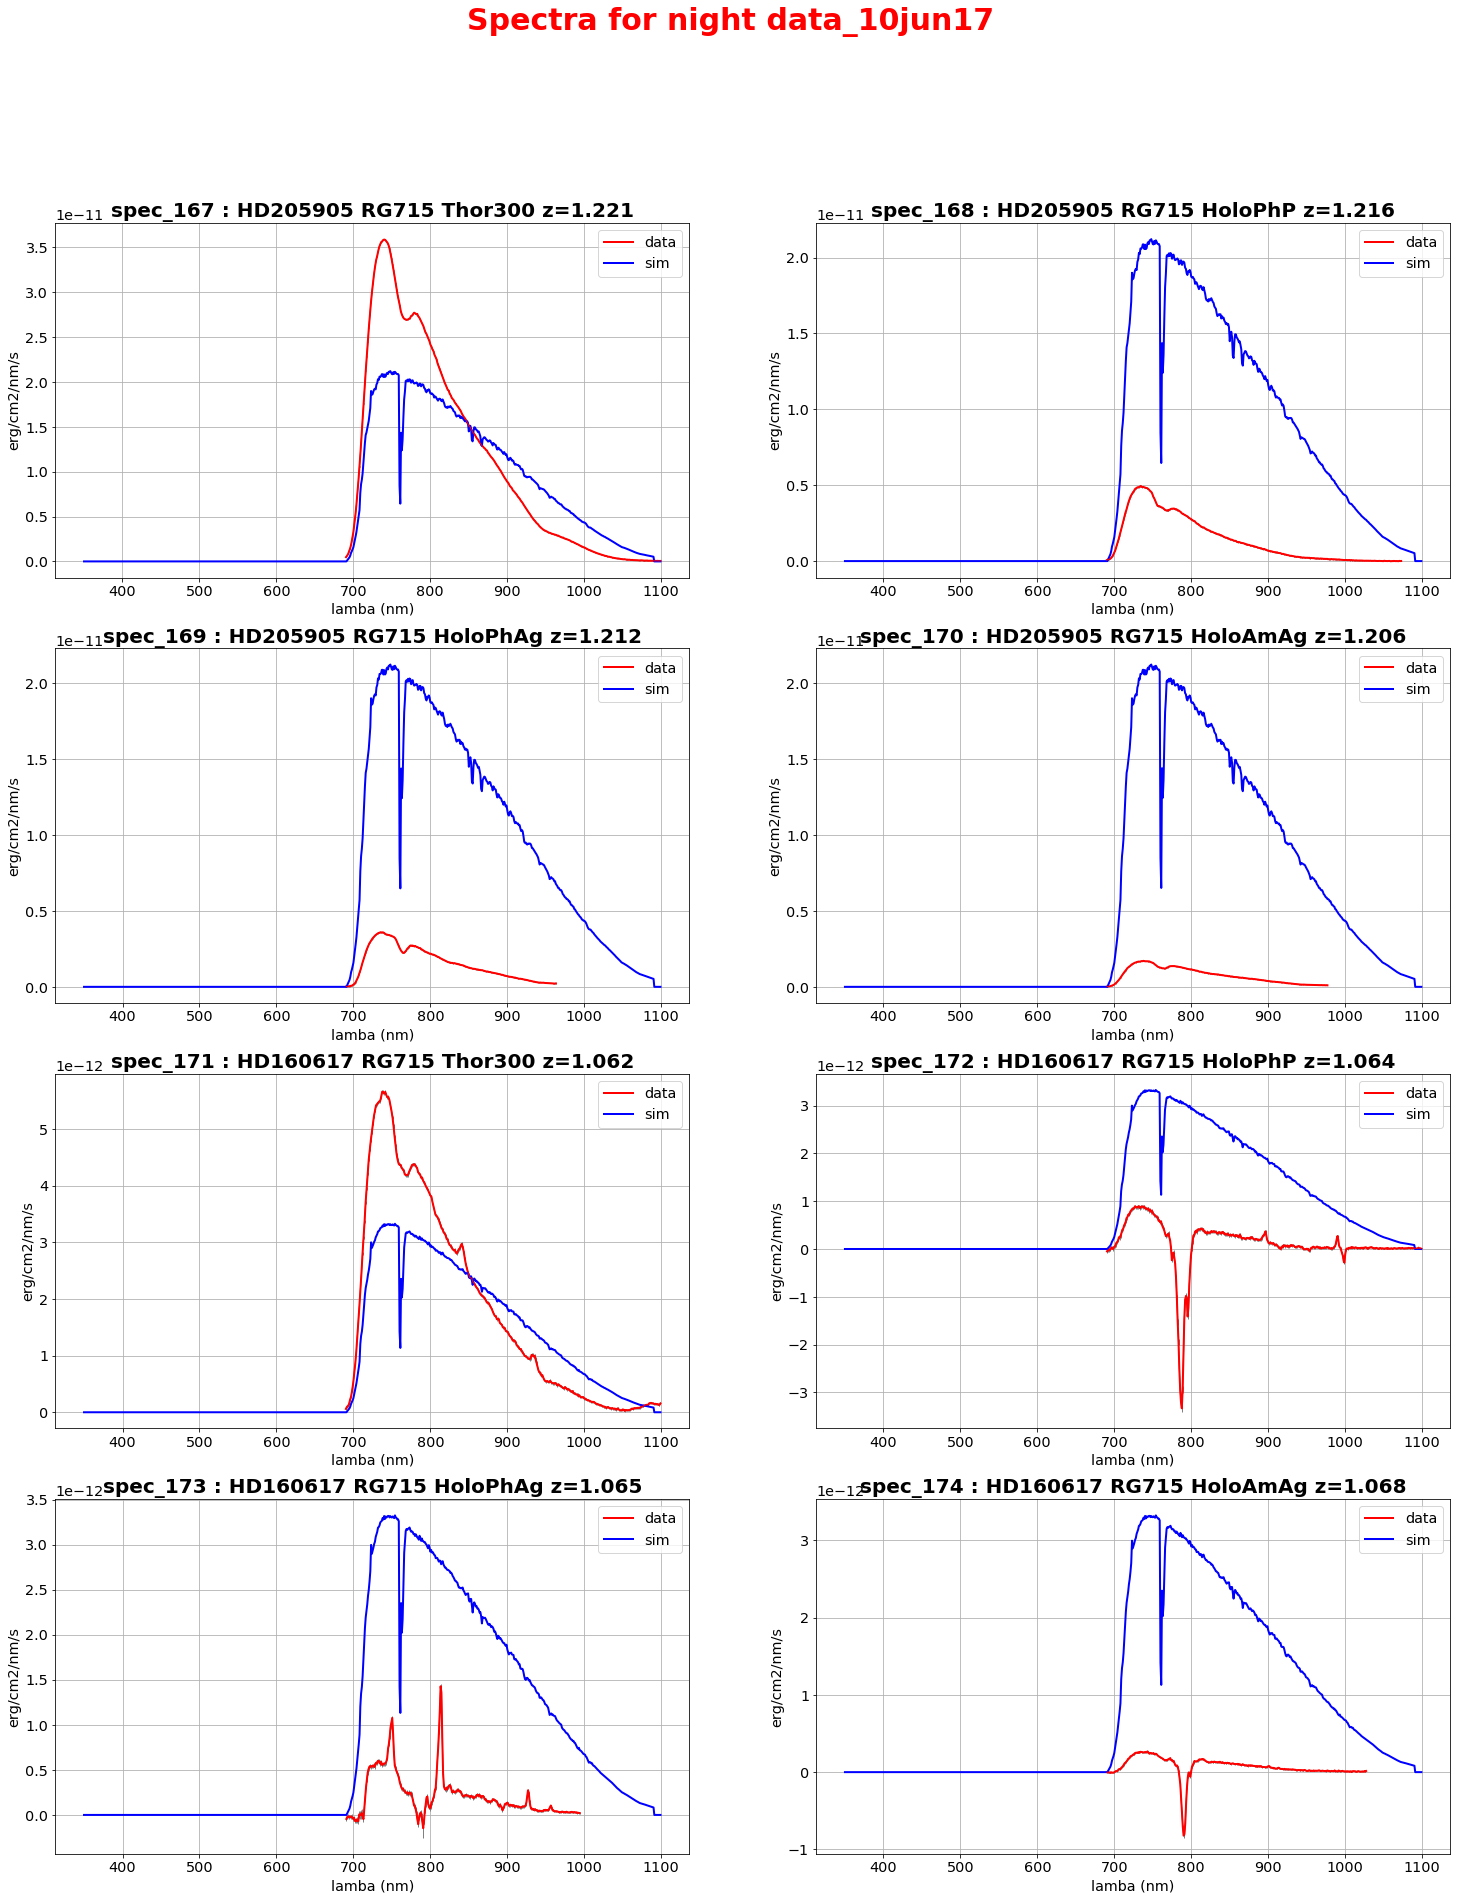

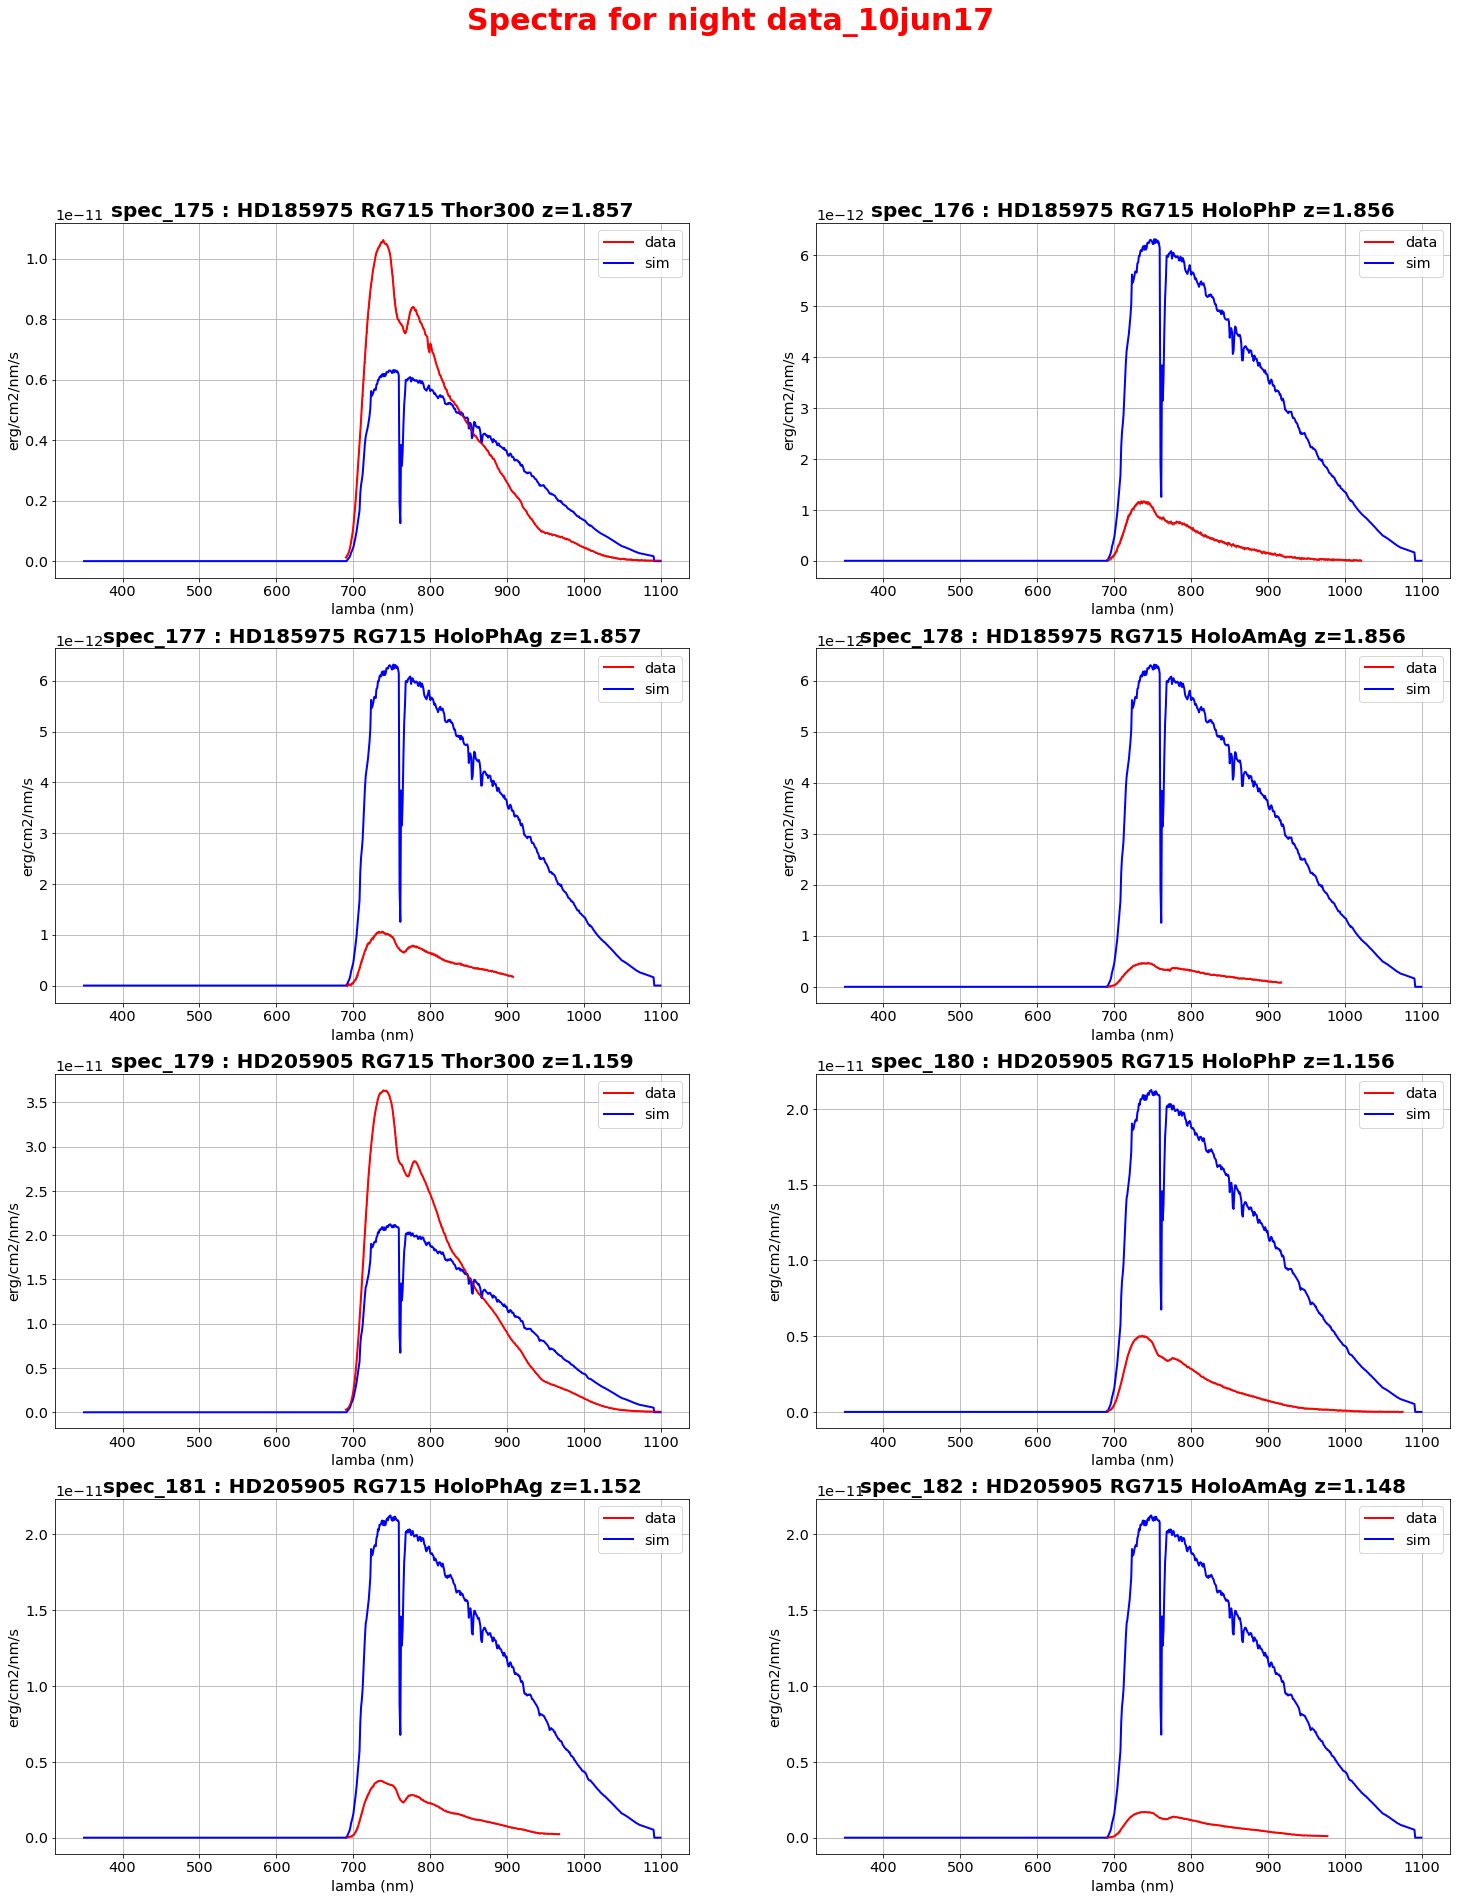

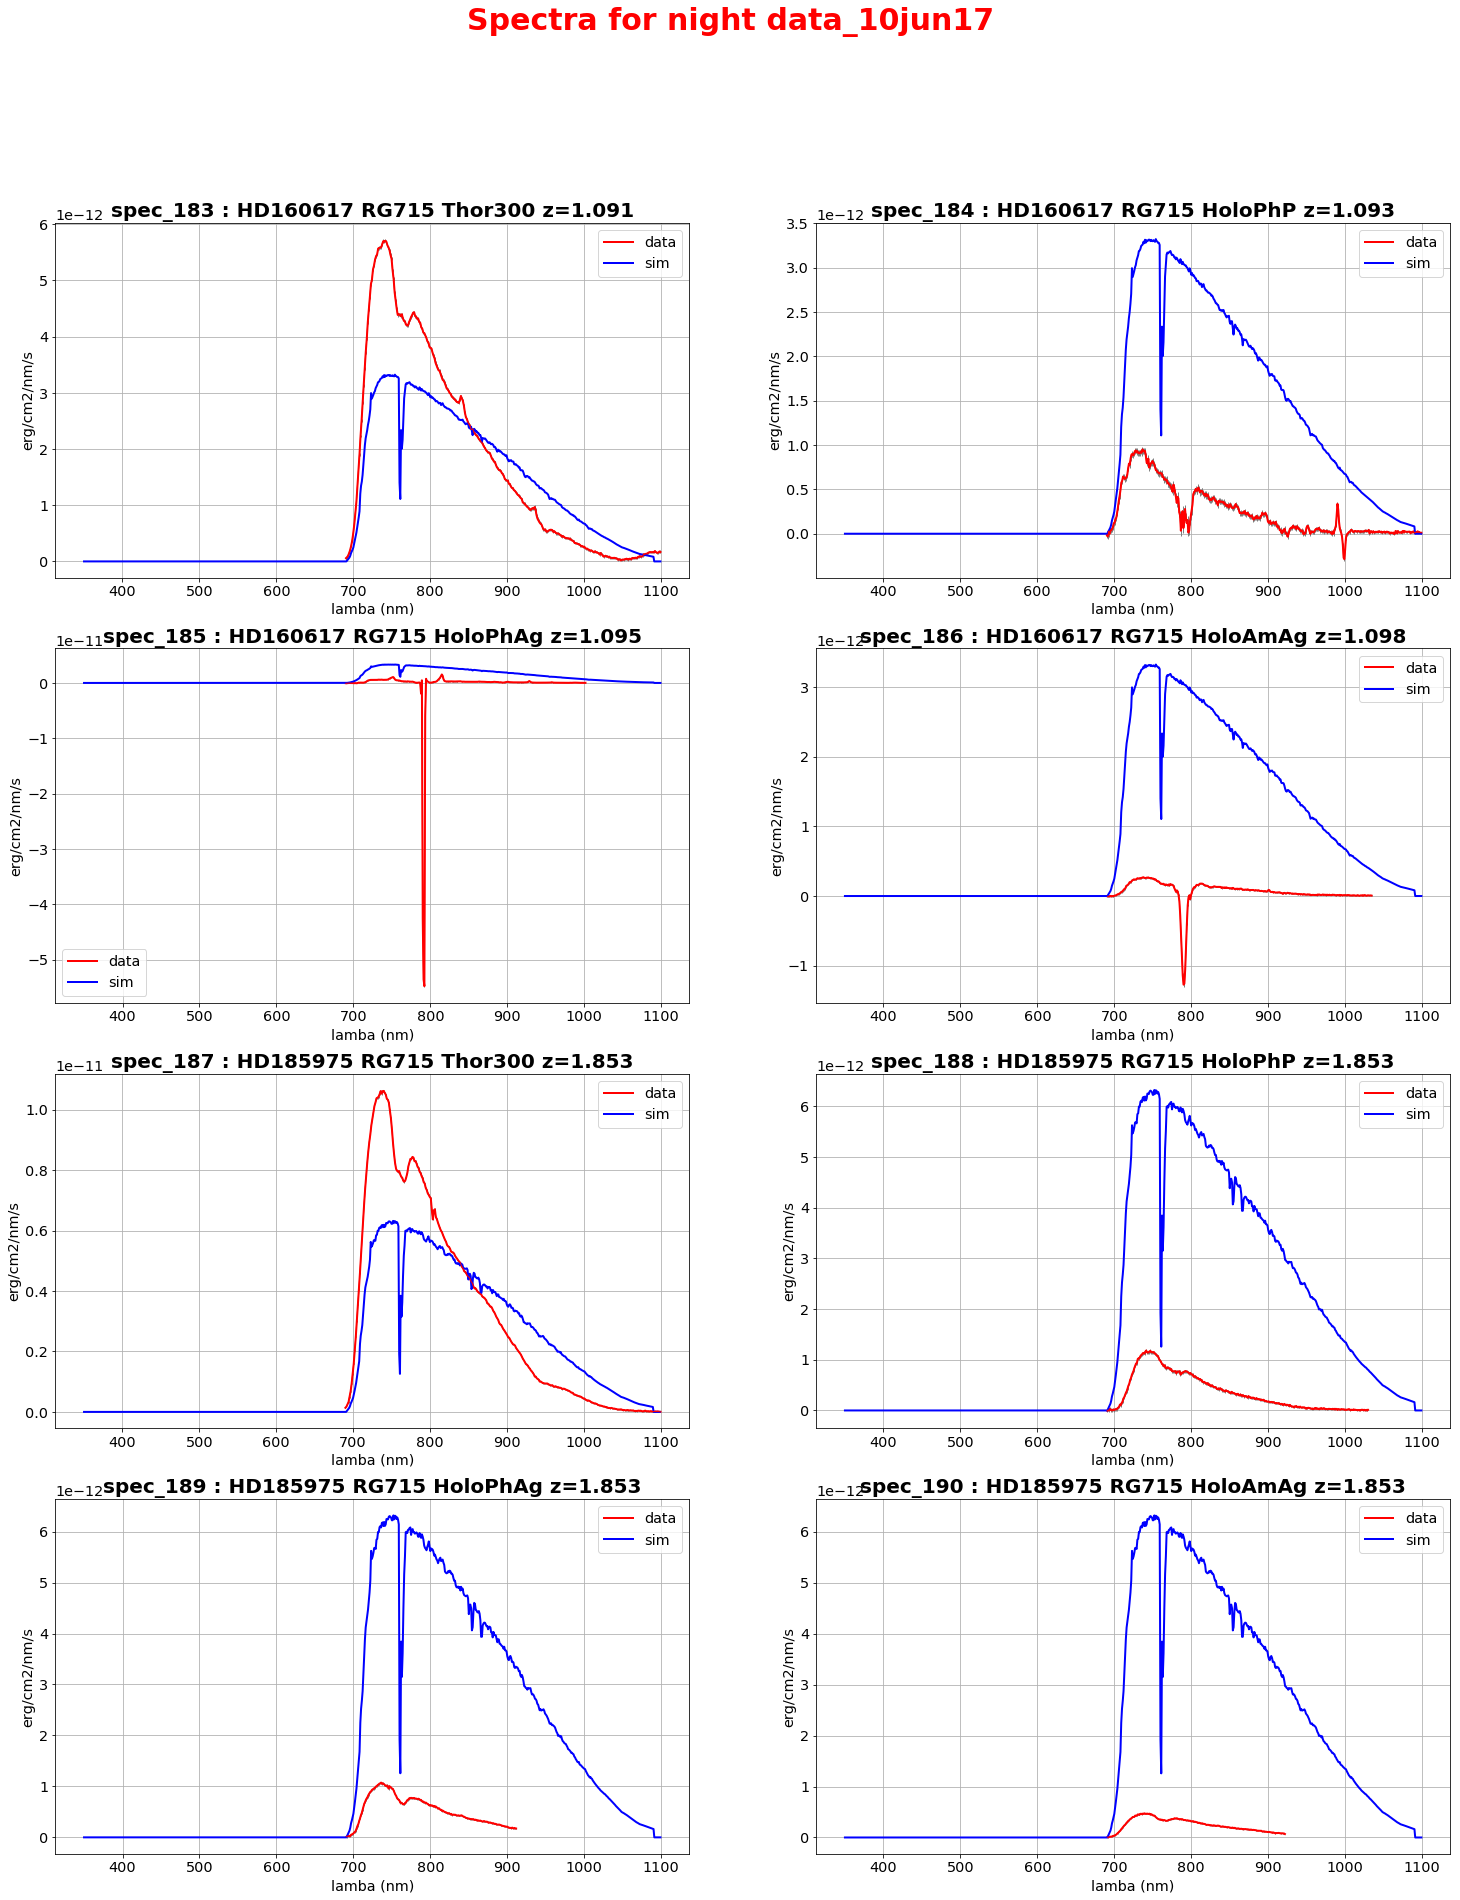

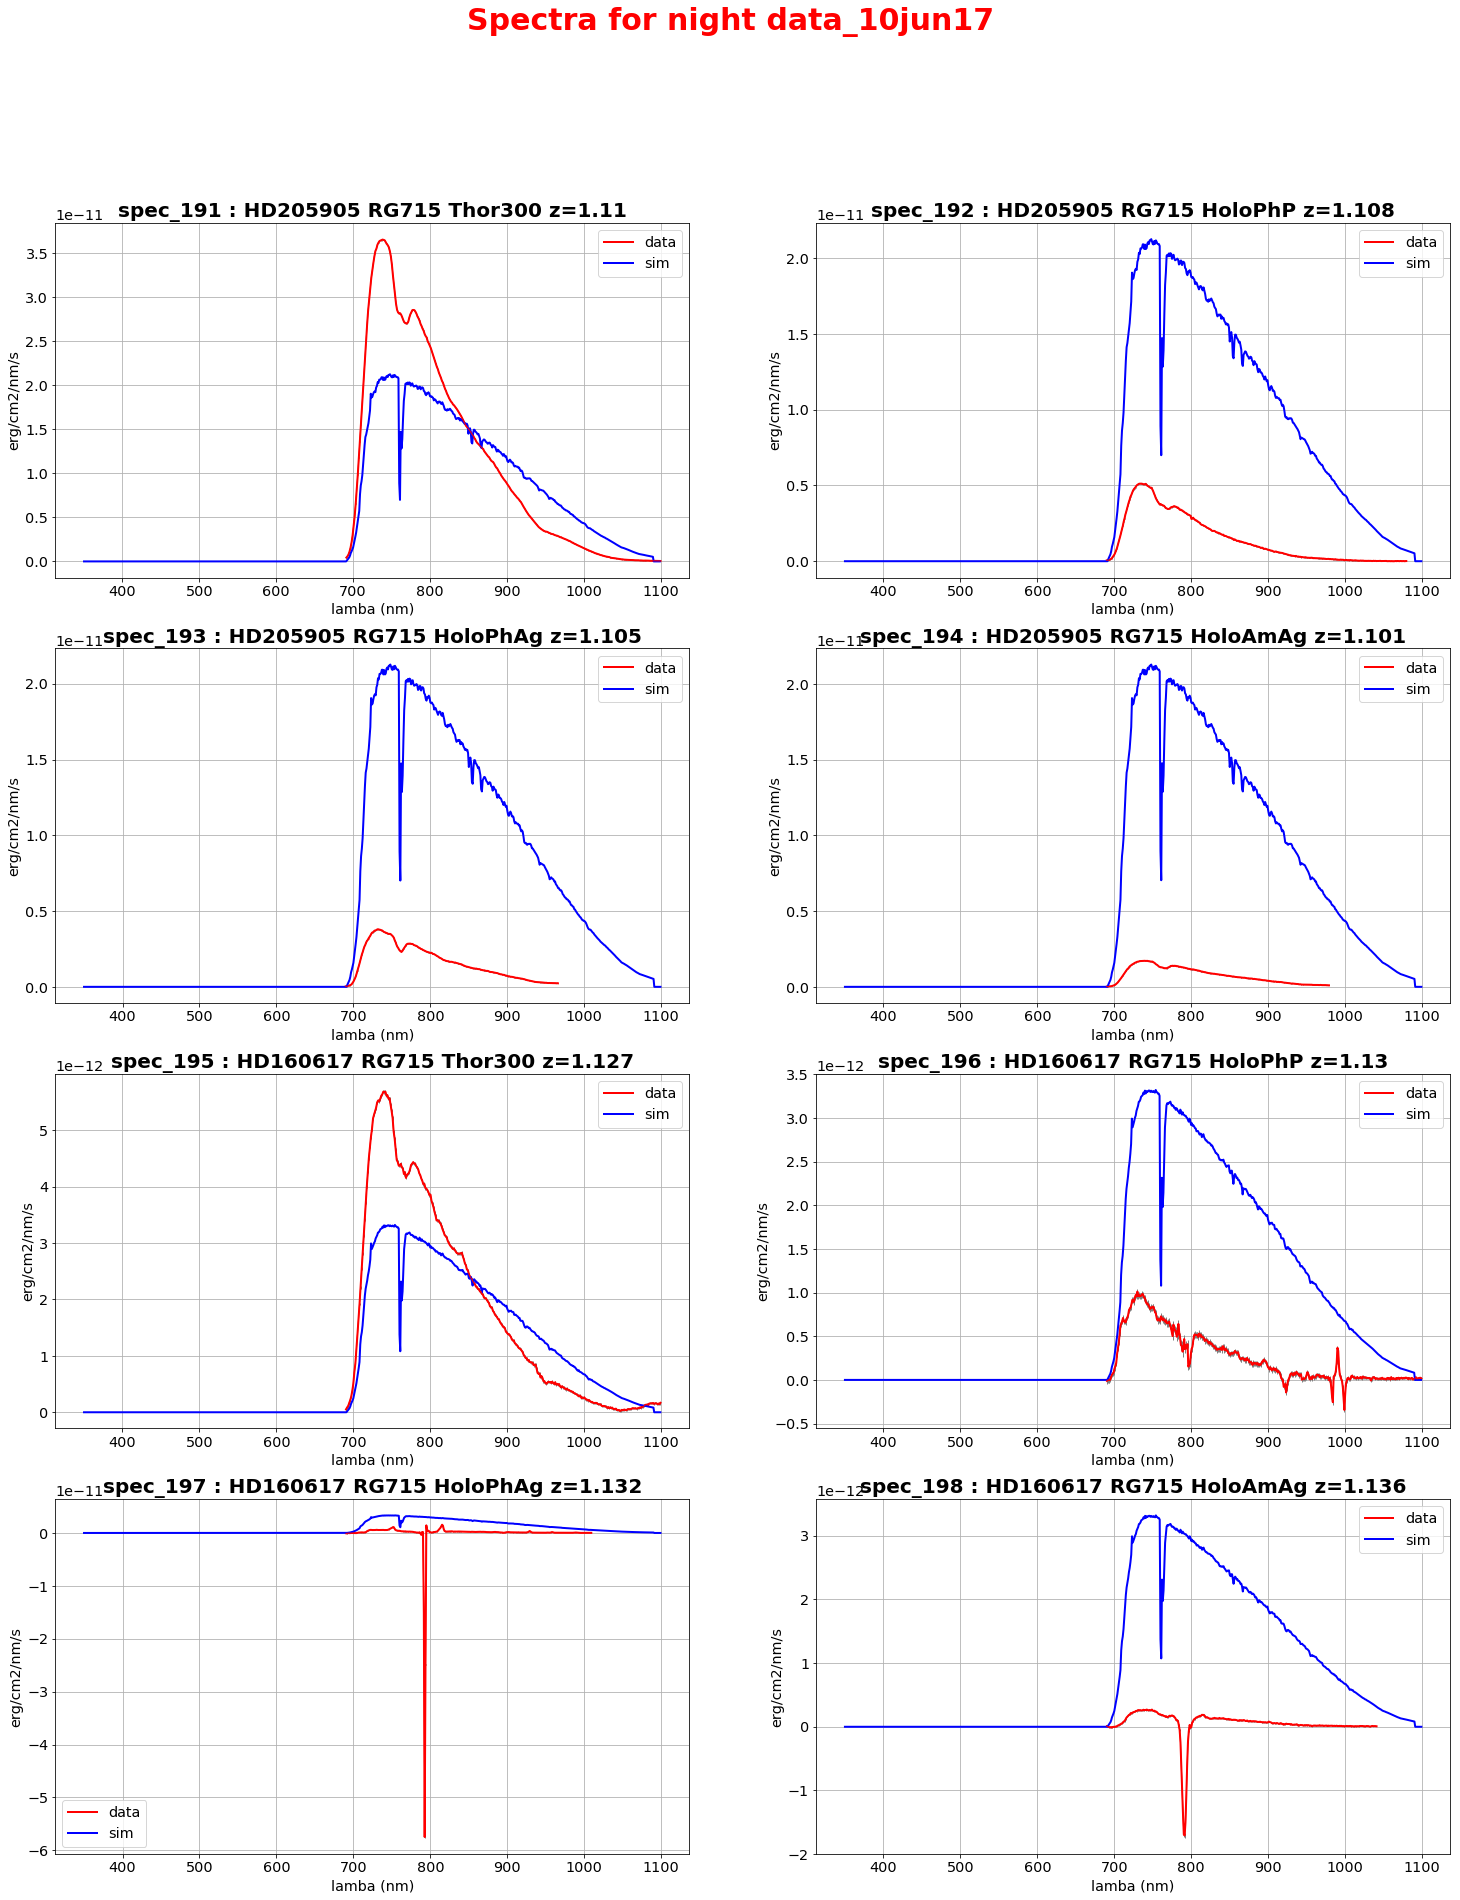

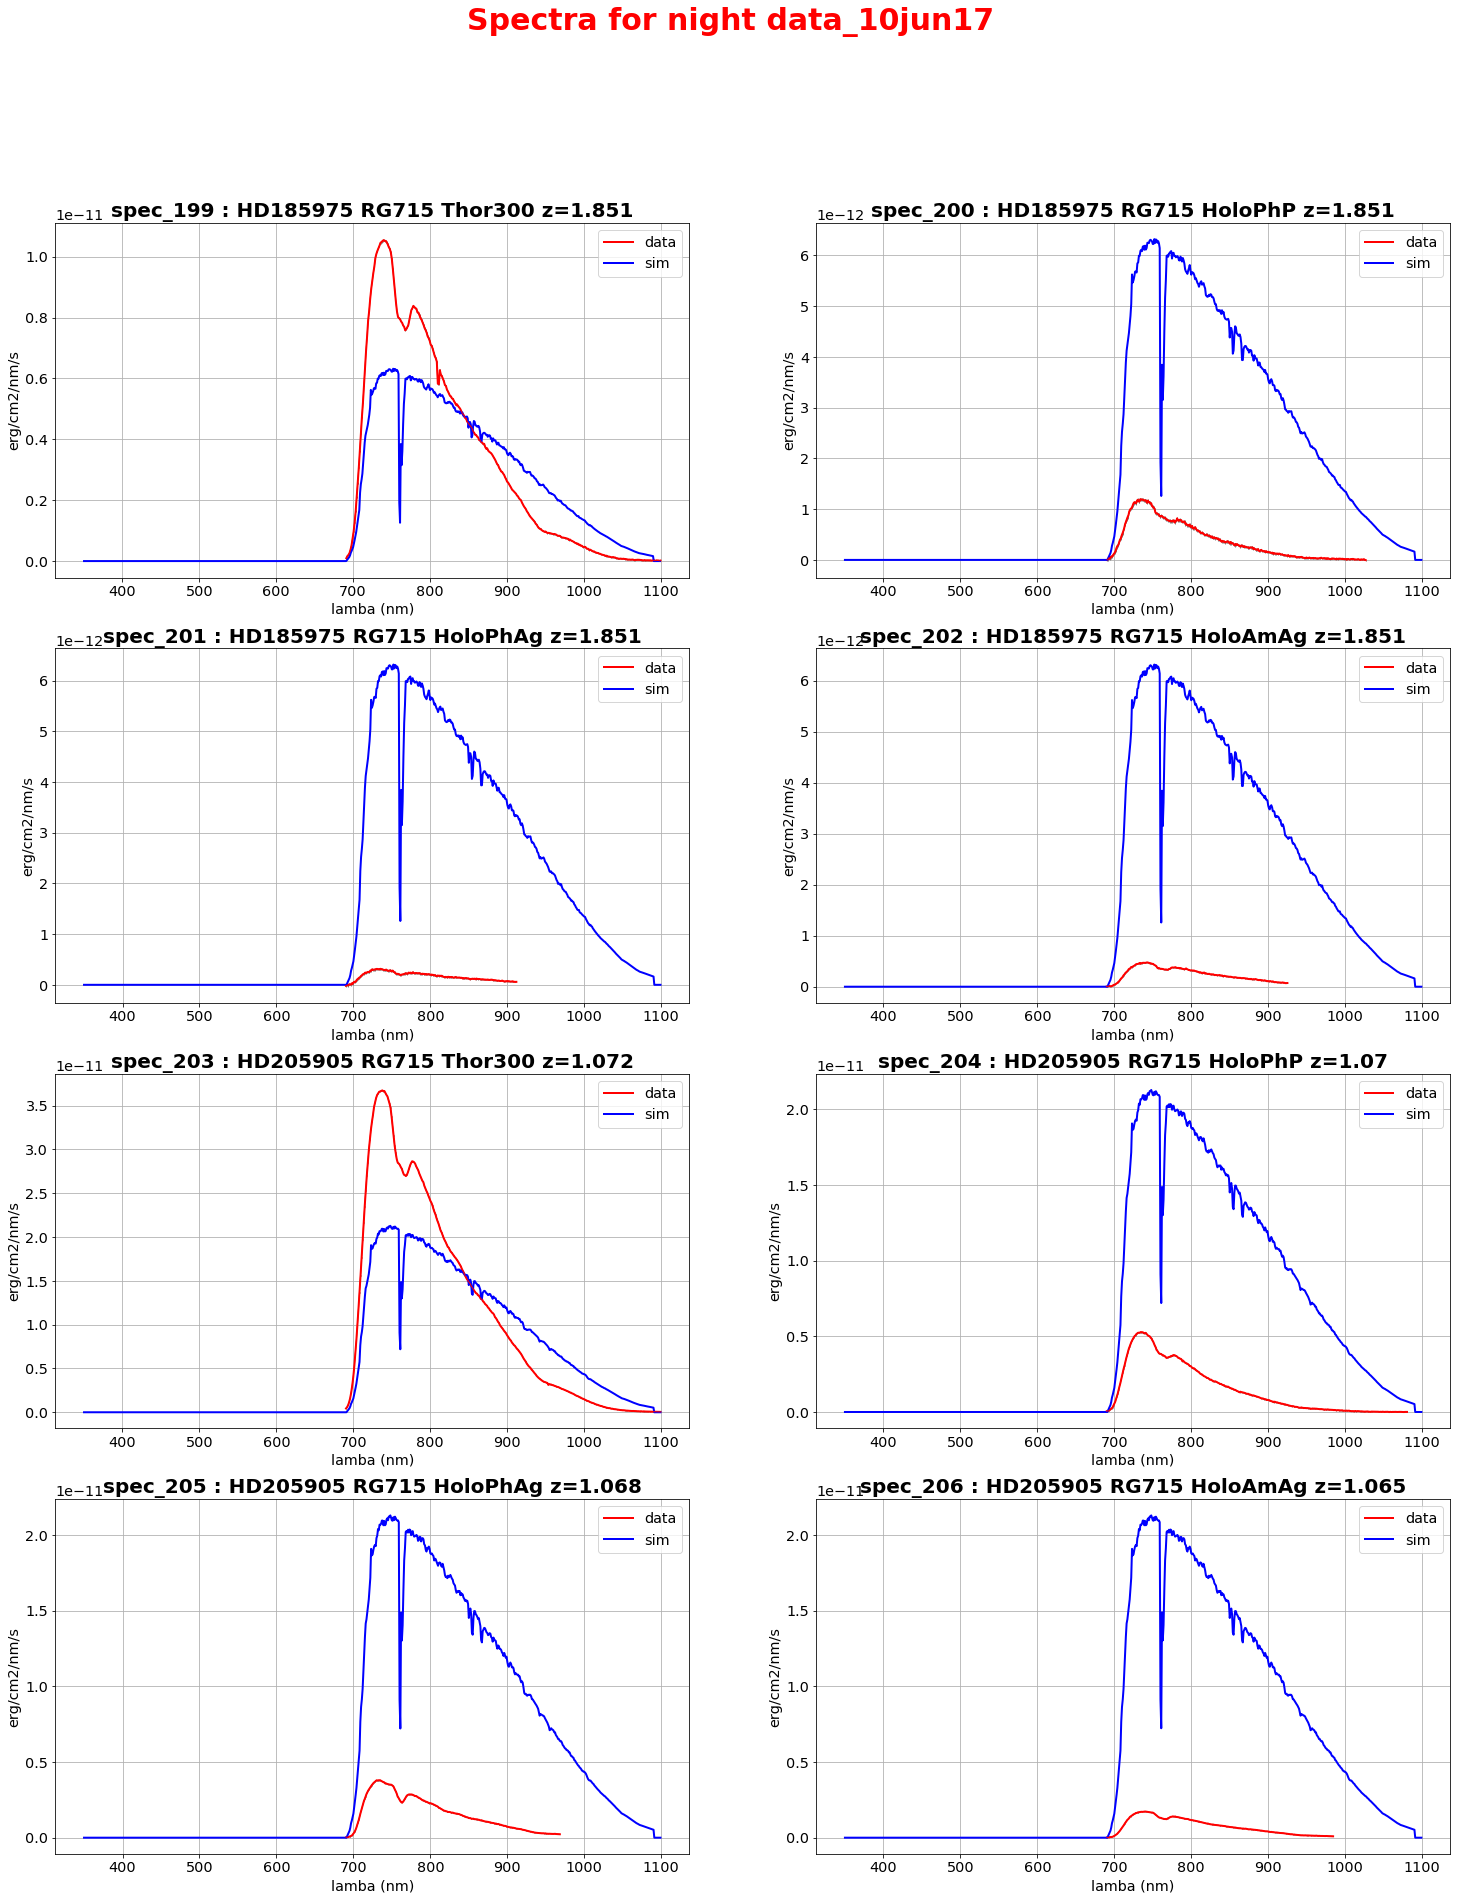

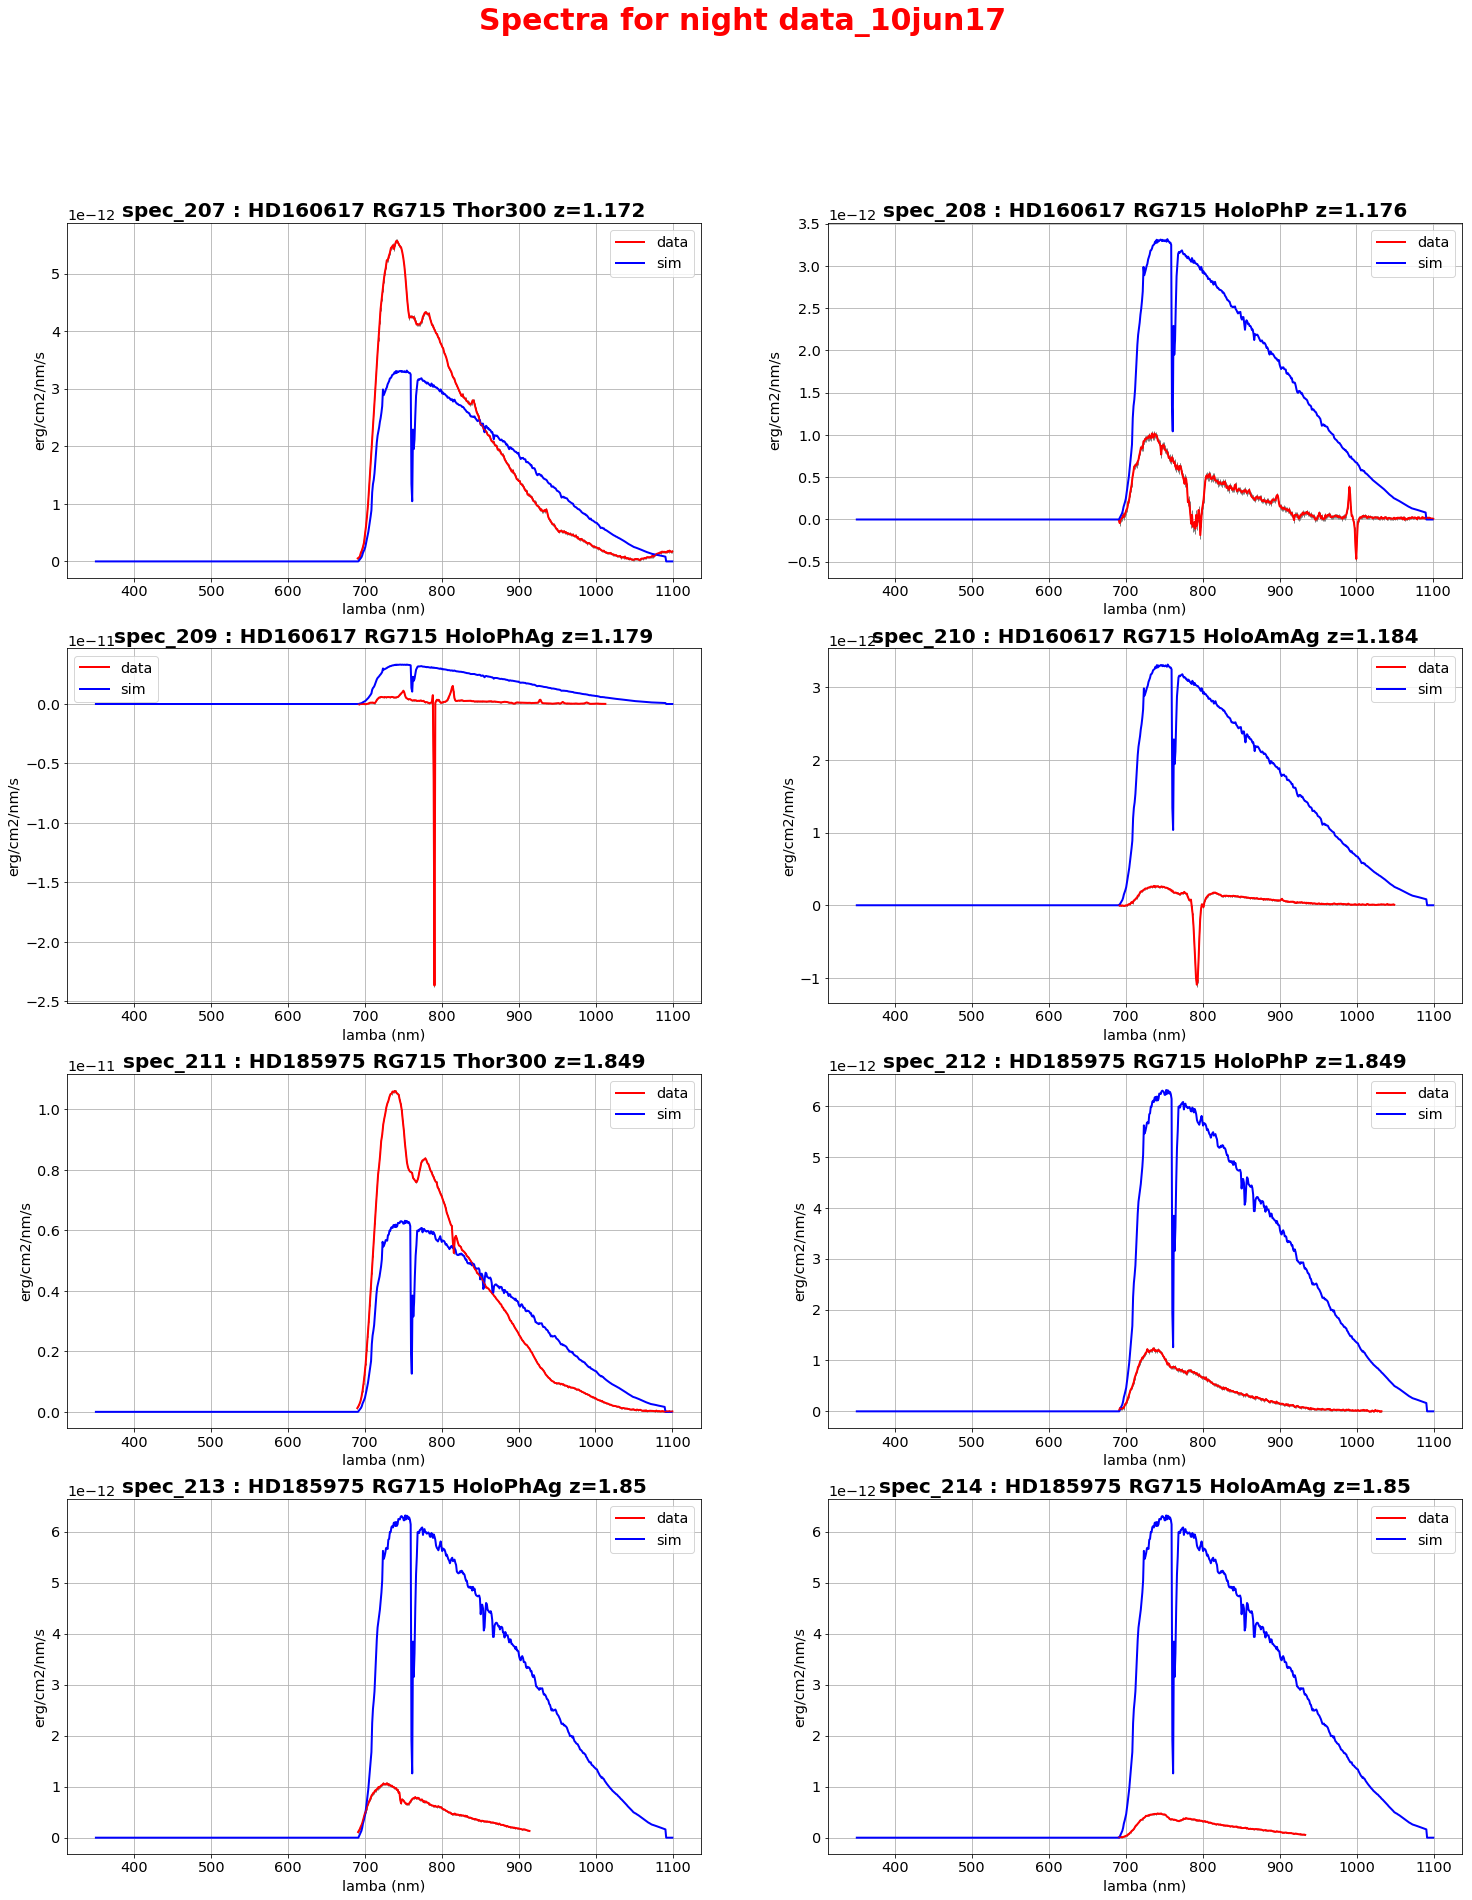

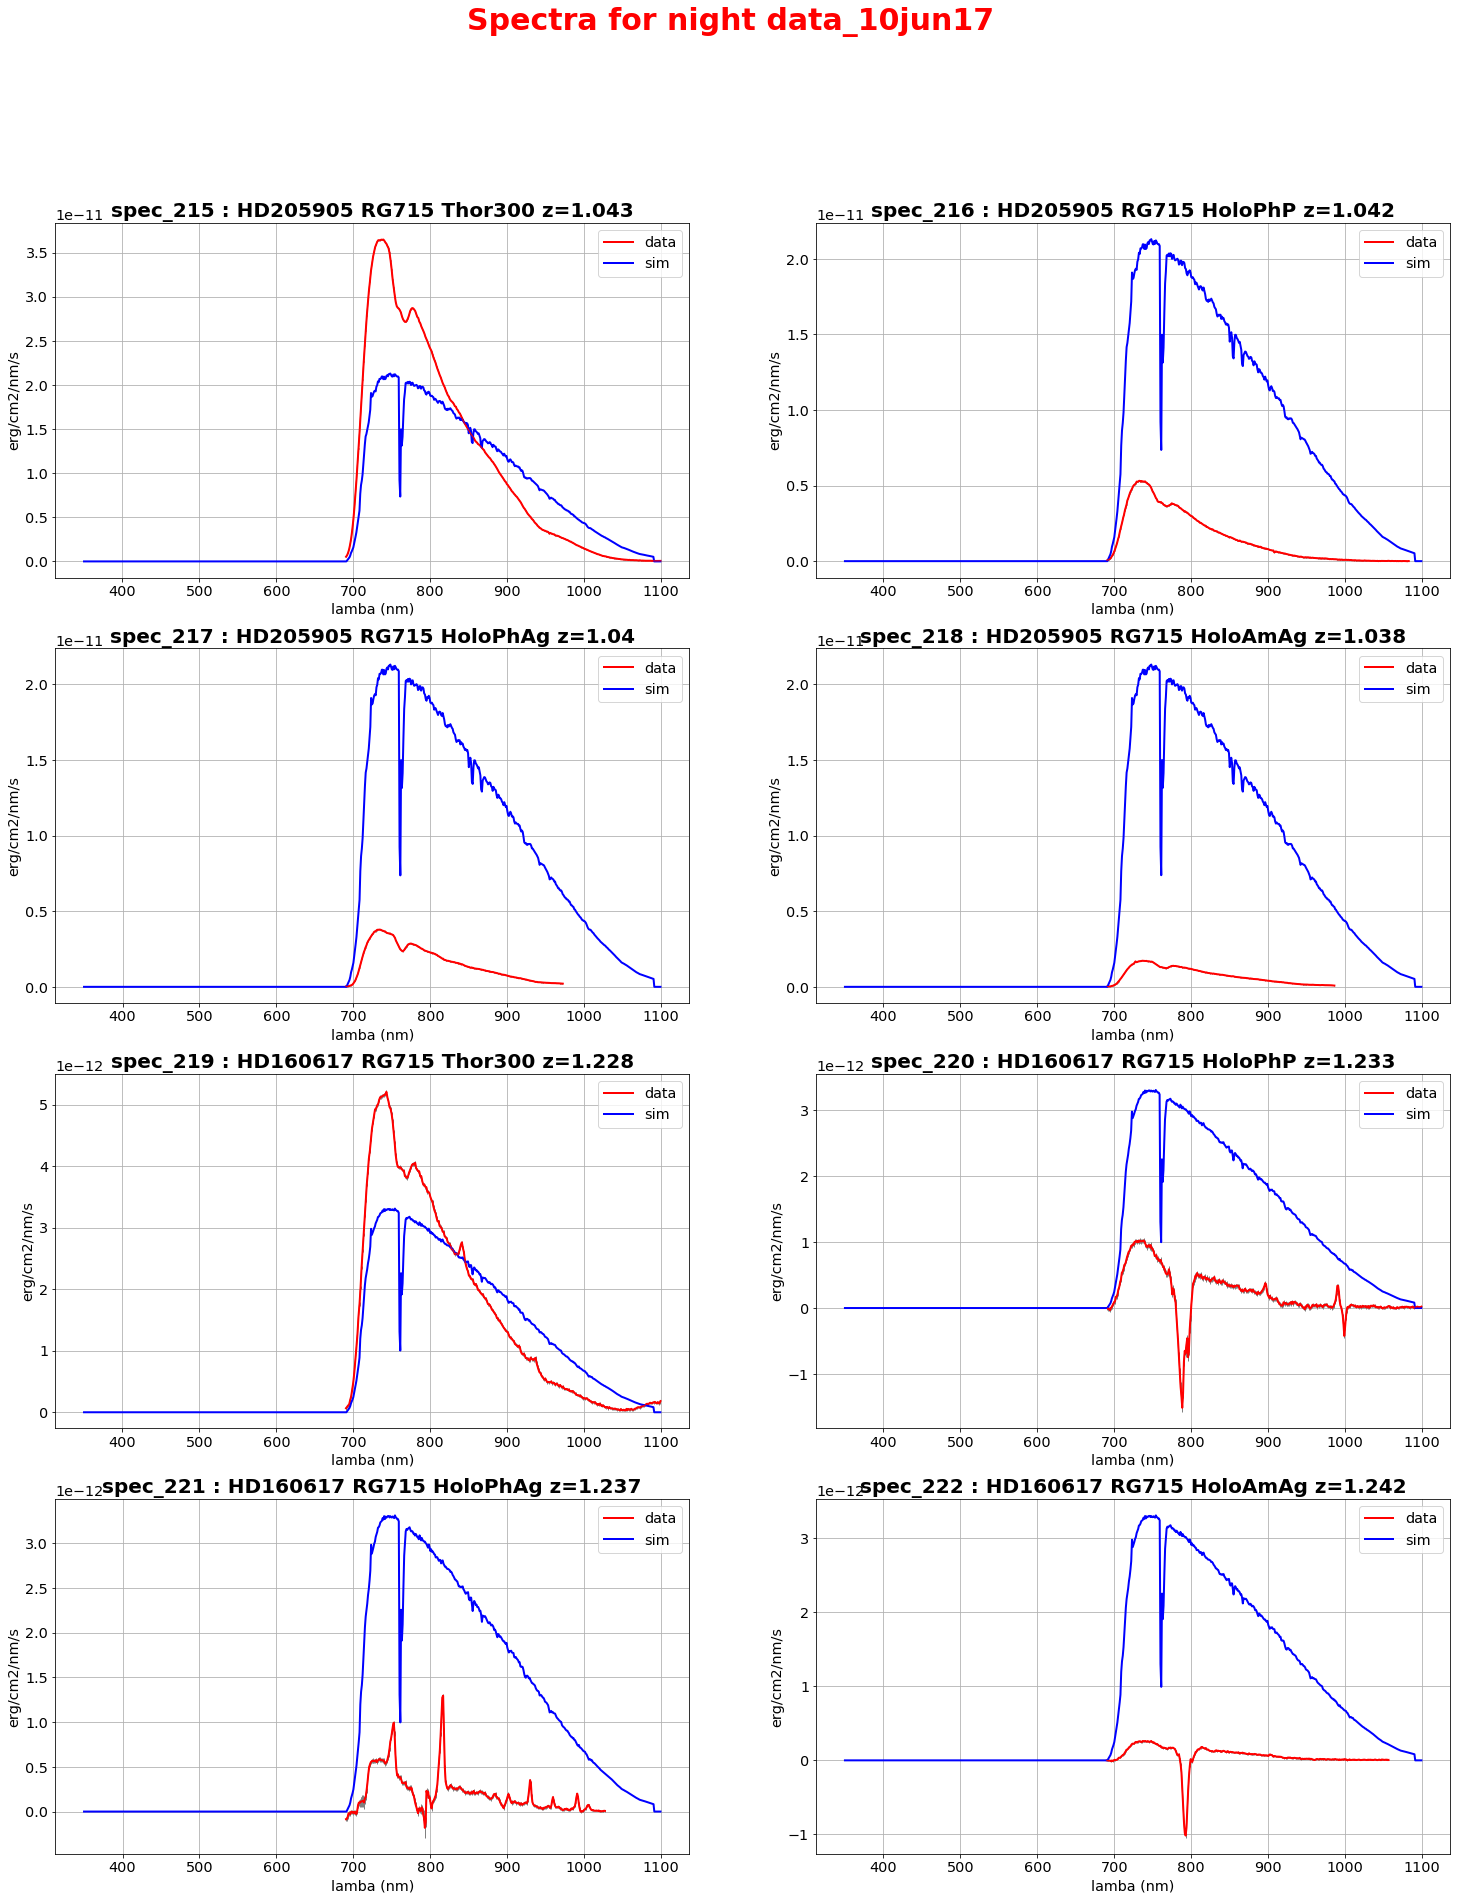

In [ ]:
#definition of the filename and page setup
figfilename=os.path.join('Spectra_100617.pdf')
pp = PdfPages(figfilename) # create a pdf file
title='Spectra for night '+All_Subdirs[idx_sel_subdir]
PageNum=0          # page counter
NBIMGPERROW=2
NBIMGROWPERPAGE=4


idx=0 # counter on plots
# loop on plots
for idx in np.arange(NBPLOTS):
    
    
    if idx%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            f, axarr = plt.subplots(NBIMGROWPERPAGE,NBIMGPERROW,figsize=(25,30))
            f.suptitle(title,fontsize=30,fontweight='bold',color='red')
    
    
    # index of image in the page    
    index=idx-PageNum*(NBIMGROWPERPAGE*NBIMGPERROW)    
    ix=index%NBIMGPERROW
    iy=index/NBIMGPERROW
    
    
    filename=all_spectrafiles[idx]
    simfilename=all_simspectrafiles1[idx]
    
    the_index=get_index_from_filename(filename,SelectTagRe)
    
    hdu1 = fits.open(filename)
    hdu2 = fits.open(simfilename)
       
    data1=hdu1[0].data
    wl1=data1[0]
    f1=data1[1]
    err1=data1[2]
    hdu2 = fits.open(simfilename)
    data2=hdu2[0].data
    
    wl2=data2[0]
    f2=data2[1]
    
    figtitle='spec_'+str(the_index)+' : ' + hdu1[0].header['TARGET']+' '+hdu1[0].header['FILTER1']+' '+hdu1[0].header['FILTER2']+' z='+str(hdu1[0].header['AIRMASS'])
    
    axarr[iy,ix].set_title(figtitle,fontsize='20',fontweight='bold')
    axarr[iy,ix].errorbar(wl1,f1,yerr=err1,color='red',ecolor='grey',lw=1)
    axarr[iy,ix].plot(wl1,f1,'r-',lw=2,label='data')
    axarr[iy,ix].plot(wl2,f2*1e-3,'b-',lw=2,label='sim')
    axarr[iy,ix].set_xlabel("lamba (nm)")
    axarr[iy,ix].set_ylabel("erg/cm2/nm/s")
    axarr[iy,ix].grid(True)
    axarr[iy,ix].legend()
    #plt.show()    
    
    hdu1.close()
    hdu2.close()
    
   
    # save a new page
    if (idx+1)%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
        #f.colorbar(im, orientation="horizontal")
        PageNum+=1  # increase page Number
        f.savefig(pp, format='pdf')
        f.show()
        
        
    #idx+=1    # increase counter on plots
    
    
f.savefig(pp, format='pdf') 
f.show()
pp.close()

